In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


def get_mnist_dataloaders(batch_size=128):
    all_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor()
    ])

    train_data = datasets.MNIST('../data', train=True, download=True,
                                transform=all_transforms)
    test_data = datasets.MNIST('../data', train=False,
                               transform=all_transforms)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):

    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (int(self.img_size[0] / 16), int(self.img_size[1] / 16))
        #print(self.feature_sizes)

        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU(inplace=True)
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.latent_to_features(x)
        x = x.view(-1, 8 * self.dim, self.feature_sizes[0], self.feature_sizes[1])

        return self.features_to_image(x)

    def sample_latent(self, num_samples):

        return torch.randn((num_samples, self.latent_dim))



class Discriminator(nn.Module):

    def __init__(self, img_size, dim):
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim, dim * 2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim * 2, dim * 4, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim * 4, dim * 8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Sigmoid()
        )

        output_size = 8 * dim * int(img_size[0] / 16) * int(img_size[1] / 16)

        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        batch_size = x.size()[0]
        x = self.image_to_features(x)
        x = x.view(batch_size, -1)

        return self.features_to_prob(x)

In [ ]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.autograd import grad
import torch.optim as optim
import torch.autograd as autograd

class Trainer():

    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 gp_weight=10, critic_iteration=5, print_every=50, use_cuda=True,
                 visualize_every=800):
        
        self.G = generator
        self.G_optim = gen_optimizer
        self.D = discriminator
        self.D_optim = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'GN': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iteration
        self.print_every = print_every
        self.visualize_every = visualize_every


        if self.use_cuda:

            self.G.cuda()
            self.D.cuda()

    def critic_train_iteration(self, data):

        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        data = data.cuda()

        d_real = self.D(data)
        d_generated = self.D(generated_data)

        gradient_penalty = self.calc_gp(data, generated_data)
        self.losses['GP'].append(gradient_penalty.item())

        self.D_optim.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()
        self.D_optim.step()

        self.losses['D'].append(d_loss.item())

    def generator_iter(self, data):

        self.G_optim.zero_grad()

        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        d_generated = self.D(generated_data)
        g_loss = -d_generated.mean()
        g_loss.backward()
        self.G_optim.step()

        self.losses['G'].append(g_loss.item())

    def calc_gp(self, real_data, generated_data):

        batch_size = real_data.size()[0]
        alpha = torch.randn(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data).cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = interpolated.cuda()
        interpolated.requires_grad = True

        prob_interpolated = self.D(interpolated)

        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated, 
                                  grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                                  create_graph=True, retain_graph=True)[0]
        
        gradients = gradients.view(batch_size, -1)

        self.losses['GN'].append(gradients.norm(2, dim=1).mean().item())

        grad_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        return self.gp_weight * ((grad_norm - 1) ** 2).mean()

    def train_epoch(self, data_loader):

        for i, data in enumerate(data_loader):

            self.num_steps += 1
            self.critic_train_iteration(data[0])

            if self.num_steps % self.critic_iterations == 0:
                #print(self.num_steps)
                self.generator_iter(data[0])

            if i % self.print_every == 0 and i != 0:

                print(f"Epoch: {i + 1} | Discriminator Loss - {self.losses['D'][-1]} | Gradient Penalty - {self.losses['GP'][-1]} |Generator Loss - {self.losses['G'][-1]}]")
            if i % self.visualize_every == 0 and i != 0:

                fixed_latents = self.G.sample_latent(8)
                fixed_latents = fixed_latents.cuda()

                img_grid = make_grid(self.G(fixed_latents).cpu().data)
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
                plt.figure(figsize = (30,10))
                plt.imshow(img_grid)
                plt.show()

    def train(self, data_loader, epochs, save_training_gif=True):

        if save_training_gif:

            fixed_latents = self.G.sample_latent(64)
            fixed_latents = fixed_latents.cuda()

            training_progress_images = []

        for epoch in range(epochs):

            print(f"\nEpoch {epoch + 1}")
            self.train_epoch(data_loader)


    def sample_generator(self, num_samples):

        latent_samples = self.G.sample_latent(num_samples)

        if self.use_cuda:
            latent_samples = latent_samples.cuda()

        generated_data = self.G(latent_samples)

        return generated_data



        

        


Epoch 1
Epoch: 51 | Discriminator Loss - 9.552678108215332 | Gradient Penalty - 9.783390045166016 |Generator Loss - -0.35136520862579346]
Epoch: 101 | Discriminator Loss - 8.78676986694336 | Gradient Penalty - 9.67324447631836 |Generator Loss - -0.0564882718026638]
Epoch: 151 | Discriminator Loss - 8.65278434753418 | Gradient Penalty - 9.435514450073242 |Generator Loss - -0.1945948302745819]
Epoch: 201 | Discriminator Loss - 5.888038158416748 | Gradient Penalty - 6.323032855987549 |Generator Loss - -0.3004803955554962]
Epoch: 251 | Discriminator Loss - 5.084962368011475 | Gradient Penalty - 5.247775077819824 |Generator Loss - -0.3407512903213501]
Epoch: 301 | Discriminator Loss - 4.9658002853393555 | Gradient Penalty - 5.217025279998779 |Generator Loss - -0.36621469259262085]
Epoch: 351 | Discriminator Loss - 4.827245712280273 | Gradient Penalty - 5.13911247253418 |Generator Loss - -0.3904627859592438]
Epoch: 401 | Discriminator Loss - 5.039063453674316 | Gradient Penalty - 5.47489881

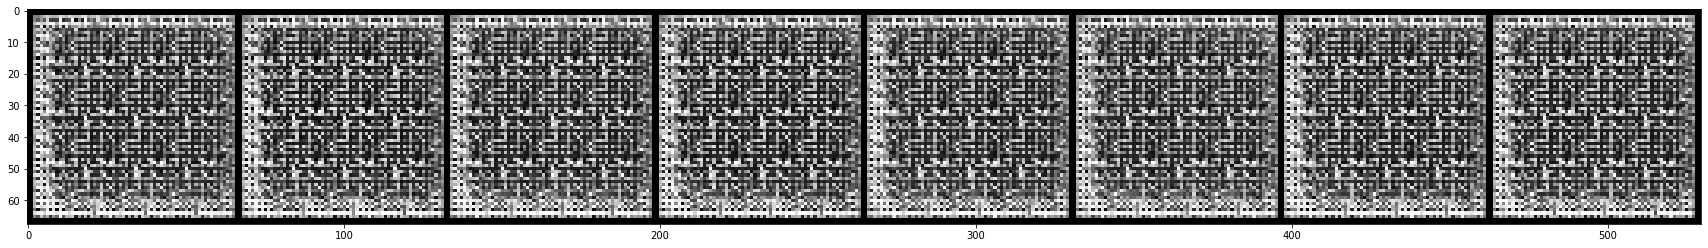

Epoch: 851 | Discriminator Loss - 5.285055160522461 | Gradient Penalty - 5.6023430824279785 |Generator Loss - -0.46202903985977173]
Epoch: 901 | Discriminator Loss - 4.648460865020752 | Gradient Penalty - 4.954334259033203 |Generator Loss - -0.3852653503417969]

Epoch 2
Epoch: 51 | Discriminator Loss - 5.073712348937988 | Gradient Penalty - 5.367434024810791 |Generator Loss - -0.39310702681541443]
Epoch: 101 | Discriminator Loss - 4.279237747192383 | Gradient Penalty - 4.629623889923096 |Generator Loss - -0.38813531398773193]
Epoch: 151 | Discriminator Loss - 4.3888983726501465 | Gradient Penalty - 4.669747829437256 |Generator Loss - -0.4615496098995209]
Epoch: 201 | Discriminator Loss - 4.9366865158081055 | Gradient Penalty - 5.191295146942139 |Generator Loss - -0.4153691530227661]
Epoch: 251 | Discriminator Loss - 4.758109092712402 | Gradient Penalty - 5.043540954589844 |Generator Loss - -0.3711952865123749]
Epoch: 301 | Discriminator Loss - 4.2809343338012695 | Gradient Penalty - 4.

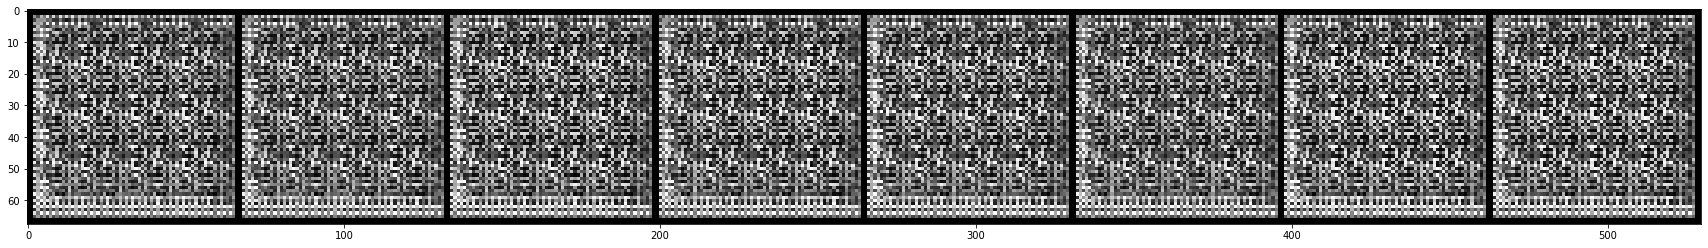

Epoch: 851 | Discriminator Loss - 3.651327133178711 | Gradient Penalty - 4.013752460479736 |Generator Loss - -0.3497646450996399]
Epoch: 901 | Discriminator Loss - 3.658783435821533 | Gradient Penalty - 3.953702449798584 |Generator Loss - -0.4494163393974304]

Epoch 3
Epoch: 51 | Discriminator Loss - 3.3312411308288574 | Gradient Penalty - 3.7915563583374023 |Generator Loss - -0.3977821469306946]
Epoch: 101 | Discriminator Loss - 3.6370158195495605 | Gradient Penalty - 4.078648090362549 |Generator Loss - -0.45163044333457947]
Epoch: 151 | Discriminator Loss - 3.8574557304382324 | Gradient Penalty - 4.2076592445373535 |Generator Loss - -0.5229781866073608]
Epoch: 201 | Discriminator Loss - 3.9606151580810547 | Gradient Penalty - 4.40189266204834 |Generator Loss - -0.4122246205806732]
Epoch: 251 | Discriminator Loss - 2.711622953414917 | Gradient Penalty - 3.1215455532073975 |Generator Loss - -0.4528900980949402]
Epoch: 301 | Discriminator Loss - 3.2132012844085693 | Gradient Penalty - 3

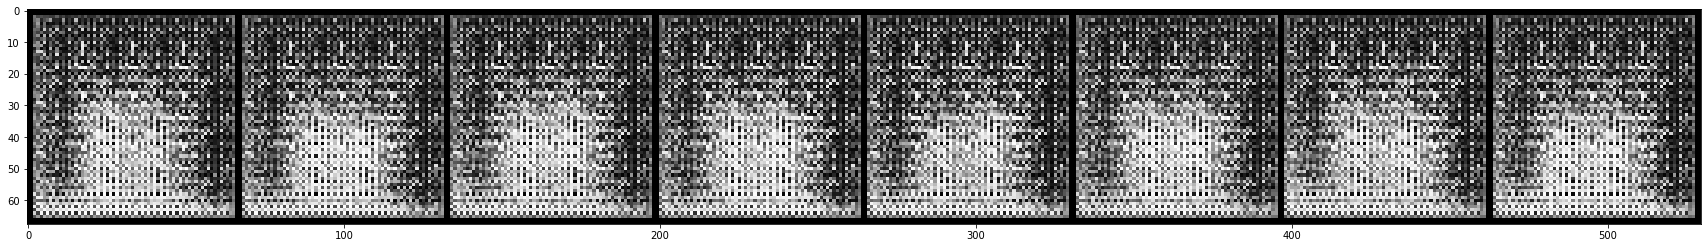

Epoch: 851 | Discriminator Loss - 2.112889289855957 | Gradient Penalty - 2.5228521823883057 |Generator Loss - -0.45538368821144104]
Epoch: 901 | Discriminator Loss - 1.688315749168396 | Gradient Penalty - 2.08329701423645 |Generator Loss - -0.3777755796909332]

Epoch 4
Epoch: 51 | Discriminator Loss - 1.7589194774627686 | Gradient Penalty - 2.1954636573791504 |Generator Loss - -0.3950031101703644]
Epoch: 101 | Discriminator Loss - 1.3230522871017456 | Gradient Penalty - 1.739747405052185 |Generator Loss - -0.4115932583808899]
Epoch: 151 | Discriminator Loss - 1.0304369926452637 | Gradient Penalty - 1.5094053745269775 |Generator Loss - -0.3720824718475342]
Epoch: 201 | Discriminator Loss - 1.039905071258545 | Gradient Penalty - 1.5129112005233765 |Generator Loss - -0.4103209674358368]
Epoch: 251 | Discriminator Loss - 1.228078007698059 | Gradient Penalty - 1.6461739540100098 |Generator Loss - -0.41334426403045654]
Epoch: 301 | Discriminator Loss - 0.8757163882255554 | Gradient Penalty -

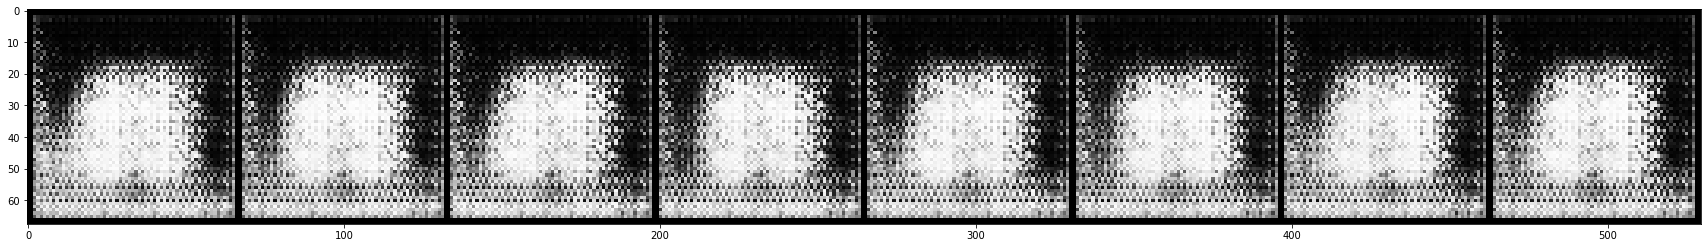

Epoch: 851 | Discriminator Loss - 0.20196771621704102 | Gradient Penalty - 0.669636607170105 |Generator Loss - -0.38080209493637085]
Epoch: 901 | Discriminator Loss - -0.009758800268173218 | Gradient Penalty - 0.45801812410354614 |Generator Loss - -0.3740903437137604]

Epoch 5
Epoch: 51 | Discriminator Loss - 0.3349304795265198 | Gradient Penalty - 0.7132387161254883 |Generator Loss - -0.36549147963523865]
Epoch: 101 | Discriminator Loss - -0.17265033721923828 | Gradient Penalty - 0.25395360589027405 |Generator Loss - -0.4616745412349701]
Epoch: 151 | Discriminator Loss - 0.03339362144470215 | Gradient Penalty - 0.42047613859176636 |Generator Loss - -0.39441969990730286]
Epoch: 201 | Discriminator Loss - 0.14000779390335083 | Gradient Penalty - 0.36903977394104004 |Generator Loss - -0.5878192186355591]
Epoch: 251 | Discriminator Loss - 0.08817088603973389 | Gradient Penalty - 0.5177819728851318 |Generator Loss - -0.444919615983963]
Epoch: 301 | Discriminator Loss - 0.07856029272079468 

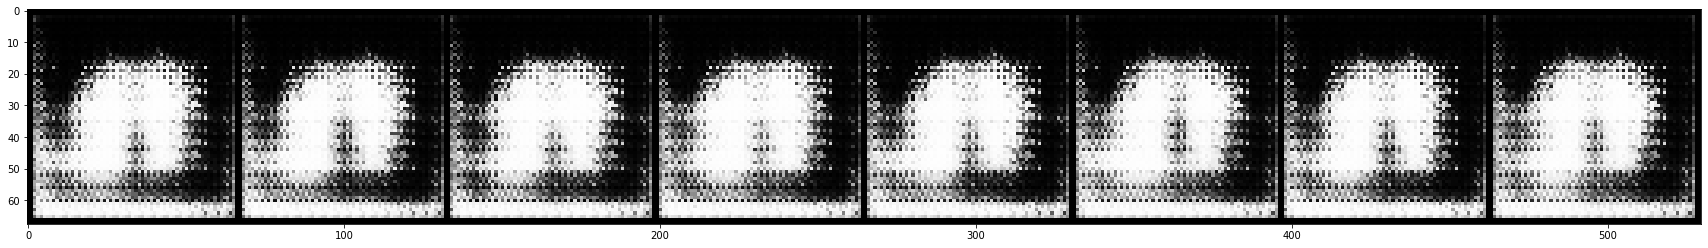

Epoch: 851 | Discriminator Loss - -0.029107272624969482 | Gradient Penalty - 0.2837267518043518 |Generator Loss - -0.5014357566833496]
Epoch: 901 | Discriminator Loss - 0.07771909236907959 | Gradient Penalty - 0.43125927448272705 |Generator Loss - -0.4855607748031616]

Epoch 6
Epoch: 51 | Discriminator Loss - 0.16682901978492737 | Gradient Penalty - 0.3771187365055084 |Generator Loss - -0.6068595051765442]
Epoch: 101 | Discriminator Loss - -0.0248582661151886 | Gradient Penalty - 0.34202539920806885 |Generator Loss - -0.46701568365097046]
Epoch: 151 | Discriminator Loss - 0.6068464517593384 | Gradient Penalty - 0.6993088722229004 |Generator Loss - -0.8652673959732056]
Epoch: 201 | Discriminator Loss - 0.15120738744735718 | Gradient Penalty - 0.44864457845687866 |Generator Loss - -0.5666465163230896]
Epoch: 251 | Discriminator Loss - 0.050597190856933594 | Gradient Penalty - 0.35340338945388794 |Generator Loss - -0.47032779455184937]
Epoch: 301 | Discriminator Loss - -0.0122062265872955

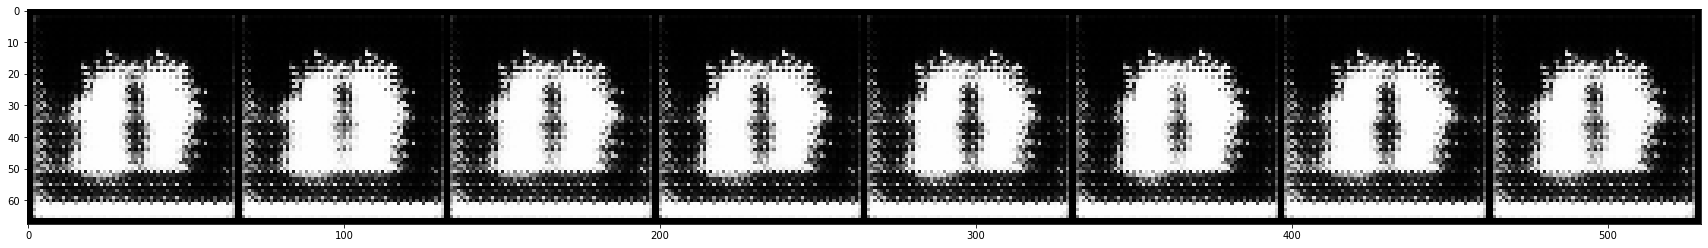

Epoch: 851 | Discriminator Loss - -0.07666736841201782 | Gradient Penalty - 0.3168008327484131 |Generator Loss - -0.41308319568634033]
Epoch: 901 | Discriminator Loss - -0.04439285397529602 | Gradient Penalty - 0.3526790142059326 |Generator Loss - -0.4150617718696594]

Epoch 7
Epoch: 51 | Discriminator Loss - 0.5541030168533325 | Gradient Penalty - 0.6848880648612976 |Generator Loss - -0.8090457916259766]
Epoch: 101 | Discriminator Loss - -0.06419619917869568 | Gradient Penalty - 0.30543607473373413 |Generator Loss - -0.4272085726261139]
Epoch: 151 | Discriminator Loss - -0.08978235721588135 | Gradient Penalty - 0.28533339500427246 |Generator Loss - -0.4284566640853882]
Epoch: 201 | Discriminator Loss - 0.031618982553482056 | Gradient Penalty - 0.42665037512779236 |Generator Loss - -0.4185470640659332]
Epoch: 251 | Discriminator Loss - -0.16797910630702972 | Gradient Penalty - 0.20301513373851776 |Generator Loss - -0.41022974252700806]
Epoch: 301 | Discriminator Loss - -0.0147179961204

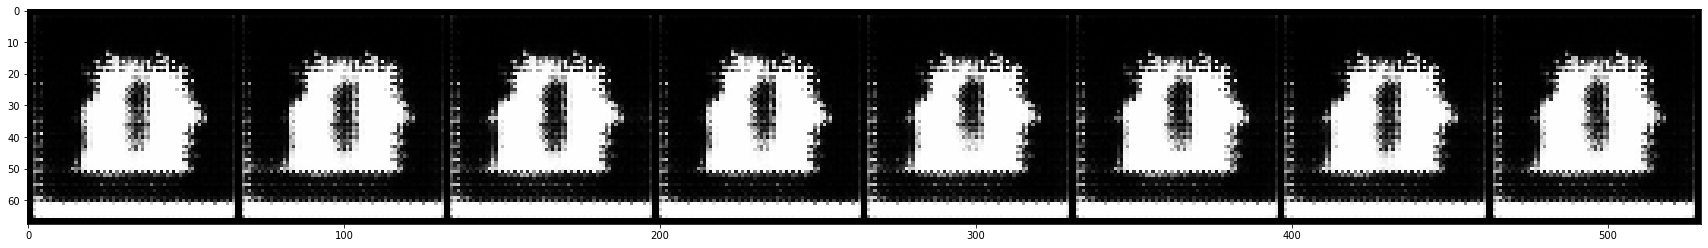

Epoch: 851 | Discriminator Loss - -0.1421460509300232 | Gradient Penalty - 0.2155025601387024 |Generator Loss - -0.4366154670715332]
Epoch: 901 | Discriminator Loss - -0.1680964231491089 | Gradient Penalty - 0.20630300045013428 |Generator Loss - -0.4042477011680603]

Epoch 8
Epoch: 51 | Discriminator Loss - 0.03780221939086914 | Gradient Penalty - 0.33068567514419556 |Generator Loss - -0.4244120717048645]
Epoch: 101 | Discriminator Loss - -0.19591909646987915 | Gradient Penalty - 0.21059828996658325 |Generator Loss - -0.39474570751190186]
Epoch: 151 | Discriminator Loss - -0.11993557214736938 | Gradient Penalty - 0.2909011244773865 |Generator Loss - -0.3975543975830078]
Epoch: 201 | Discriminator Loss - -0.19264084100723267 | Gradient Penalty - 0.1919272541999817 |Generator Loss - -0.4157484769821167]
Epoch: 251 | Discriminator Loss - 0.10481095314025879 | Gradient Penalty - 0.3281949758529663 |Generator Loss - -0.5002721548080444]
Epoch: 301 | Discriminator Loss - -0.05608180165290832

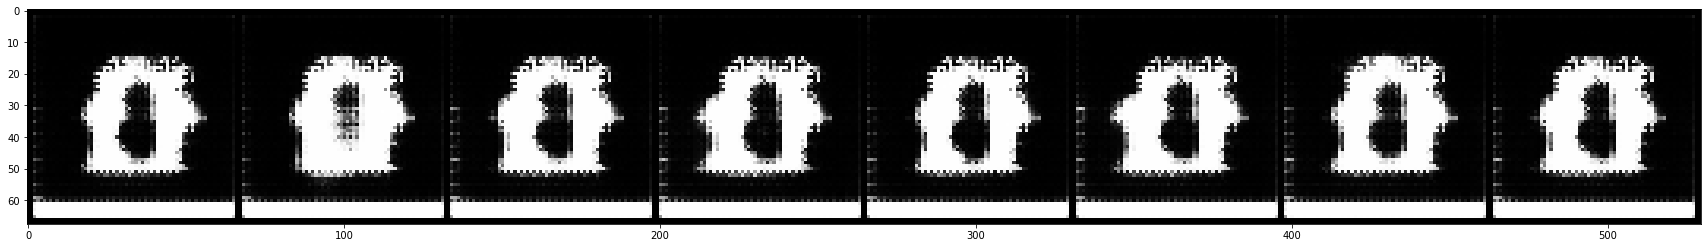

Epoch: 851 | Discriminator Loss - -0.27864378690719604 | Gradient Penalty - 0.1746155023574829 |Generator Loss - -0.3547177314758301]
Epoch: 901 | Discriminator Loss - -0.2388295829296112 | Gradient Penalty - 0.2080744206905365 |Generator Loss - -0.33752018213272095]

Epoch 9
Epoch: 51 | Discriminator Loss - -0.25384342670440674 | Gradient Penalty - 0.2081570029258728 |Generator Loss - -0.3507281541824341]
Epoch: 101 | Discriminator Loss - -0.16291704773902893 | Gradient Penalty - 0.29861393570899963 |Generator Loss - -0.33915776014328003]
Epoch: 151 | Discriminator Loss - -0.14320510625839233 | Gradient Penalty - 0.3031310439109802 |Generator Loss - -0.35288065671920776]
Epoch: 201 | Discriminator Loss - -0.10539442300796509 | Gradient Penalty - 0.35342973470687866 |Generator Loss - -0.3759465217590332]
Epoch: 251 | Discriminator Loss - -0.23184533417224884 | Gradient Penalty - 0.16905270516872406 |Generator Loss - -0.3757357597351074]
Epoch: 301 | Discriminator Loss - -0.199374854564

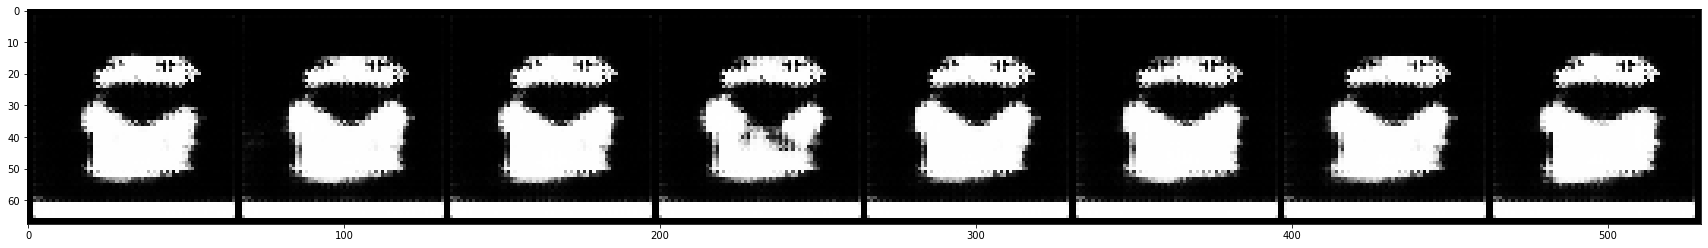

Epoch: 851 | Discriminator Loss - -0.3285316824913025 | Gradient Penalty - 0.14021576941013336 |Generator Loss - -0.34005439281463623]
Epoch: 901 | Discriminator Loss - -0.25015944242477417 | Gradient Penalty - 0.18867480754852295 |Generator Loss - -0.37553471326828003]

Epoch 10
Epoch: 51 | Discriminator Loss - -0.3096249997615814 | Gradient Penalty - 0.20138075947761536 |Generator Loss - -0.345392107963562]
Epoch: 101 | Discriminator Loss - -0.28170639276504517 | Gradient Penalty - 0.22592514753341675 |Generator Loss - -0.30685555934906006]
Epoch: 151 | Discriminator Loss - -0.314044326543808 | Gradient Penalty - 0.20077309012413025 |Generator Loss - -0.31970667839050293]
Epoch: 201 | Discriminator Loss - -0.34895604848861694 | Gradient Penalty - 0.17834633588790894 |Generator Loss - -0.3082999587059021]
Epoch: 251 | Discriminator Loss - -0.37183159589767456 | Gradient Penalty - 0.13138501346111298 |Generator Loss - -0.30711376667022705]
Epoch: 301 | Discriminator Loss - -0.281983882

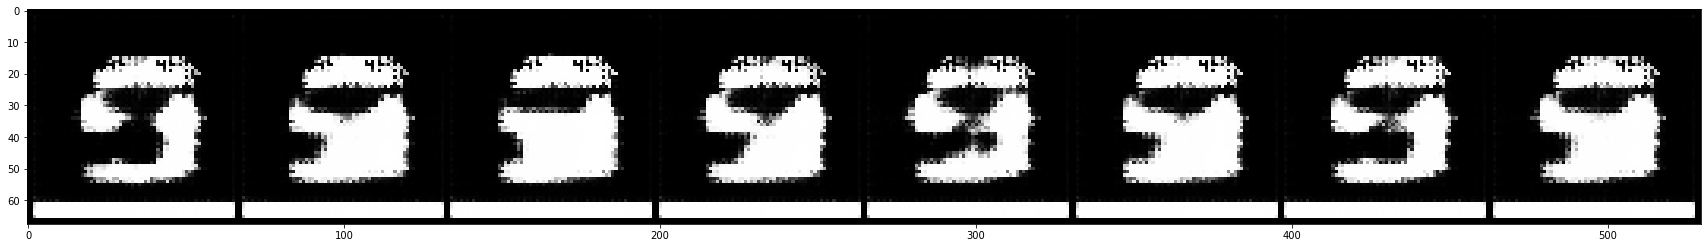

Epoch: 851 | Discriminator Loss - -0.3721025884151459 | Gradient Penalty - 0.19266173243522644 |Generator Loss - -0.3063468933105469]
Epoch: 901 | Discriminator Loss - -0.40570005774497986 | Gradient Penalty - 0.1373547613620758 |Generator Loss - -0.28453129529953003]

Epoch 11
Epoch: 51 | Discriminator Loss - -0.26055803894996643 | Gradient Penalty - 0.29834821820259094 |Generator Loss - -0.31173524260520935]
Epoch: 101 | Discriminator Loss - -0.3108108937740326 | Gradient Penalty - 0.2636179029941559 |Generator Loss - -0.2908652424812317]
Epoch: 151 | Discriminator Loss - -0.4264634847640991 | Gradient Penalty - 0.1428433656692505 |Generator Loss - -0.28287822008132935]
Epoch: 201 | Discriminator Loss - -0.42502856254577637 | Gradient Penalty - 0.14298619329929352 |Generator Loss - -0.2678684592247009]
Epoch: 251 | Discriminator Loss - -0.32815665006637573 | Gradient Penalty - 0.24419091641902924 |Generator Loss - -0.2849164605140686]
Epoch: 301 | Discriminator Loss - -0.370709419250

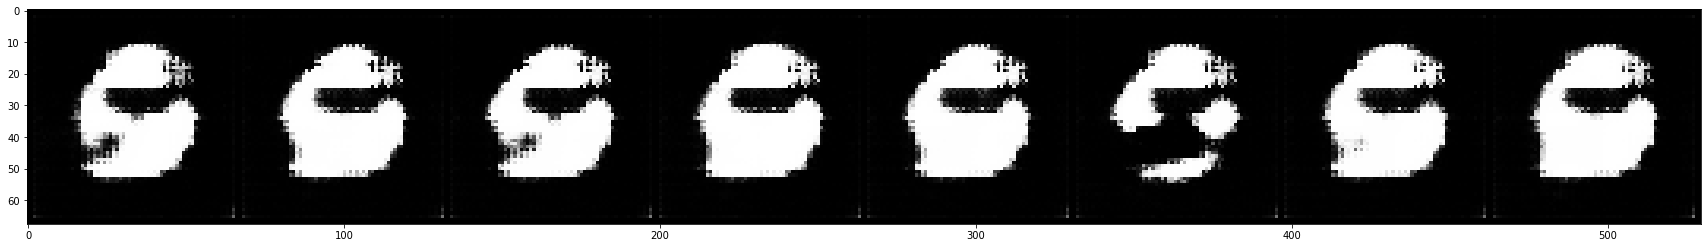

Epoch: 851 | Discriminator Loss - -0.031524837017059326 | Gradient Penalty - 0.1944422423839569 |Generator Loss - -0.47936204075813293]
Epoch: 901 | Discriminator Loss - -0.05370128154754639 | Gradient Penalty - 0.19221231341362 |Generator Loss - -0.4654429256916046]

Epoch 12
Epoch: 51 | Discriminator Loss - -0.10677865147590637 | Gradient Penalty - 0.1376769244670868 |Generator Loss - -0.4277927875518799]
Epoch: 101 | Discriminator Loss - -0.007735133171081543 | Gradient Penalty - 0.25943371653556824 |Generator Loss - -0.42601191997528076]
Epoch: 151 | Discriminator Loss - -0.12462550401687622 | Gradient Penalty - 0.14881786704063416 |Generator Loss - -0.4291793704032898]
Epoch: 201 | Discriminator Loss - -0.14728698134422302 | Gradient Penalty - 0.16947343945503235 |Generator Loss - -0.3503704071044922]
Epoch: 251 | Discriminator Loss - -0.1527530997991562 | Gradient Penalty - 0.17623485624790192 |Generator Loss - -0.3364422917366028]
Epoch: 301 | Discriminator Loss - -0.22691658139

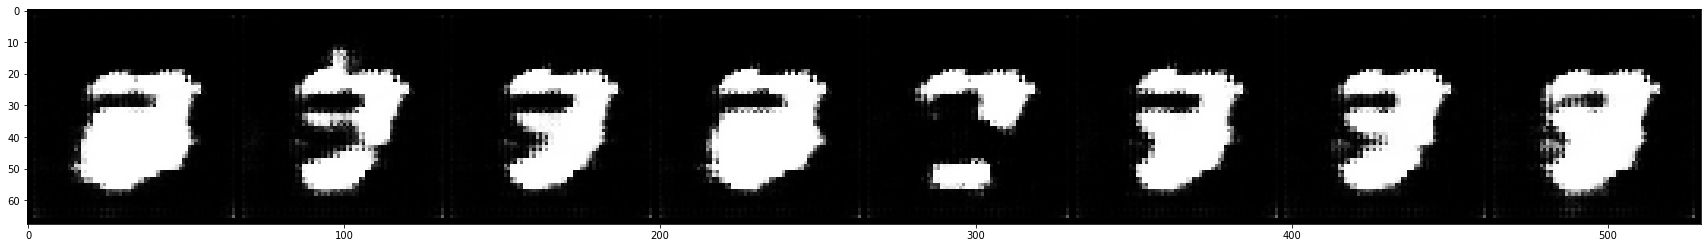

Epoch: 851 | Discriminator Loss - -0.15770429372787476 | Gradient Penalty - 0.08889418095350266 |Generator Loss - -0.4290385842323303]
Epoch: 901 | Discriminator Loss - -0.1789187639951706 | Gradient Penalty - 0.10903321206569672 |Generator Loss - -0.4345722794532776]

Epoch 13
Epoch: 51 | Discriminator Loss - 0.016077682375907898 | Gradient Penalty - 0.15163443982601166 |Generator Loss - -0.4464116096496582]
Epoch: 101 | Discriminator Loss - -0.12847812473773956 | Gradient Penalty - 0.07884936034679413 |Generator Loss - -0.41711848974227905]
Epoch: 151 | Discriminator Loss - -0.17320817708969116 | Gradient Penalty - 0.09694617241621017 |Generator Loss - -0.39179426431655884]
Epoch: 201 | Discriminator Loss - -0.1466928869485855 | Gradient Penalty - 0.17152242362499237 |Generator Loss - -0.3842271566390991]
Epoch: 251 | Discriminator Loss - -0.14769364893436432 | Gradient Penalty - 0.12305359542369843 |Generator Loss - -0.41377395391464233]
Epoch: 301 | Discriminator Loss - -0.09499683

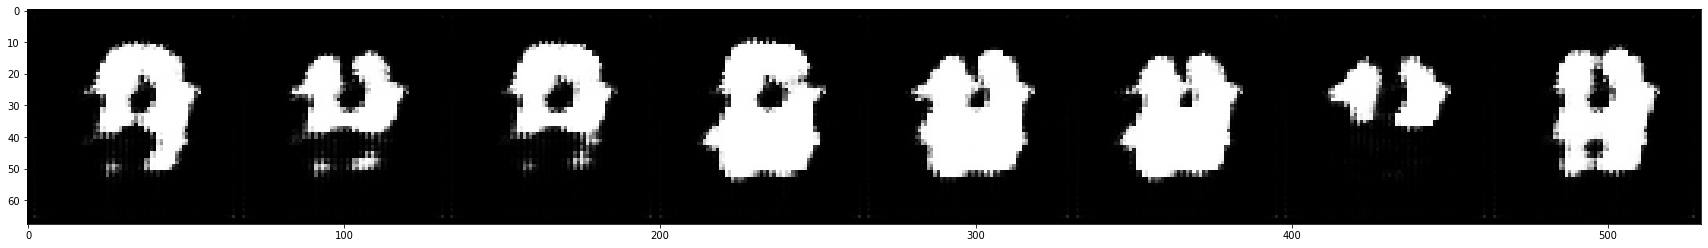

Epoch: 851 | Discriminator Loss - -0.14037662744522095 | Gradient Penalty - 0.16772675514221191 |Generator Loss - -0.38702714443206787]
Epoch: 901 | Discriminator Loss - -0.0796508640050888 | Gradient Penalty - 0.11996252834796906 |Generator Loss - -0.5156406760215759]

Epoch 14
Epoch: 51 | Discriminator Loss - 0.01734570413827896 | Gradient Penalty - 0.06653092056512833 |Generator Loss - -0.5866439342498779]
Epoch: 101 | Discriminator Loss - -0.006511427462100983 | Gradient Penalty - 0.07304122298955917 |Generator Loss - -0.5426926612854004]
Epoch: 151 | Discriminator Loss - -0.08040259778499603 | Gradient Penalty - 0.06899817287921906 |Generator Loss - -0.5085688233375549]
Epoch: 201 | Discriminator Loss - -0.13163398206233978 | Gradient Penalty - 0.1202864795923233 |Generator Loss - -0.4525575339794159]
Epoch: 251 | Discriminator Loss - -0.1636541485786438 | Gradient Penalty - 0.11218929290771484 |Generator Loss - -0.4150923192501068]
Epoch: 301 | Discriminator Loss - -0.07975998520

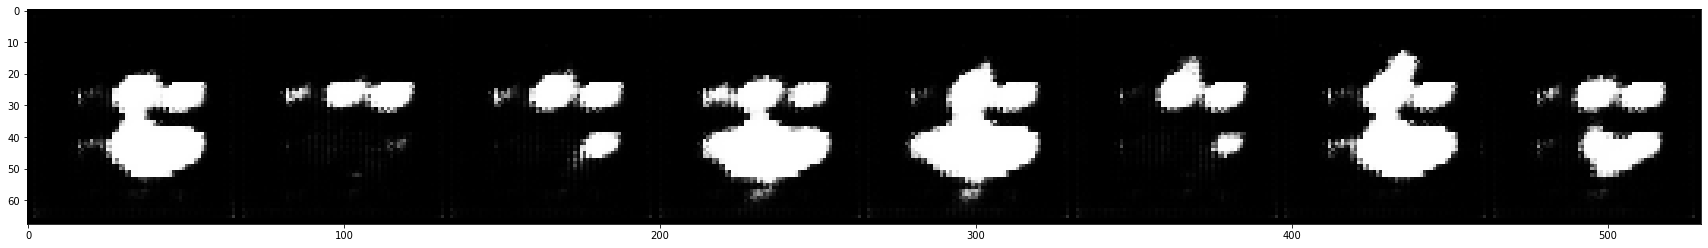

Epoch: 851 | Discriminator Loss - -0.14365792274475098 | Gradient Penalty - 0.07084416598081589 |Generator Loss - -0.4953184127807617]
Epoch: 901 | Discriminator Loss - -0.12255297601222992 | Gradient Penalty - 0.10257764160633087 |Generator Loss - -0.4642448127269745]

Epoch 15
Epoch: 51 | Discriminator Loss - -0.21295294165611267 | Gradient Penalty - 0.0687340497970581 |Generator Loss - -0.3847551643848419]
Epoch: 101 | Discriminator Loss - -0.11726251244544983 | Gradient Penalty - 0.0900898277759552 |Generator Loss - -0.44162702560424805]
Epoch: 151 | Discriminator Loss - -0.018962174654006958 | Gradient Penalty - 0.09486955404281616 |Generator Loss - -0.4122888743877411]
Epoch: 201 | Discriminator Loss - -0.05827057361602783 | Gradient Penalty - 0.049483299255371094 |Generator Loss - -0.5261889696121216]
Epoch: 251 | Discriminator Loss - -0.01907285302877426 | Gradient Penalty - 0.12051329761743546 |Generator Loss - -0.5312576293945312]
Epoch: 301 | Discriminator Loss - -0.09947225

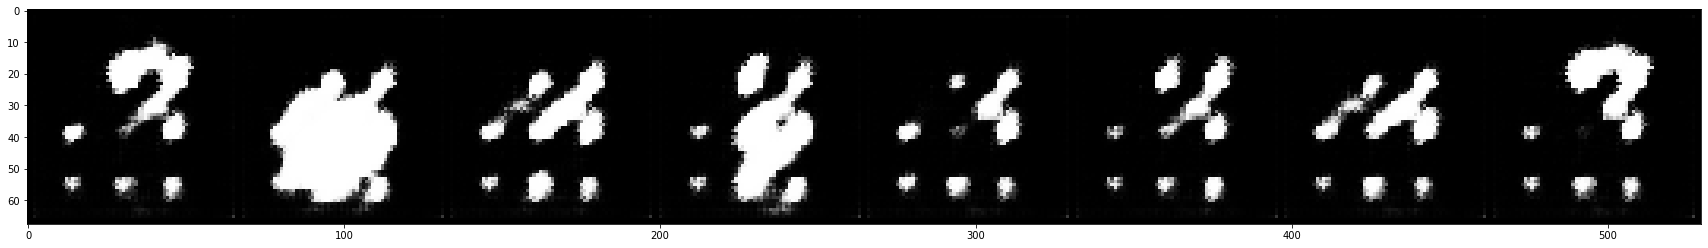

Epoch: 851 | Discriminator Loss - -0.027027472853660583 | Gradient Penalty - 0.13629408180713654 |Generator Loss - -0.5996706485748291]
Epoch: 901 | Discriminator Loss - -0.02975814789533615 | Gradient Penalty - 0.12309569865465164 |Generator Loss - -0.5887516140937805]

Epoch 16
Epoch: 51 | Discriminator Loss - -0.05032864958047867 | Gradient Penalty - 0.09434708207845688 |Generator Loss - -0.5120441913604736]
Epoch: 101 | Discriminator Loss - -0.041506603360176086 | Gradient Penalty - 0.10496778786182404 |Generator Loss - -0.4973159432411194]
Epoch: 151 | Discriminator Loss - -0.02789776772260666 | Gradient Penalty - 0.10367829352617264 |Generator Loss - -0.5212664008140564]
Epoch: 201 | Discriminator Loss - -0.003550127148628235 | Gradient Penalty - 0.13290636241436005 |Generator Loss - -0.5344516038894653]
Epoch: 251 | Discriminator Loss - 0.002854675054550171 | Gradient Penalty - 0.12158772349357605 |Generator Loss - -0.6131510734558105]
Epoch: 301 | Discriminator Loss - -0.030262

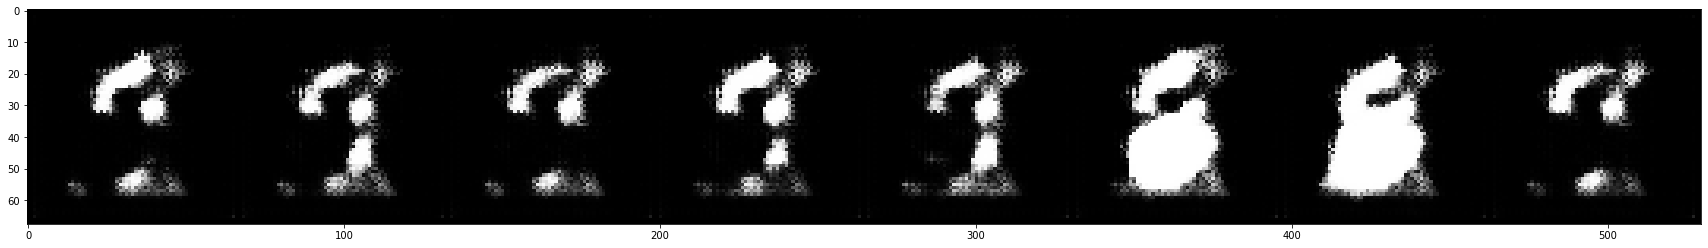

Epoch: 851 | Discriminator Loss - -0.07611337304115295 | Gradient Penalty - 0.07821640372276306 |Generator Loss - -0.5088597536087036]
Epoch: 901 | Discriminator Loss - -0.0676669329404831 | Gradient Penalty - 0.09420140087604523 |Generator Loss - -0.5294389128684998]

Epoch 17
Epoch: 51 | Discriminator Loss - 0.007028058171272278 | Gradient Penalty - 0.15623541176319122 |Generator Loss - -0.537969708442688]
Epoch: 101 | Discriminator Loss - -0.08197985589504242 | Gradient Penalty - 0.07350791990756989 |Generator Loss - -0.5036203861236572]
Epoch: 151 | Discriminator Loss - -0.107656329870224 | Gradient Penalty - 0.041597988456487656 |Generator Loss - -0.5238044261932373]
Epoch: 201 | Discriminator Loss - -0.03931815177202225 | Gradient Penalty - 0.12077554315328598 |Generator Loss - -0.5337305068969727]
Epoch: 251 | Discriminator Loss - -0.0651114359498024 | Gradient Penalty - 0.07014467567205429 |Generator Loss - -0.5535191297531128]
Epoch: 301 | Discriminator Loss - 0.05039152503013

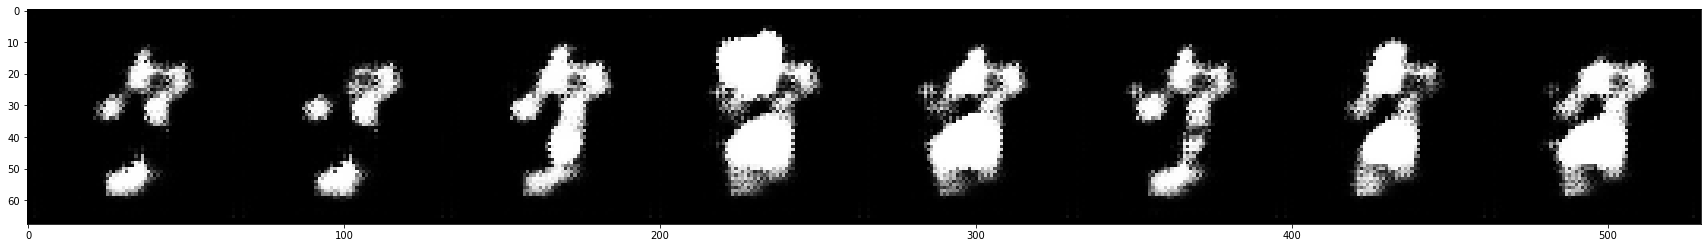

Epoch: 851 | Discriminator Loss - -0.03387945890426636 | Gradient Penalty - 0.13859745860099792 |Generator Loss - -0.4838855266571045]
Epoch: 901 | Discriminator Loss - -0.05753259360790253 | Gradient Penalty - 0.12101711332798004 |Generator Loss - -0.49557191133499146]

Epoch 18
Epoch: 51 | Discriminator Loss - -0.10048762708902359 | Gradient Penalty - 0.07610037177801132 |Generator Loss - -0.46878087520599365]
Epoch: 101 | Discriminator Loss - -0.14453862607479095 | Gradient Penalty - 0.0813446193933487 |Generator Loss - -0.384732723236084]
Epoch: 151 | Discriminator Loss - -0.13166169822216034 | Gradient Penalty - 0.06720085442066193 |Generator Loss - -0.40915364027023315]
Epoch: 201 | Discriminator Loss - 0.10856819152832031 | Gradient Penalty - 0.2817079424858093 |Generator Loss - -0.6304788589477539]
Epoch: 251 | Discriminator Loss - -0.05564802885055542 | Gradient Penalty - 0.19248011708259583 |Generator Loss - -0.4903487265110016]
Epoch: 301 | Discriminator Loss - -0.0045399665

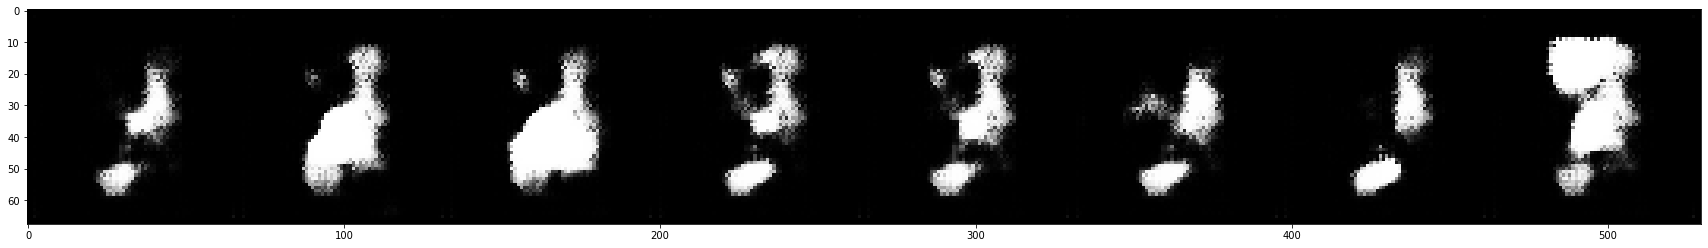

Epoch: 851 | Discriminator Loss - -0.14492905139923096 | Gradient Penalty - 0.08688870817422867 |Generator Loss - -0.35579854249954224]
Epoch: 901 | Discriminator Loss - -0.16289392113685608 | Gradient Penalty - 0.07149883359670639 |Generator Loss - -0.33321475982666016]

Epoch 19
Epoch: 51 | Discriminator Loss - -0.05160254240036011 | Gradient Penalty - 0.10787326097488403 |Generator Loss - -0.5826107859611511]
Epoch: 101 | Discriminator Loss - -0.054705262184143066 | Gradient Penalty - 0.11286163330078125 |Generator Loss - -0.5350379943847656]
Epoch: 151 | Discriminator Loss - -0.10737054795026779 | Gradient Penalty - 0.05277342349290848 |Generator Loss - -0.547277569770813]
Epoch: 201 | Discriminator Loss - -0.06423351913690567 | Gradient Penalty - 0.11011972278356552 |Generator Loss - -0.47412413358688354]
Epoch: 251 | Discriminator Loss - -0.04941830039024353 | Gradient Penalty - 0.11956033110618591 |Generator Loss - -0.4142163097858429]
Epoch: 301 | Discriminator Loss - -0.071418

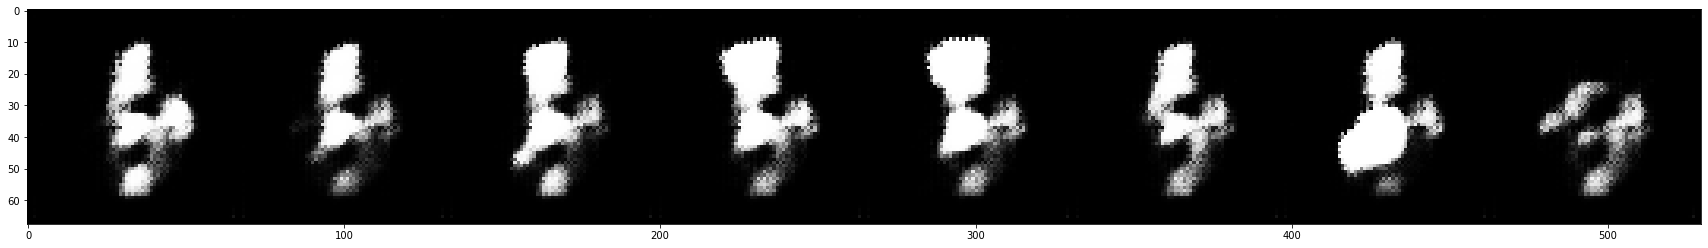

Epoch: 851 | Discriminator Loss - -0.16681811213493347 | Gradient Penalty - 0.11041870713233948 |Generator Loss - -0.33585405349731445]
Epoch: 901 | Discriminator Loss - -0.18817812204360962 | Gradient Penalty - 0.06173890084028244 |Generator Loss - -0.3529942035675049]

Epoch 20
Epoch: 51 | Discriminator Loss - -0.10506166517734528 | Gradient Penalty - 0.08636759221553802 |Generator Loss - -0.40659818053245544]
Epoch: 101 | Discriminator Loss - -0.07299403101205826 | Gradient Penalty - 0.06451364606618881 |Generator Loss - -0.4379437565803528]
Epoch: 151 | Discriminator Loss - -0.04735943675041199 | Gradient Penalty - 0.11521825194358826 |Generator Loss - -0.3879707455635071]
Epoch: 201 | Discriminator Loss - -0.08139868825674057 | Gradient Penalty - 0.11051080375909805 |Generator Loss - -0.4099422097206116]
Epoch: 251 | Discriminator Loss - -0.051280319690704346 | Gradient Penalty - 0.17298203706741333 |Generator Loss - -0.4186152219772339]
Epoch: 301 | Discriminator Loss - -0.170626

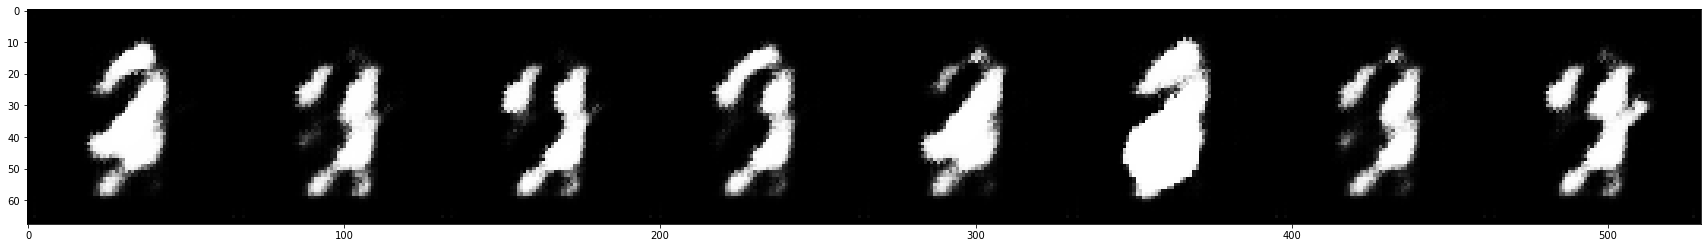

Epoch: 851 | Discriminator Loss - -0.12365487217903137 | Gradient Penalty - 0.07528120279312134 |Generator Loss - -0.3912714719772339]
Epoch: 901 | Discriminator Loss - -0.1819688081741333 | Gradient Penalty - 0.07216465473175049 |Generator Loss - -0.34056615829467773]

Epoch 21
Epoch: 51 | Discriminator Loss - -0.22669824957847595 | Gradient Penalty - 0.1114058867096901 |Generator Loss - -0.4111964702606201]
Epoch: 101 | Discriminator Loss - -0.24045976996421814 | Gradient Penalty - 0.049546562135219574 |Generator Loss - -0.423895001411438]
Epoch: 151 | Discriminator Loss - -0.12678459286689758 | Gradient Penalty - 0.11842116713523865 |Generator Loss - -0.48566097021102905]
Epoch: 201 | Discriminator Loss - -0.09738645702600479 | Gradient Penalty - 0.08926286548376083 |Generator Loss - -0.34528252482414246]
Epoch: 251 | Discriminator Loss - -0.09372749924659729 | Gradient Penalty - 0.11912864446640015 |Generator Loss - -0.32916611433029175]
Epoch: 301 | Discriminator Loss - -0.1246861

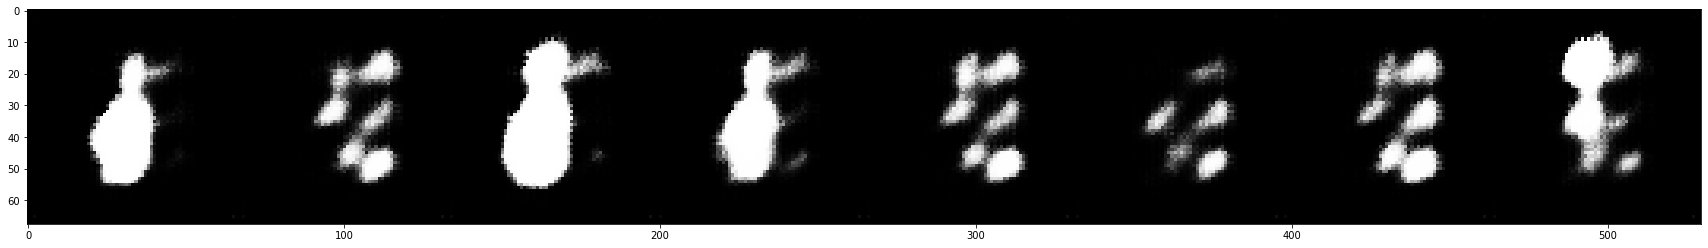

Epoch: 851 | Discriminator Loss - -0.2374211698770523 | Gradient Penalty - 0.04718534275889397 |Generator Loss - -0.33269888162612915]
Epoch: 901 | Discriminator Loss - -0.13659533858299255 | Gradient Penalty - 0.10699149966239929 |Generator Loss - -0.377311110496521]

Epoch 22
Epoch: 51 | Discriminator Loss - -0.06044553220272064 | Gradient Penalty - 0.10654546320438385 |Generator Loss - -0.4225098788738251]
Epoch: 101 | Discriminator Loss - -0.10078088939189911 | Gradient Penalty - 0.06888650357723236 |Generator Loss - -0.4448491632938385]
Epoch: 151 | Discriminator Loss - -0.08287116140127182 | Gradient Penalty - 0.07701209932565689 |Generator Loss - -0.48574531078338623]
Epoch: 201 | Discriminator Loss - -0.09580381959676743 | Gradient Penalty - 0.0952858105301857 |Generator Loss - -0.46275973320007324]
Epoch: 251 | Discriminator Loss - -0.16750897467136383 | Gradient Penalty - 0.050364900380373 |Generator Loss - -0.4417378306388855]
Epoch: 301 | Discriminator Loss - -0.17986020445

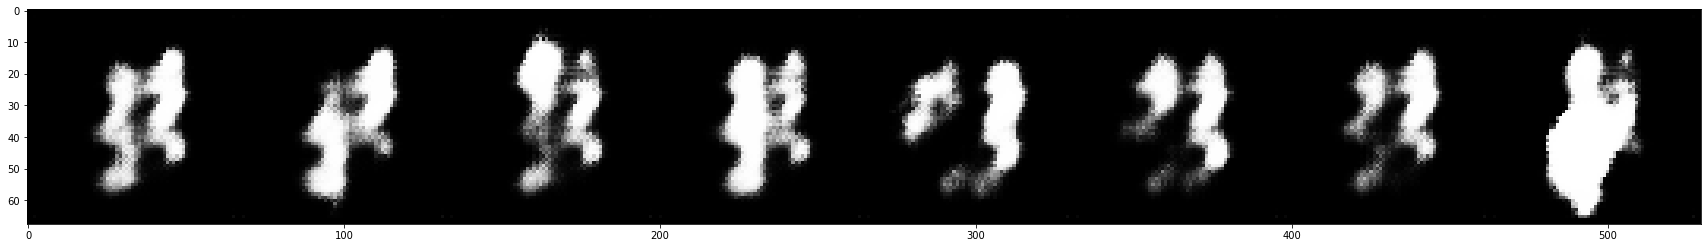

Epoch: 851 | Discriminator Loss - -0.13034364581108093 | Gradient Penalty - 0.10132530331611633 |Generator Loss - -0.467659592628479]
Epoch: 901 | Discriminator Loss - -0.15751361846923828 | Gradient Penalty - 0.05212342366576195 |Generator Loss - -0.37788647413253784]

Epoch 23
Epoch: 51 | Discriminator Loss - -0.09458120167255402 | Gradient Penalty - 0.09146486222743988 |Generator Loss - -0.48555564880371094]
Epoch: 101 | Discriminator Loss - -0.19182485342025757 | Gradient Penalty - 0.02814842015504837 |Generator Loss - -0.41012856364250183]
Epoch: 151 | Discriminator Loss - -0.2479112148284912 | Gradient Penalty - 0.054861001670360565 |Generator Loss - -0.4064891040325165]
Epoch: 201 | Discriminator Loss - -0.22683516144752502 | Gradient Penalty - 0.048257745802402496 |Generator Loss - -0.4184982180595398]
Epoch: 251 | Discriminator Loss - -0.1854294240474701 | Gradient Penalty - 0.07124543935060501 |Generator Loss - -0.29976046085357666]
Epoch: 301 | Discriminator Loss - -0.187780

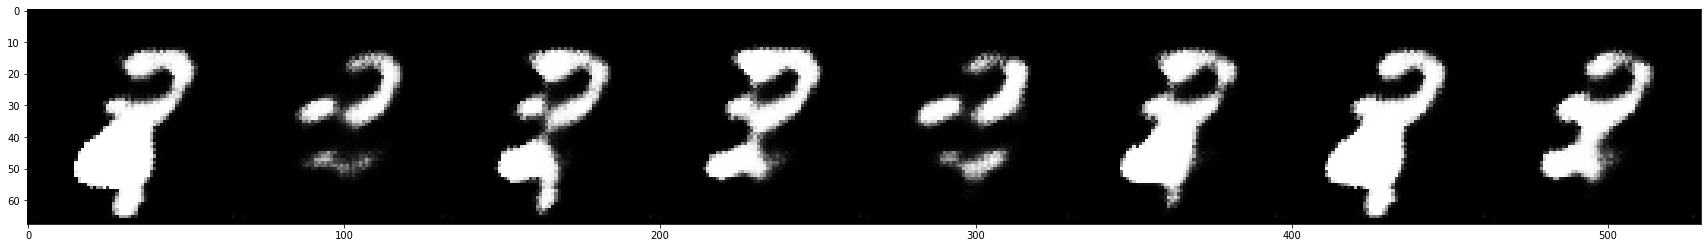

Epoch: 851 | Discriminator Loss - -0.13999073207378387 | Gradient Penalty - 0.05002487823367119 |Generator Loss - -0.42031580209732056]
Epoch: 901 | Discriminator Loss - -0.16922622919082642 | Gradient Penalty - 0.08318155258893967 |Generator Loss - -0.43889546394348145]

Epoch 24
Epoch: 51 | Discriminator Loss - -0.11120970547199249 | Gradient Penalty - 0.12192092835903168 |Generator Loss - -0.3801119923591614]
Epoch: 101 | Discriminator Loss - -0.17295750975608826 | Gradient Penalty - 0.04888371378183365 |Generator Loss - -0.41190868616104126]
Epoch: 151 | Discriminator Loss - -0.17557980120182037 | Gradient Penalty - 0.061103273183107376 |Generator Loss - -0.42452988028526306]
Epoch: 201 | Discriminator Loss - -0.17059701681137085 | Gradient Penalty - 0.04923722892999649 |Generator Loss - -0.4417722821235657]
Epoch: 251 | Discriminator Loss - -0.19383887946605682 | Gradient Penalty - 0.03994201123714447 |Generator Loss - -0.43542778491973877]
Epoch: 301 | Discriminator Loss - -0.120

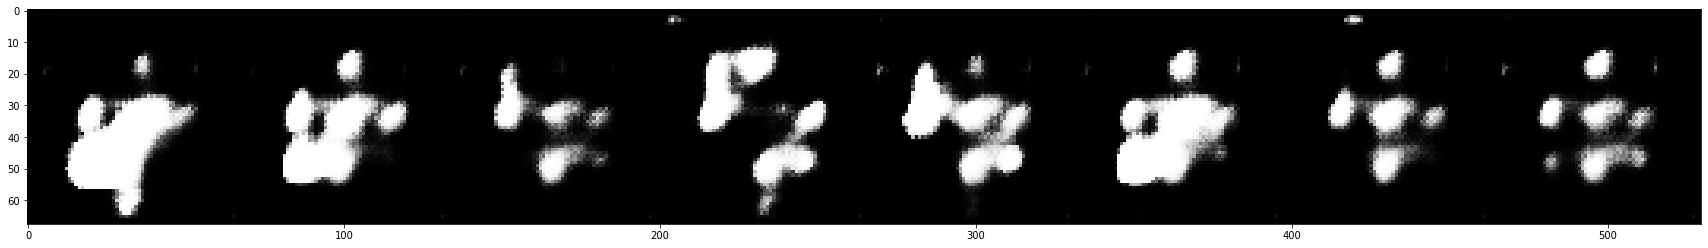

Epoch: 851 | Discriminator Loss - -0.1911296397447586 | Gradient Penalty - 0.07660968601703644 |Generator Loss - -0.3955608606338501]
Epoch: 901 | Discriminator Loss - -0.18398049473762512 | Gradient Penalty - 0.05209901183843613 |Generator Loss - -0.42606061697006226]

Epoch 25
Epoch: 51 | Discriminator Loss - -0.1060168519616127 | Gradient Penalty - 0.10203253477811813 |Generator Loss - -0.3548293709754944]
Epoch: 101 | Discriminator Loss - -0.12835930287837982 | Gradient Penalty - 0.06702055037021637 |Generator Loss - -0.4552772641181946]
Epoch: 151 | Discriminator Loss - -0.16263729333877563 | Gradient Penalty - 0.06205308437347412 |Generator Loss - -0.4190557599067688]
Epoch: 201 | Discriminator Loss - -0.1863723248243332 | Gradient Penalty - 0.03992332145571709 |Generator Loss - -0.37984803318977356]
Epoch: 251 | Discriminator Loss - -0.10878749191761017 | Gradient Penalty - 0.10326890647411346 |Generator Loss - -0.4401514530181885]
Epoch: 301 | Discriminator Loss - -0.1507235467

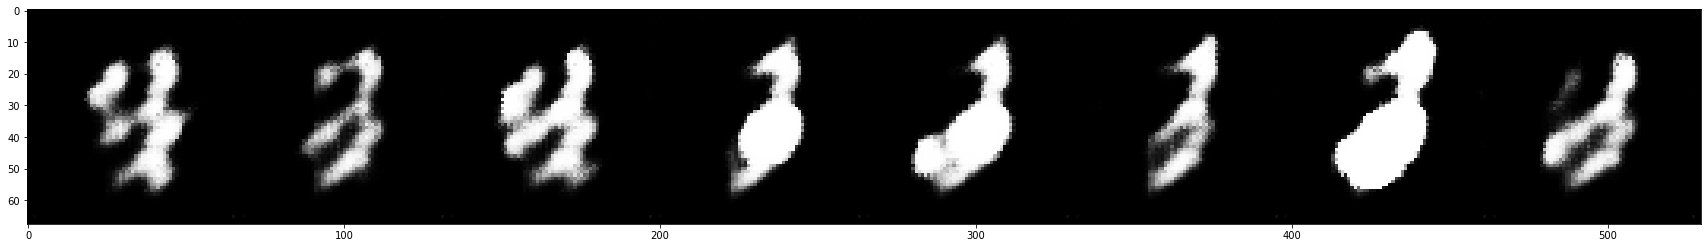

Epoch: 851 | Discriminator Loss - -0.18130868673324585 | Gradient Penalty - 0.053722091019153595 |Generator Loss - -0.41533637046813965]
Epoch: 901 | Discriminator Loss - -0.1710638701915741 | Gradient Penalty - 0.035750798881053925 |Generator Loss - -0.46268782019615173]

Epoch 26
Epoch: 51 | Discriminator Loss - -0.10833939909934998 | Gradient Penalty - 0.0999312698841095 |Generator Loss - -0.4031432867050171]
Epoch: 101 | Discriminator Loss - -0.16530194878578186 | Gradient Penalty - 0.04228711128234863 |Generator Loss - -0.4179496765136719]
Epoch: 151 | Discriminator Loss - -0.08437959849834442 | Gradient Penalty - 0.11824078857898712 |Generator Loss - -0.5128282308578491]
Epoch: 201 | Discriminator Loss - -0.10954597592353821 | Gradient Penalty - 0.11033490300178528 |Generator Loss - -0.4115575850009918]
Epoch: 251 | Discriminator Loss - -0.17353101074695587 | Gradient Penalty - 0.03557734563946724 |Generator Loss - -0.42192214727401733]
Epoch: 301 | Discriminator Loss - -0.121657

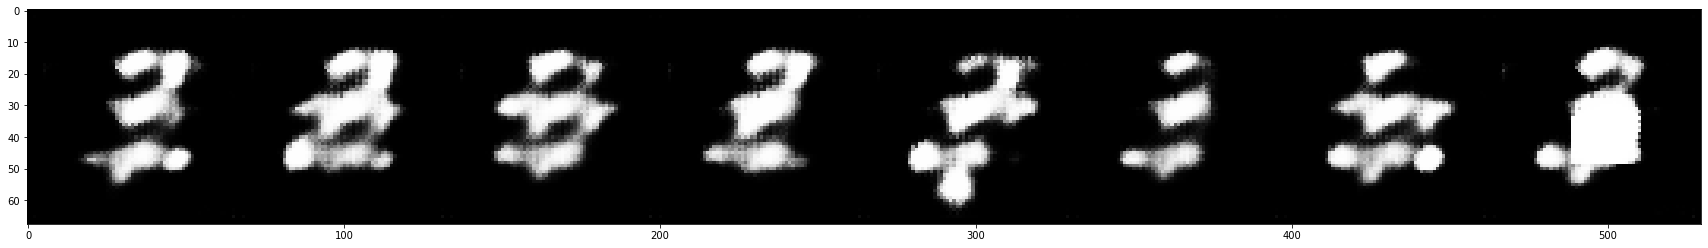

Epoch: 851 | Discriminator Loss - -0.15227660536766052 | Gradient Penalty - 0.07337702065706253 |Generator Loss - -0.426636278629303]
Epoch: 901 | Discriminator Loss - -0.08070627599954605 | Gradient Penalty - 0.09291239827871323 |Generator Loss - -0.4837646484375]

Epoch 27
Epoch: 51 | Discriminator Loss - -0.10741069912910461 | Gradient Penalty - 0.11488276720046997 |Generator Loss - -0.43324196338653564]
Epoch: 101 | Discriminator Loss - -0.17454659938812256 | Gradient Penalty - 0.06721875816583633 |Generator Loss - -0.4166440963745117]
Epoch: 151 | Discriminator Loss - -0.11417531967163086 | Gradient Penalty - 0.10338714718818665 |Generator Loss - -0.43162351846694946]
Epoch: 201 | Discriminator Loss - -0.18438903987407684 | Gradient Penalty - 0.04571549966931343 |Generator Loss - -0.4440110921859741]
Epoch: 251 | Discriminator Loss - -0.14805911481380463 | Gradient Penalty - 0.0611729733645916 |Generator Loss - -0.44179362058639526]
Epoch: 301 | Discriminator Loss - -0.12960198521

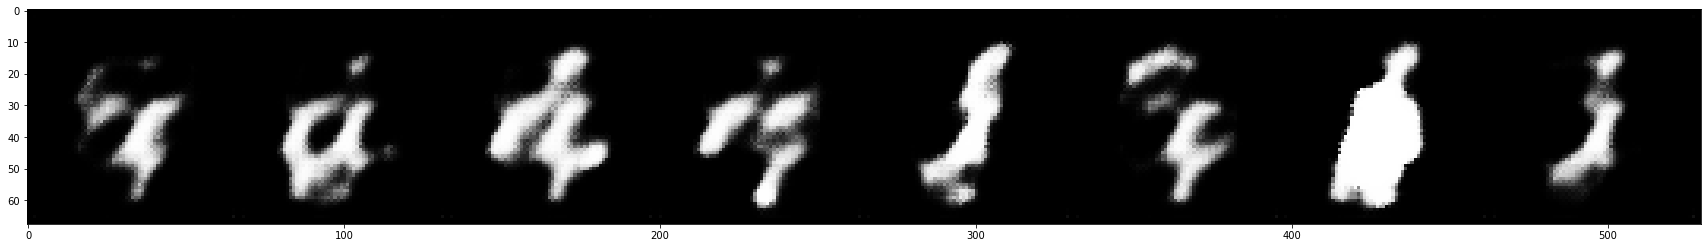

Epoch: 851 | Discriminator Loss - -0.12928707897663116 | Gradient Penalty - 0.06831894814968109 |Generator Loss - -0.3933411240577698]
Epoch: 901 | Discriminator Loss - -0.05909563601016998 | Gradient Penalty - 0.12625978887081146 |Generator Loss - -0.5155729055404663]

Epoch 28
Epoch: 51 | Discriminator Loss - -0.15031231939792633 | Gradient Penalty - 0.10899393260478973 |Generator Loss - -0.4364326000213623]
Epoch: 101 | Discriminator Loss - -0.117865651845932 | Gradient Penalty - 0.10864320397377014 |Generator Loss - -0.4442824423313141]
Epoch: 151 | Discriminator Loss - -0.15232814848423004 | Gradient Penalty - 0.05859328433871269 |Generator Loss - -0.4882296323776245]
Epoch: 201 | Discriminator Loss - -0.112916961312294 | Gradient Penalty - 0.03624992072582245 |Generator Loss - -0.48244646191596985]
Epoch: 251 | Discriminator Loss - -0.11057659238576889 | Gradient Penalty - 0.042202211916446686 |Generator Loss - -0.45306599140167236]
Epoch: 301 | Discriminator Loss - -0.1337159872

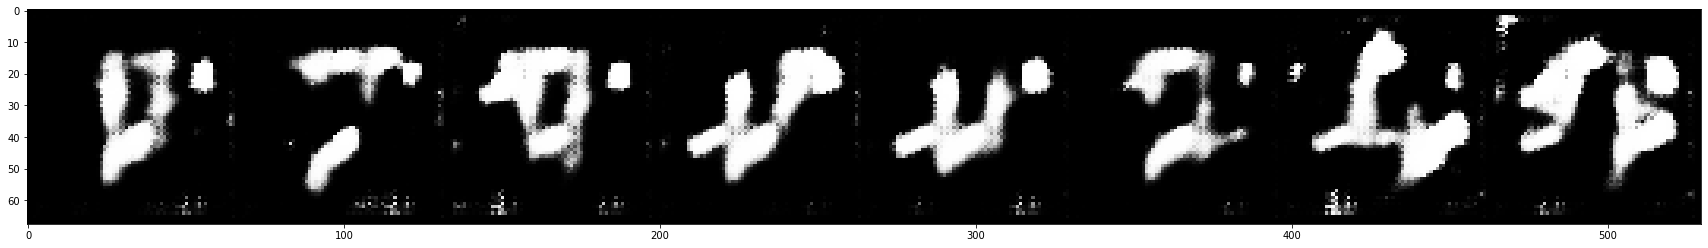

Epoch: 851 | Discriminator Loss - -0.1448281705379486 | Gradient Penalty - 0.055098265409469604 |Generator Loss - -0.48149916529655457]
Epoch: 901 | Discriminator Loss - -0.13078536093235016 | Gradient Penalty - 0.11620520055294037 |Generator Loss - -0.41767361760139465]

Epoch 29
Epoch: 51 | Discriminator Loss - -0.1570671796798706 | Gradient Penalty - 0.11969095468521118 |Generator Loss - -0.38660234212875366]
Epoch: 101 | Discriminator Loss - -0.18636098504066467 | Gradient Penalty - 0.11667099595069885 |Generator Loss - -0.42999735474586487]
Epoch: 151 | Discriminator Loss - -0.11556021869182587 | Gradient Penalty - 0.0767931193113327 |Generator Loss - -0.44229209423065186]
Epoch: 201 | Discriminator Loss - -0.19404307007789612 | Gradient Penalty - 0.04287252202630043 |Generator Loss - -0.4647919535636902]
Epoch: 251 | Discriminator Loss - -0.19059203565120697 | Gradient Penalty - 0.06781668961048126 |Generator Loss - -0.34961843490600586]
Epoch: 301 | Discriminator Loss - -0.17362

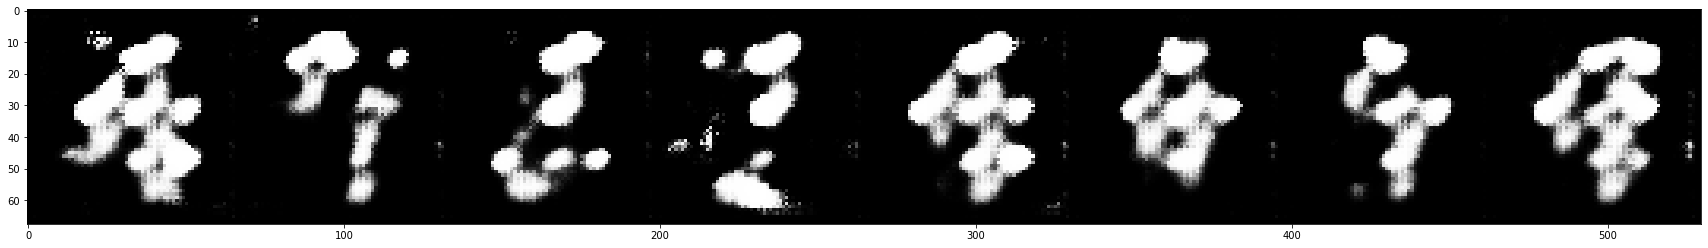

Epoch: 851 | Discriminator Loss - -0.07553639262914658 | Gradient Penalty - 0.0997341051697731 |Generator Loss - -0.4401094913482666]
Epoch: 901 | Discriminator Loss - -0.10152719914913177 | Gradient Penalty - 0.13050304353237152 |Generator Loss - -0.37432631850242615]

Epoch 30
Epoch: 51 | Discriminator Loss - -0.0780535340309143 | Gradient Penalty - 0.0903359055519104 |Generator Loss - -0.5190306901931763]
Epoch: 101 | Discriminator Loss - -0.10253636538982391 | Gradient Penalty - 0.0282072015106678 |Generator Loss - -0.5221239924430847]
Epoch: 151 | Discriminator Loss - -0.06721626222133636 | Gradient Penalty - 0.06477721035480499 |Generator Loss - -0.5065880417823792]
Epoch: 201 | Discriminator Loss - -0.14903947710990906 | Gradient Penalty - 0.04605952277779579 |Generator Loss - -0.48543697595596313]
Epoch: 251 | Discriminator Loss - -0.18777725100517273 | Gradient Penalty - 0.04883471876382828 |Generator Loss - -0.41145265102386475]
Epoch: 301 | Discriminator Loss - -0.1976624280

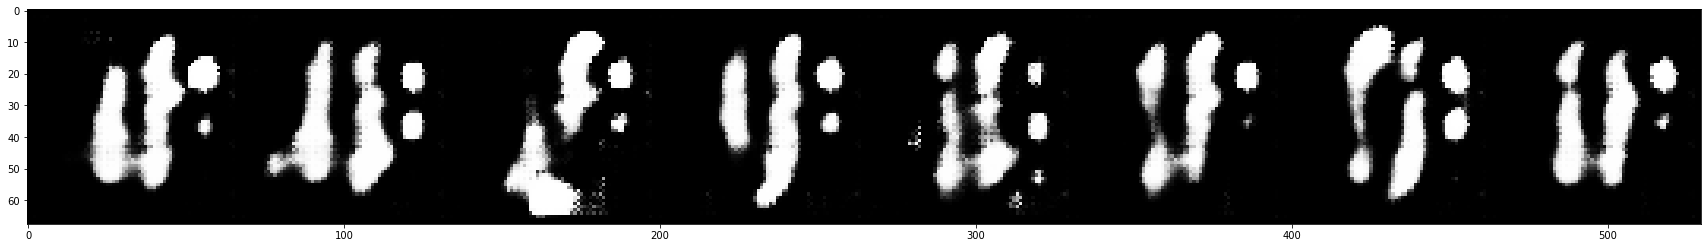

Epoch: 851 | Discriminator Loss - -0.2096792459487915 | Gradient Penalty - 0.042676717042922974 |Generator Loss - -0.38064220547676086]
Epoch: 901 | Discriminator Loss - -0.13343699276447296 | Gradient Penalty - 0.04973151162266731 |Generator Loss - -0.4890117645263672]

Epoch 31
Epoch: 51 | Discriminator Loss - -0.11945780366659164 | Gradient Penalty - 0.02918342500925064 |Generator Loss - -0.48078659176826477]
Epoch: 101 | Discriminator Loss - -0.11182644218206406 | Gradient Penalty - 0.09763125330209732 |Generator Loss - -0.4120365381240845]
Epoch: 151 | Discriminator Loss - -0.134441077709198 | Gradient Penalty - 0.0637509897351265 |Generator Loss - -0.478790283203125]
Epoch: 201 | Discriminator Loss - -0.12262122333049774 | Gradient Penalty - 0.031297340989112854 |Generator Loss - -0.5293603539466858]
Epoch: 251 | Discriminator Loss - -0.13164648413658142 | Gradient Penalty - 0.024159107357263565 |Generator Loss - -0.5084338784217834]
Epoch: 301 | Discriminator Loss - -0.111206628

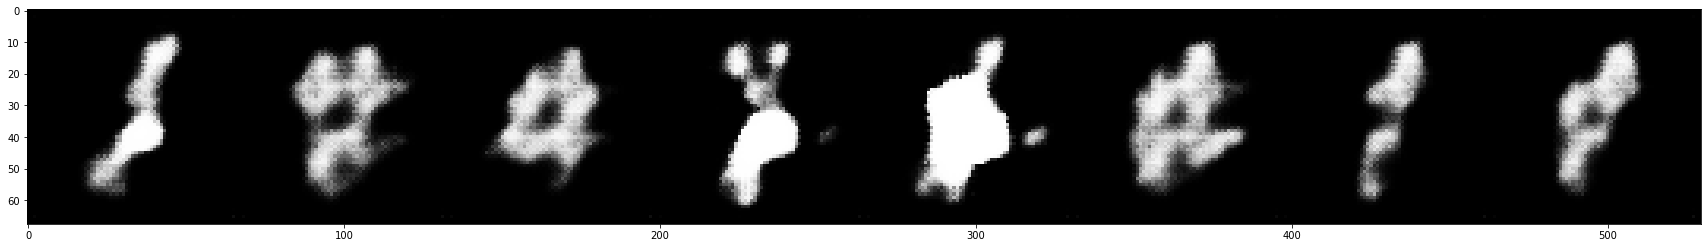

Epoch: 851 | Discriminator Loss - -0.16737255454063416 | Gradient Penalty - 0.0457058884203434 |Generator Loss - -0.4191756248474121]
Epoch: 901 | Discriminator Loss - -0.20131853222846985 | Gradient Penalty - 0.05434224754571915 |Generator Loss - -0.3755100965499878]

Epoch 32
Epoch: 51 | Discriminator Loss - -0.20476257801055908 | Gradient Penalty - 0.03931450843811035 |Generator Loss - -0.4262658655643463]
Epoch: 101 | Discriminator Loss - -0.14465129375457764 | Gradient Penalty - 0.06761693954467773 |Generator Loss - -0.40178412199020386]
Epoch: 151 | Discriminator Loss - -0.15038177371025085 | Gradient Penalty - 0.034735944122076035 |Generator Loss - -0.44200217723846436]
Epoch: 201 | Discriminator Loss - -0.23002025485038757 | Gradient Penalty - 0.026170818135142326 |Generator Loss - -0.39291611313819885]
Epoch: 251 | Discriminator Loss - -0.2392195165157318 | Gradient Penalty - 0.0393156036734581 |Generator Loss - -0.3677457571029663]
Epoch: 301 | Discriminator Loss - -0.1607907

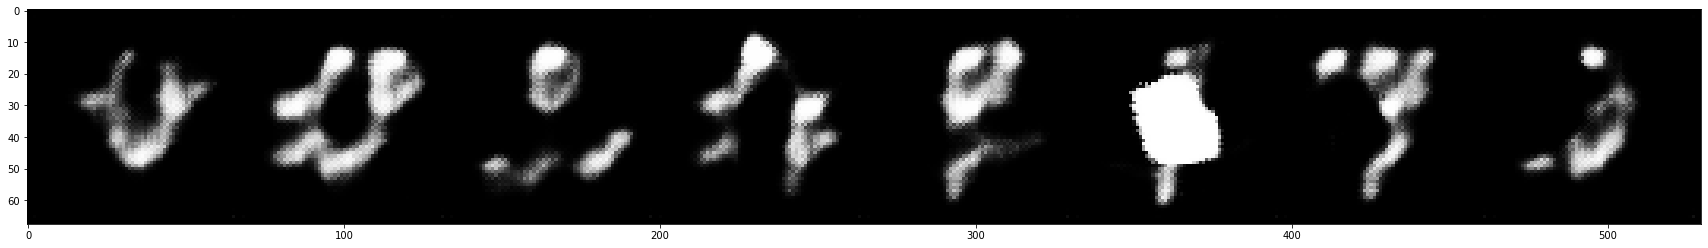

Epoch: 851 | Discriminator Loss - -0.14208278059959412 | Gradient Penalty - 0.054496198892593384 |Generator Loss - -0.49647557735443115]
Epoch: 901 | Discriminator Loss - -0.14446918666362762 | Gradient Penalty - 0.06371273100376129 |Generator Loss - -0.4625311493873596]

Epoch 33
Epoch: 51 | Discriminator Loss - -0.14460015296936035 | Gradient Penalty - 0.03706442937254906 |Generator Loss - -0.45226043462753296]
Epoch: 101 | Discriminator Loss - -0.16462364792823792 | Gradient Penalty - 0.06932982057332993 |Generator Loss - -0.4395827054977417]
Epoch: 151 | Discriminator Loss - -0.13809888064861298 | Gradient Penalty - 0.09105093777179718 |Generator Loss - -0.45992353558540344]
Epoch: 201 | Discriminator Loss - -0.1384003758430481 | Gradient Penalty - 0.05080461502075195 |Generator Loss - -0.4604783356189728]
Epoch: 251 | Discriminator Loss - -0.12959614396095276 | Gradient Penalty - 0.022265112027525902 |Generator Loss - -0.48665910959243774]
Epoch: 301 | Discriminator Loss - -0.1145

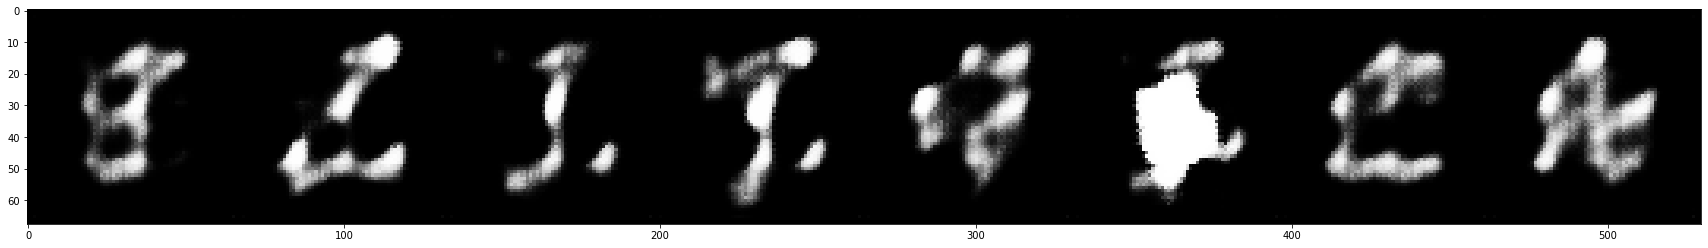

Epoch: 851 | Discriminator Loss - -0.16444703936576843 | Gradient Penalty - 0.03488805890083313 |Generator Loss - -0.46339619159698486]
Epoch: 901 | Discriminator Loss - -0.11473815888166428 | Gradient Penalty - 0.06326860934495926 |Generator Loss - -0.4858678877353668]

Epoch 34
Epoch: 51 | Discriminator Loss - -0.11053816974163055 | Gradient Penalty - 0.03627149388194084 |Generator Loss - -0.46184074878692627]
Epoch: 101 | Discriminator Loss - -0.12305593490600586 | Gradient Penalty - 0.040901780128479004 |Generator Loss - -0.45543164014816284]
Epoch: 151 | Discriminator Loss - -0.2219705879688263 | Gradient Penalty - 0.03334403410553932 |Generator Loss - -0.3897634744644165]
Epoch: 201 | Discriminator Loss - -0.19797971844673157 | Gradient Penalty - 0.06087884306907654 |Generator Loss - -0.43632739782333374]
Epoch: 251 | Discriminator Loss - -0.189723938703537 | Gradient Penalty - 0.0918540358543396 |Generator Loss - -0.43035370111465454]
Epoch: 301 | Discriminator Loss - -0.1780611

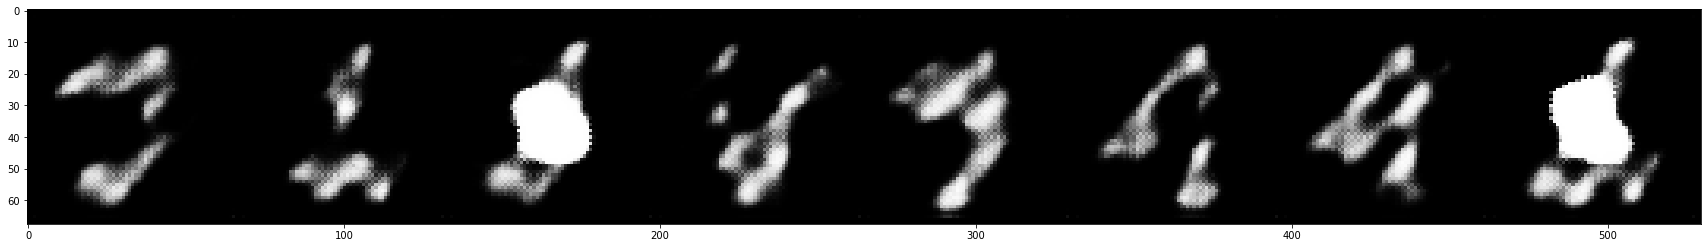

Epoch: 851 | Discriminator Loss - -0.09722008556127548 | Gradient Penalty - 0.03524372726678848 |Generator Loss - -0.4686581492424011]
Epoch: 901 | Discriminator Loss - -0.09079515933990479 | Gradient Penalty - 0.03337949141860008 |Generator Loss - -0.49870800971984863]

Epoch 35
Epoch: 51 | Discriminator Loss - -0.15813837945461273 | Gradient Penalty - 0.03735490143299103 |Generator Loss - -0.5121042728424072]
Epoch: 101 | Discriminator Loss - -0.14695098996162415 | Gradient Penalty - 0.03613480180501938 |Generator Loss - -0.47355926036834717]
Epoch: 151 | Discriminator Loss - -0.10941501706838608 | Gradient Penalty - 0.07711116224527359 |Generator Loss - -0.48720282316207886]
Epoch: 201 | Discriminator Loss - -0.13610278069972992 | Gradient Penalty - 0.03270841762423515 |Generator Loss - -0.41186633706092834]
Epoch: 251 | Discriminator Loss - -0.15304994583129883 | Gradient Penalty - 0.05326617509126663 |Generator Loss - -0.4132974147796631]
Epoch: 301 | Discriminator Loss - -0.12853

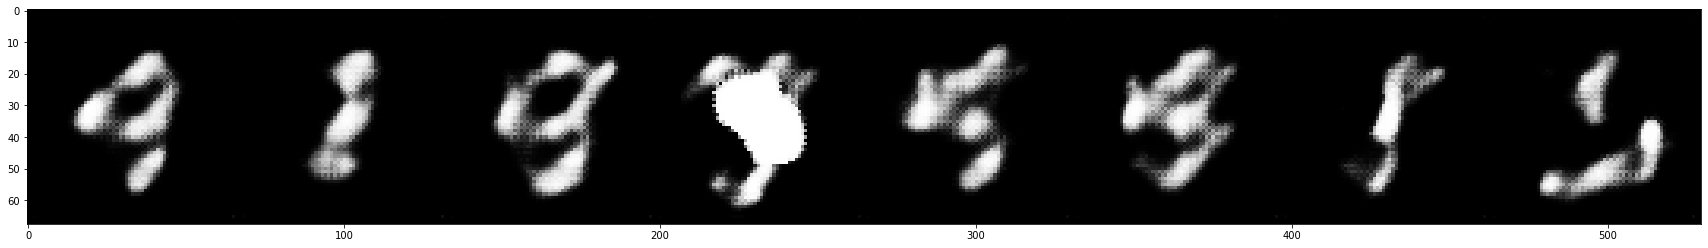

Epoch: 851 | Discriminator Loss - -0.125567227602005 | Gradient Penalty - 0.029851697385311127 |Generator Loss - -0.5706300735473633]
Epoch: 901 | Discriminator Loss - -0.12184316664934158 | Gradient Penalty - 0.04522033780813217 |Generator Loss - -0.484598845243454]

Epoch 36
Epoch: 51 | Discriminator Loss - -0.20353862643241882 | Gradient Penalty - 0.06124272570014 |Generator Loss - -0.5256012678146362]
Epoch: 101 | Discriminator Loss - -0.12201173603534698 | Gradient Penalty - 0.03531860187649727 |Generator Loss - -0.4951073229312897]
Epoch: 151 | Discriminator Loss - -0.04269377887248993 | Gradient Penalty - 0.03927357494831085 |Generator Loss - -0.4958443343639374]
Epoch: 201 | Discriminator Loss - -0.09080763161182404 | Gradient Penalty - 0.05030600354075432 |Generator Loss - -0.4603160321712494]
Epoch: 251 | Discriminator Loss - -0.10704203695058823 | Gradient Penalty - 0.047964997589588165 |Generator Loss - -0.4249938726425171]
Epoch: 301 | Discriminator Loss - -0.1310117542743

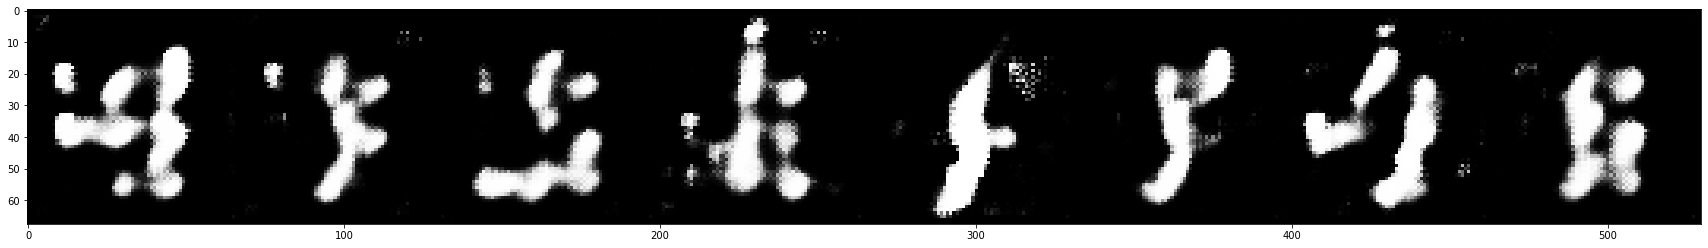

Epoch: 851 | Discriminator Loss - -0.12354542315006256 | Gradient Penalty - 0.04374097287654877 |Generator Loss - -0.39745640754699707]
Epoch: 901 | Discriminator Loss - -0.15362989902496338 | Gradient Penalty - 0.05864530801773071 |Generator Loss - -0.4157053530216217]

Epoch 37
Epoch: 51 | Discriminator Loss - -0.17487670481204987 | Gradient Penalty - 0.03150181099772453 |Generator Loss - -0.47426360845565796]
Epoch: 101 | Discriminator Loss - -0.1299375295639038 | Gradient Penalty - 0.04046722501516342 |Generator Loss - -0.535696268081665]
Epoch: 151 | Discriminator Loss - -0.07607866823673248 | Gradient Penalty - 0.028780149295926094 |Generator Loss - -0.5026286840438843]
Epoch: 201 | Discriminator Loss - -0.14121341705322266 | Gradient Penalty - 0.053202033042907715 |Generator Loss - -0.4963776469230652]
Epoch: 251 | Discriminator Loss - -0.10463014245033264 | Gradient Penalty - 0.07574018836021423 |Generator Loss - -0.40139907598495483]
Epoch: 301 | Discriminator Loss - -0.128086

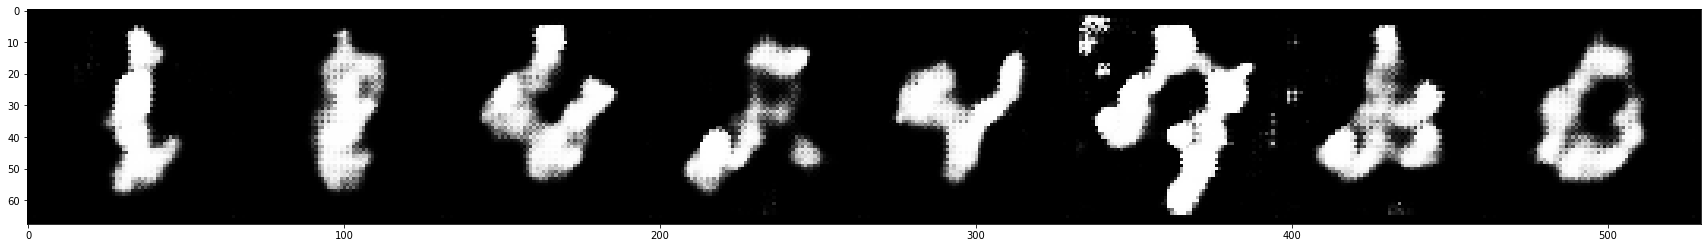

Epoch: 851 | Discriminator Loss - -0.12724006175994873 | Gradient Penalty - 0.028041983023285866 |Generator Loss - -0.4798762798309326]
Epoch: 901 | Discriminator Loss - -0.10762757062911987 | Gradient Penalty - 0.04147130250930786 |Generator Loss - -0.5171080231666565]

Epoch 38
Epoch: 51 | Discriminator Loss - -0.1341119408607483 | Gradient Penalty - 0.021003060042858124 |Generator Loss - -0.5047547221183777]
Epoch: 101 | Discriminator Loss - -0.0863489955663681 | Gradient Penalty - 0.028801869601011276 |Generator Loss - -0.49255847930908203]
Epoch: 151 | Discriminator Loss - -0.15625974535942078 | Gradient Penalty - 0.028233442455530167 |Generator Loss - -0.4815685451030731]
Epoch: 201 | Discriminator Loss - -0.11785979568958282 | Gradient Penalty - 0.03784685209393501 |Generator Loss - -0.523628294467926]
Epoch: 251 | Discriminator Loss - -0.06314800679683685 | Gradient Penalty - 0.06073583662509918 |Generator Loss - -0.5289380550384521]
Epoch: 301 | Discriminator Loss - -0.0900247

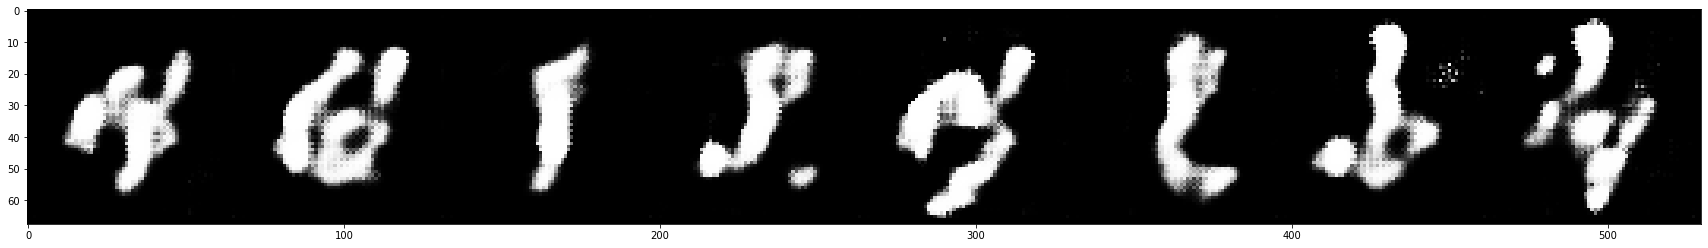

Epoch: 851 | Discriminator Loss - -0.13090957701206207 | Gradient Penalty - 0.06161438301205635 |Generator Loss - -0.4291389286518097]
Epoch: 901 | Discriminator Loss - -0.15886399149894714 | Gradient Penalty - 0.051743827760219574 |Generator Loss - -0.5129529237747192]

Epoch 39
Epoch: 51 | Discriminator Loss - -0.14383605122566223 | Gradient Penalty - 0.030828332528471947 |Generator Loss - -0.5200212001800537]
Epoch: 101 | Discriminator Loss - -0.04625824838876724 | Gradient Penalty - 0.11264362186193466 |Generator Loss - -0.4877222180366516]
Epoch: 151 | Discriminator Loss - -0.15625514090061188 | Gradient Penalty - 0.05751975253224373 |Generator Loss - -0.38083532452583313]
Epoch: 201 | Discriminator Loss - -0.038370318710803986 | Gradient Penalty - 0.0789068266749382 |Generator Loss - -0.43292224407196045]
Epoch: 251 | Discriminator Loss - -0.047442369163036346 | Gradient Penalty - 0.05180419236421585 |Generator Loss - -0.49466317892074585]
Epoch: 301 | Discriminator Loss - -0.110

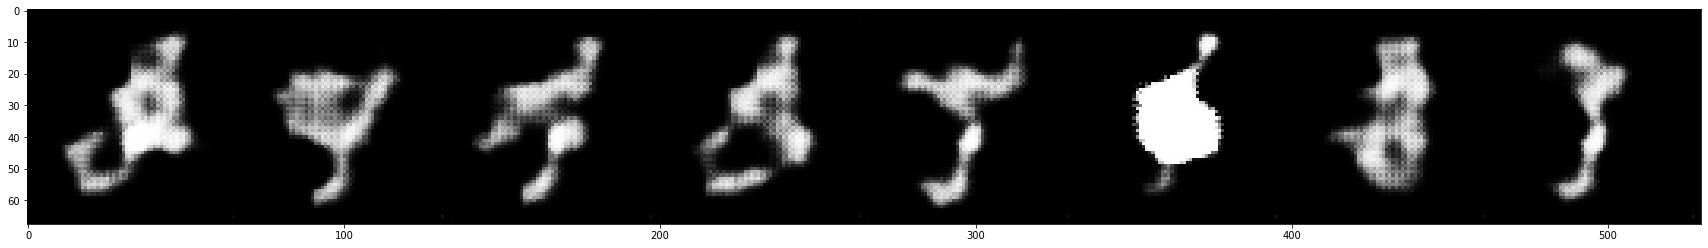

Epoch: 851 | Discriminator Loss - -0.2117237001657486 | Gradient Penalty - 0.060232505202293396 |Generator Loss - -0.3773730993270874]
Epoch: 901 | Discriminator Loss - -0.14672067761421204 | Gradient Penalty - 0.03382084518671036 |Generator Loss - -0.49378103017807007]

Epoch 40
Epoch: 51 | Discriminator Loss - -0.09673146903514862 | Gradient Penalty - 0.029362782835960388 |Generator Loss - -0.3553101420402527]
Epoch: 101 | Discriminator Loss - -0.1330576092004776 | Gradient Penalty - 0.022207068279385567 |Generator Loss - -0.5622312426567078]
Epoch: 151 | Discriminator Loss - -0.08123431354761124 | Gradient Penalty - 0.049832962453365326 |Generator Loss - -0.5371670126914978]
Epoch: 201 | Discriminator Loss - -0.06961364299058914 | Gradient Penalty - 0.03515445441007614 |Generator Loss - -0.5792447328567505]
Epoch: 251 | Discriminator Loss - -0.19781655073165894 | Gradient Penalty - 0.048613183200359344 |Generator Loss - -0.4142228960990906]
Epoch: 301 | Discriminator Loss - -0.16214

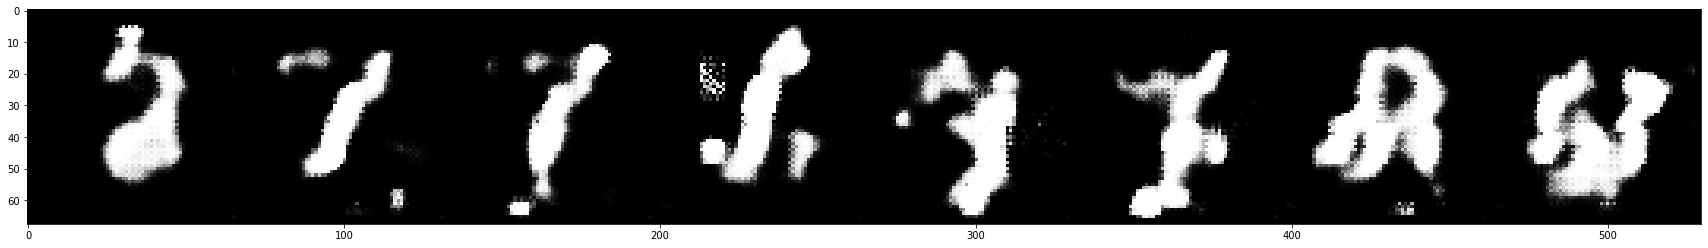

Epoch: 851 | Discriminator Loss - -0.15445643663406372 | Gradient Penalty - 0.09040503948926926 |Generator Loss - -0.42961549758911133]
Epoch: 901 | Discriminator Loss - -0.18590781092643738 | Gradient Penalty - 0.08154746145009995 |Generator Loss - -0.44888192415237427]

Epoch 41
Epoch: 51 | Discriminator Loss - -0.10812358558177948 | Gradient Penalty - 0.048774853348731995 |Generator Loss - -0.44292861223220825]
Epoch: 101 | Discriminator Loss - -0.12692125141620636 | Gradient Penalty - 0.05236487090587616 |Generator Loss - -0.548489511013031]
Epoch: 151 | Discriminator Loss - -0.0895795077085495 | Gradient Penalty - 0.055569667369127274 |Generator Loss - -0.47196805477142334]
Epoch: 201 | Discriminator Loss - -0.15796205401420593 | Gradient Penalty - 0.026931047439575195 |Generator Loss - -0.4478219747543335]
Epoch: 251 | Discriminator Loss - -0.14043617248535156 | Gradient Penalty - 0.04756516218185425 |Generator Loss - -0.49424105882644653]
Epoch: 301 | Discriminator Loss - -0.151

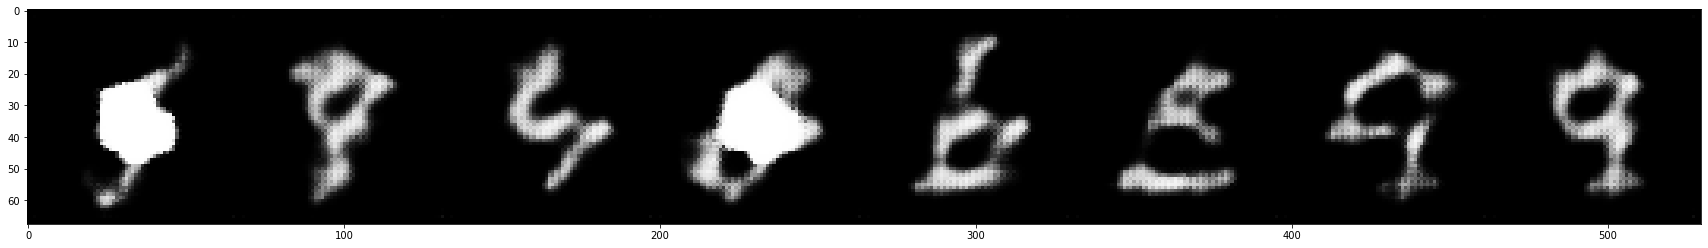

Epoch: 851 | Discriminator Loss - -0.11301720887422562 | Gradient Penalty - 0.03846048563718796 |Generator Loss - -0.5122154355049133]
Epoch: 901 | Discriminator Loss - -0.07686395943164825 | Gradient Penalty - 0.03772111237049103 |Generator Loss - -0.48565909266471863]

Epoch 42
Epoch: 51 | Discriminator Loss - -0.19481591880321503 | Gradient Penalty - 0.029199380427598953 |Generator Loss - -0.4655773341655731]
Epoch: 101 | Discriminator Loss - -0.13790953159332275 | Gradient Penalty - 0.0572972372174263 |Generator Loss - -0.5028801560401917]
Epoch: 151 | Discriminator Loss - -0.06389336287975311 | Gradient Penalty - 0.04682941362261772 |Generator Loss - -0.49684128165245056]
Epoch: 201 | Discriminator Loss - -0.11388454586267471 | Gradient Penalty - 0.020722948014736176 |Generator Loss - -0.48980283737182617]
Epoch: 251 | Discriminator Loss - -0.10746824741363525 | Gradient Penalty - 0.06490033864974976 |Generator Loss - -0.45941102504730225]
Epoch: 301 | Discriminator Loss - -0.1365

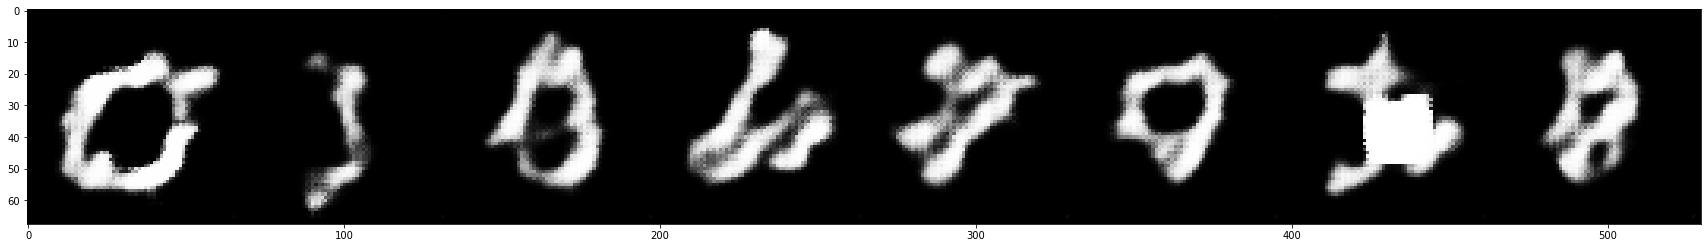

Epoch: 851 | Discriminator Loss - -0.11356272548437119 | Gradient Penalty - 0.02965698391199112 |Generator Loss - -0.48666316270828247]
Epoch: 901 | Discriminator Loss - -0.08384831994771957 | Gradient Penalty - 0.021986400708556175 |Generator Loss - -0.4642200469970703]

Epoch 43
Epoch: 51 | Discriminator Loss - -0.10726140439510345 | Gradient Penalty - 0.035171106457710266 |Generator Loss - -0.4270361661911011]
Epoch: 101 | Discriminator Loss - -0.09575753659009933 | Gradient Penalty - 0.025524383410811424 |Generator Loss - -0.42844462394714355]
Epoch: 151 | Discriminator Loss - -0.08489307761192322 | Gradient Penalty - 0.02455279231071472 |Generator Loss - -0.5071218609809875]
Epoch: 201 | Discriminator Loss - -0.10829180479049683 | Gradient Penalty - 0.04208117723464966 |Generator Loss - -0.4607793092727661]
Epoch: 251 | Discriminator Loss - -0.1380990594625473 | Gradient Penalty - 0.02242012694478035 |Generator Loss - -0.4887615144252777]
Epoch: 301 | Discriminator Loss - -0.08431

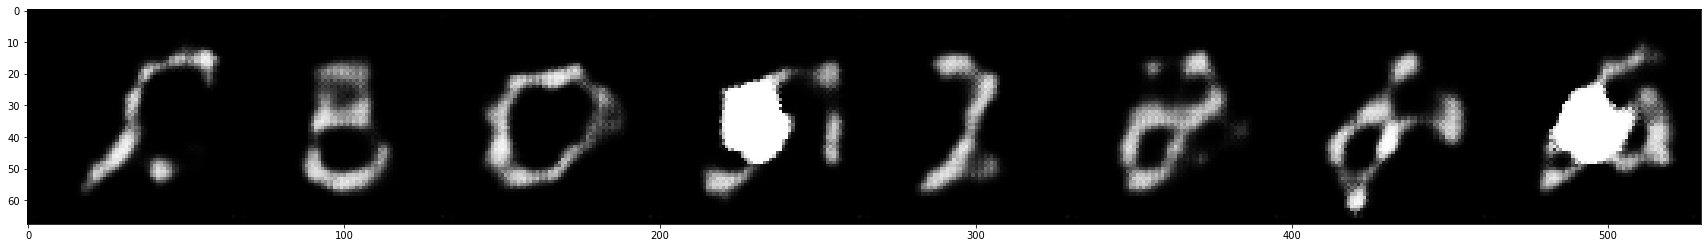

Epoch: 851 | Discriminator Loss - -0.03653630614280701 | Gradient Penalty - 0.0366537868976593 |Generator Loss - -0.5373858213424683]
Epoch: 901 | Discriminator Loss - -0.07293631136417389 | Gradient Penalty - 0.054154861718416214 |Generator Loss - -0.5347709655761719]

Epoch 44
Epoch: 51 | Discriminator Loss - -0.10197026282548904 | Gradient Penalty - 0.04883258789777756 |Generator Loss - -0.5108233094215393]
Epoch: 101 | Discriminator Loss - -0.05619700625538826 | Gradient Penalty - 0.021778743714094162 |Generator Loss - -0.5562019348144531]
Epoch: 151 | Discriminator Loss - -0.12887057662010193 | Gradient Penalty - 0.05083582550287247 |Generator Loss - -0.41102832555770874]
Epoch: 201 | Discriminator Loss - -0.18300281465053558 | Gradient Penalty - 0.03750629723072052 |Generator Loss - -0.451368123292923]
Epoch: 251 | Discriminator Loss - -0.04409536346793175 | Gradient Penalty - 0.028836283832788467 |Generator Loss - -0.5702130794525146]
Epoch: 301 | Discriminator Loss - -0.0377400

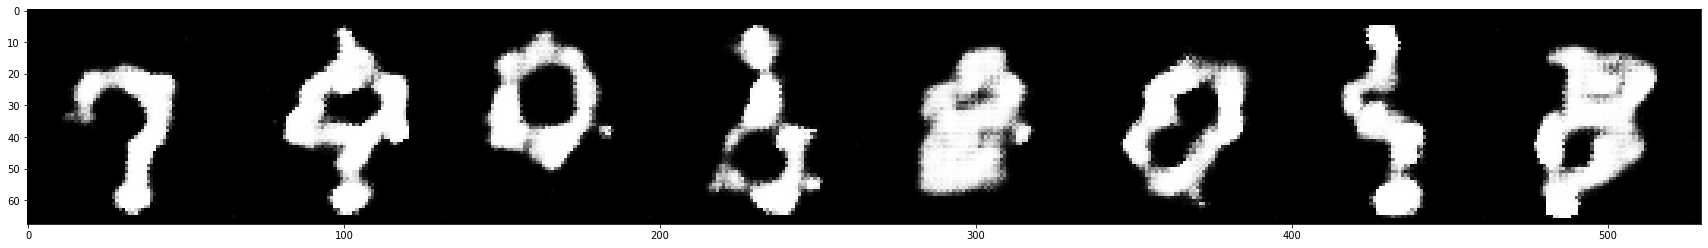

Epoch: 851 | Discriminator Loss - -0.09523902088403702 | Gradient Penalty - 0.027493024244904518 |Generator Loss - -0.5520375967025757]
Epoch: 901 | Discriminator Loss - -0.03731731325387955 | Gradient Penalty - 0.0272001251578331 |Generator Loss - -0.47788283228874207]

Epoch 45
Epoch: 51 | Discriminator Loss - -0.18773861229419708 | Gradient Penalty - 0.031998585909605026 |Generator Loss - -0.478379487991333]
Epoch: 101 | Discriminator Loss - -0.1291990578174591 | Gradient Penalty - 0.027728594839572906 |Generator Loss - -0.39673683047294617]
Epoch: 151 | Discriminator Loss - -0.07532540708780289 | Gradient Penalty - 0.04455813020467758 |Generator Loss - -0.5723386406898499]
Epoch: 201 | Discriminator Loss - -0.1551724672317505 | Gradient Penalty - 0.03617341071367264 |Generator Loss - -0.5111243724822998]
Epoch: 251 | Discriminator Loss - -0.11796382069587708 | Gradient Penalty - 0.0833110511302948 |Generator Loss - -0.4650014042854309]
Epoch: 301 | Discriminator Loss - -0.099799819

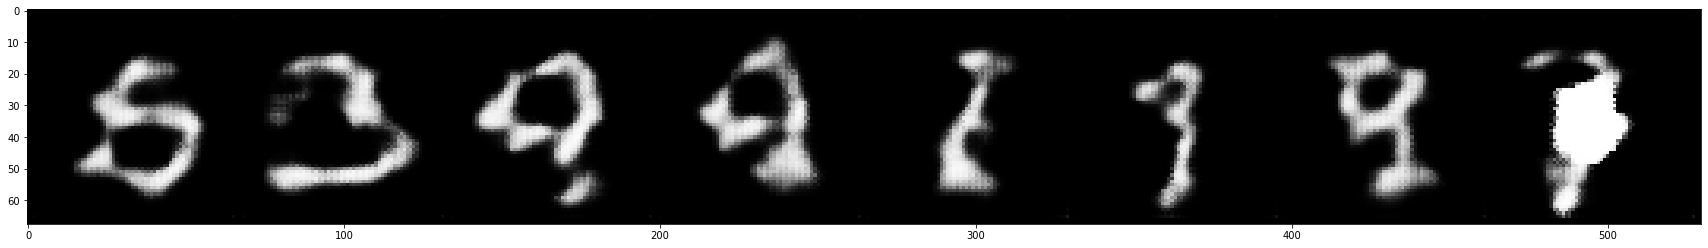

Epoch: 851 | Discriminator Loss - -0.16568617522716522 | Gradient Penalty - 0.029025515541434288 |Generator Loss - -0.48672670125961304]
Epoch: 901 | Discriminator Loss - -0.08519306778907776 | Gradient Penalty - 0.03010401502251625 |Generator Loss - -0.5285227298736572]

Epoch 46
Epoch: 51 | Discriminator Loss - -0.1273941844701767 | Gradient Penalty - 0.03180689737200737 |Generator Loss - -0.5121400356292725]
Epoch: 101 | Discriminator Loss - -0.06632781773805618 | Gradient Penalty - 0.04188089817762375 |Generator Loss - -0.5690131783485413]
Epoch: 151 | Discriminator Loss - -0.06549860537052155 | Gradient Penalty - 0.022947654128074646 |Generator Loss - -0.5650712847709656]
Epoch: 201 | Discriminator Loss - -0.13193592429161072 | Gradient Penalty - 0.02839246764779091 |Generator Loss - -0.4808286726474762]
Epoch: 251 | Discriminator Loss - -0.18179042637348175 | Gradient Penalty - 0.02545778825879097 |Generator Loss - -0.4610913395881653]
Epoch: 301 | Discriminator Loss - -0.0661323

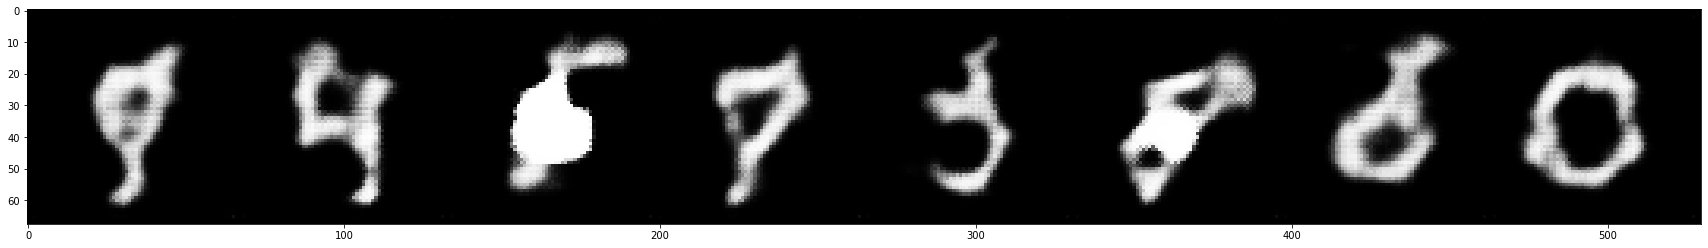

Epoch: 851 | Discriminator Loss - -0.16856634616851807 | Gradient Penalty - 0.0300804041326046 |Generator Loss - -0.4704832434654236]
Epoch: 901 | Discriminator Loss - -0.12051733583211899 | Gradient Penalty - 0.028842603787779808 |Generator Loss - -0.5113970041275024]

Epoch 47
Epoch: 51 | Discriminator Loss - -0.13957998156547546 | Gradient Penalty - 0.02687225304543972 |Generator Loss - -0.48300617933273315]
Epoch: 101 | Discriminator Loss - -0.12400080263614655 | Gradient Penalty - 0.0327518992125988 |Generator Loss - -0.4337373375892639]
Epoch: 151 | Discriminator Loss - -0.11420425027608871 | Gradient Penalty - 0.021289745345711708 |Generator Loss - -0.5019192695617676]
Epoch: 201 | Discriminator Loss - -0.05486509948968887 | Gradient Penalty - 0.05515994876623154 |Generator Loss - -0.5830392241477966]
Epoch: 251 | Discriminator Loss - -0.1843002736568451 | Gradient Penalty - 0.022560205310583115 |Generator Loss - -0.4374210238456726]
Epoch: 301 | Discriminator Loss - -0.17260998

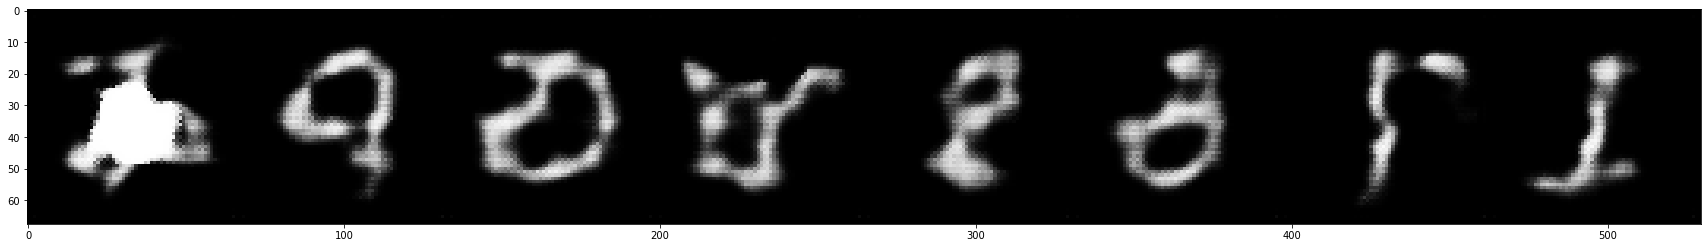

Epoch: 851 | Discriminator Loss - -0.1656472235918045 | Gradient Penalty - 0.049314066767692566 |Generator Loss - -0.4242967963218689]
Epoch: 901 | Discriminator Loss - -0.07047863304615021 | Gradient Penalty - 0.048106953501701355 |Generator Loss - -0.504679799079895]

Epoch 48
Epoch: 51 | Discriminator Loss - -0.06185685843229294 | Gradient Penalty - 0.031583912670612335 |Generator Loss - -0.5355042219161987]
Epoch: 101 | Discriminator Loss - -0.14341460168361664 | Gradient Penalty - 0.020988089963793755 |Generator Loss - -0.4560070037841797]
Epoch: 151 | Discriminator Loss - -0.0915345549583435 | Gradient Penalty - 0.024918314069509506 |Generator Loss - -0.5799519419670105]
Epoch: 201 | Discriminator Loss - -0.12445294111967087 | Gradient Penalty - 0.030012018978595734 |Generator Loss - -0.5841477513313293]
Epoch: 251 | Discriminator Loss - -0.12433623522520065 | Gradient Penalty - 0.03707925230264664 |Generator Loss - -0.41867774724960327]
Epoch: 301 | Discriminator Loss - -0.07913

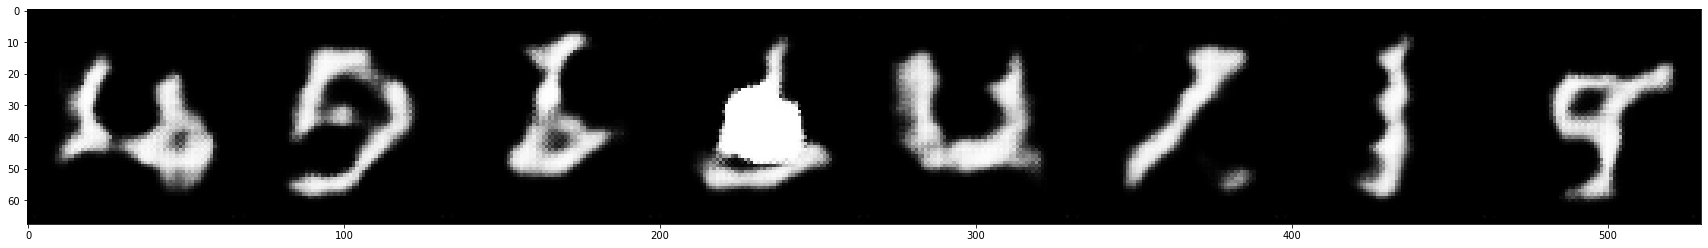

Epoch: 851 | Discriminator Loss - -0.10486739128828049 | Gradient Penalty - 0.01993364654481411 |Generator Loss - -0.5056155920028687]
Epoch: 901 | Discriminator Loss - -0.1272793561220169 | Gradient Penalty - 0.019881650805473328 |Generator Loss - -0.5715767741203308]

Epoch 49
Epoch: 51 | Discriminator Loss - -0.13467411696910858 | Gradient Penalty - 0.06151833012700081 |Generator Loss - -0.43672826886177063]
Epoch: 101 | Discriminator Loss - -0.08031865954399109 | Gradient Penalty - 0.0244847871363163 |Generator Loss - -0.45676082372665405]
Epoch: 151 | Discriminator Loss - -0.09038786590099335 | Gradient Penalty - 0.030743377283215523 |Generator Loss - -0.5372475385665894]
Epoch: 201 | Discriminator Loss - -0.12321332842111588 | Gradient Penalty - 0.061956457793712616 |Generator Loss - -0.45844021439552307]
Epoch: 251 | Discriminator Loss - -0.09623782336711884 | Gradient Penalty - 0.06633509695529938 |Generator Loss - -0.48563352227211]
Epoch: 301 | Discriminator Loss - -0.1353108

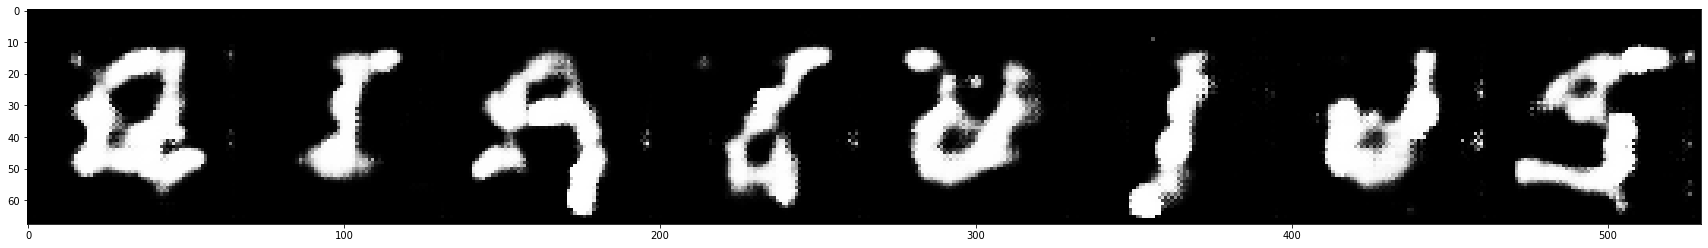

Epoch: 851 | Discriminator Loss - -0.1032562181353569 | Gradient Penalty - 0.03214532881975174 |Generator Loss - -0.41181349754333496]
Epoch: 901 | Discriminator Loss - -0.0958709865808487 | Gradient Penalty - 0.035647496581077576 |Generator Loss - -0.46635234355926514]

Epoch 50
Epoch: 51 | Discriminator Loss - -0.15027475357055664 | Gradient Penalty - 0.03066856414079666 |Generator Loss - -0.5181882381439209]
Epoch: 101 | Discriminator Loss - -0.12489806115627289 | Gradient Penalty - 0.04514111578464508 |Generator Loss - -0.42286765575408936]
Epoch: 151 | Discriminator Loss - -0.10241363197565079 | Gradient Penalty - 0.03514685481786728 |Generator Loss - -0.5284969806671143]
Epoch: 201 | Discriminator Loss - -0.10379723459482193 | Gradient Penalty - 0.027370236814022064 |Generator Loss - -0.4261031150817871]
Epoch: 251 | Discriminator Loss - -0.12689609825611115 | Gradient Penalty - 0.01661841943860054 |Generator Loss - -0.44056040048599243]
Epoch: 301 | Discriminator Loss - -0.11921

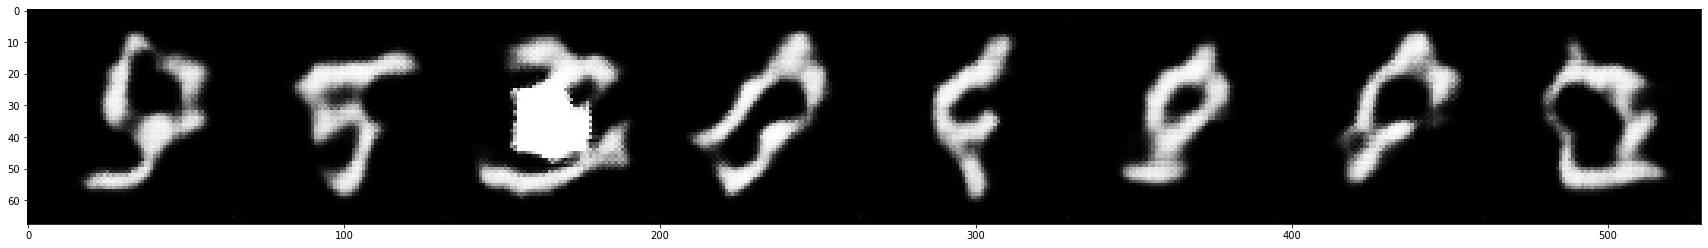

Epoch: 851 | Discriminator Loss - -0.03565654903650284 | Gradient Penalty - 0.044538162648677826 |Generator Loss - -0.4949567914009094]
Epoch: 901 | Discriminator Loss - -0.10698375105857849 | Gradient Penalty - 0.031763434410095215 |Generator Loss - -0.48146742582321167]

Epoch 51
Epoch: 51 | Discriminator Loss - -0.09253861755132675 | Gradient Penalty - 0.02513481117784977 |Generator Loss - -0.49839210510253906]
Epoch: 101 | Discriminator Loss - -0.046200722455978394 | Gradient Penalty - 0.017272861674427986 |Generator Loss - -0.56510329246521]
Epoch: 151 | Discriminator Loss - -0.1322908103466034 | Gradient Penalty - 0.018112152814865112 |Generator Loss - -0.509396493434906]
Epoch: 201 | Discriminator Loss - -0.14705845713615417 | Gradient Penalty - 0.0345558263361454 |Generator Loss - -0.530771017074585]
Epoch: 251 | Discriminator Loss - -0.14554114639759064 | Gradient Penalty - 0.03464852645993233 |Generator Loss - -0.48287320137023926]
Epoch: 301 | Discriminator Loss - -0.0793125

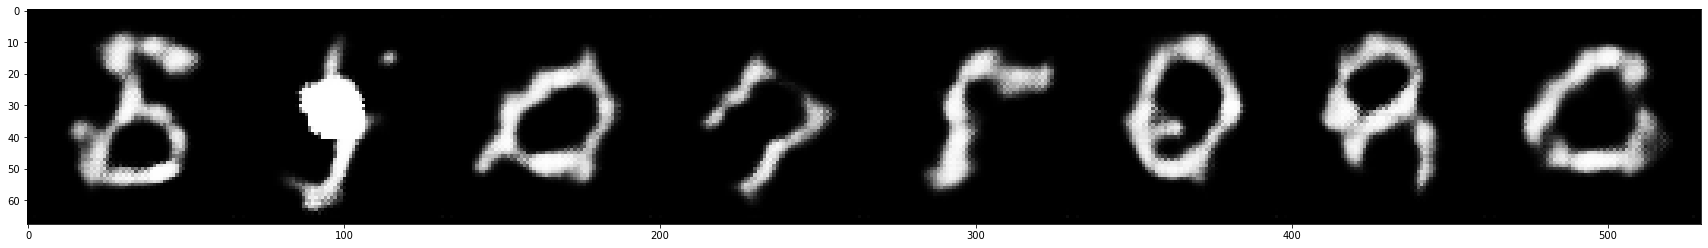

Epoch: 851 | Discriminator Loss - -0.016074128448963165 | Gradient Penalty - 0.050022415816783905 |Generator Loss - -0.5127148628234863]
Epoch: 901 | Discriminator Loss - -0.09716742485761642 | Gradient Penalty - 0.035744138062000275 |Generator Loss - -0.5427770018577576]

Epoch 52
Epoch: 51 | Discriminator Loss - -0.1512814611196518 | Gradient Penalty - 0.03969778120517731 |Generator Loss - -0.5193235278129578]
Epoch: 101 | Discriminator Loss - -0.11776169389486313 | Gradient Penalty - 0.016204992309212685 |Generator Loss - -0.5067870020866394]
Epoch: 151 | Discriminator Loss - -0.11382797360420227 | Gradient Penalty - 0.024846285581588745 |Generator Loss - -0.5291963815689087]
Epoch: 201 | Discriminator Loss - -0.13673175871372223 | Gradient Penalty - 0.03847559168934822 |Generator Loss - -0.44624757766723633]
Epoch: 251 | Discriminator Loss - -0.1371660977602005 | Gradient Penalty - 0.014042629860341549 |Generator Loss - -0.4354875385761261]
Epoch: 301 | Discriminator Loss - -0.0957

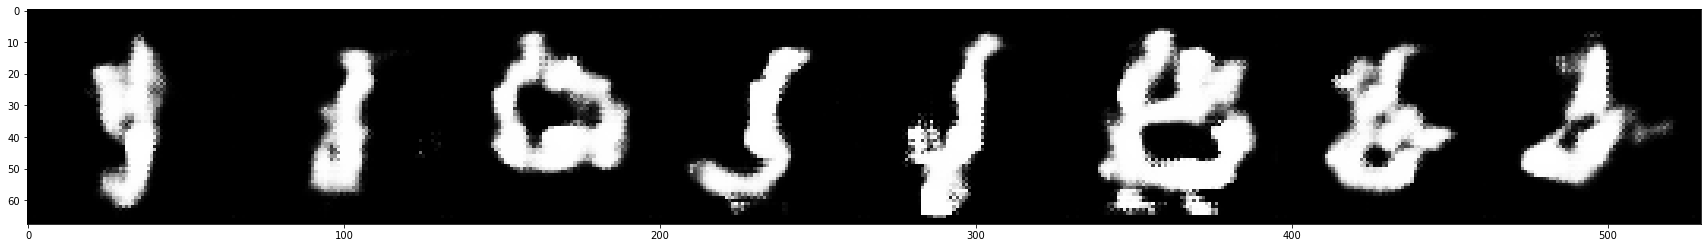

Epoch: 851 | Discriminator Loss - -0.10860811918973923 | Gradient Penalty - 0.030876288190484047 |Generator Loss - -0.5061951875686646]
Epoch: 901 | Discriminator Loss - -0.06448177248239517 | Gradient Penalty - 0.03344067186117172 |Generator Loss - -0.5591062307357788]

Epoch 53
Epoch: 51 | Discriminator Loss - -0.10480865836143494 | Gradient Penalty - 0.029232177883386612 |Generator Loss - -0.4502168297767639]
Epoch: 101 | Discriminator Loss - -0.07907941192388535 | Gradient Penalty - 0.02883247099816799 |Generator Loss - -0.5359053015708923]
Epoch: 151 | Discriminator Loss - -0.03353486210107803 | Gradient Penalty - 0.06989716738462448 |Generator Loss - -0.41188693046569824]
Epoch: 201 | Discriminator Loss - -0.10235902667045593 | Gradient Penalty - 0.036274224519729614 |Generator Loss - -0.5472909212112427]
Epoch: 251 | Discriminator Loss - -0.05153407156467438 | Gradient Penalty - 0.24333642423152924 |Generator Loss - -0.29154178500175476]
Epoch: 301 | Discriminator Loss - -0.0580

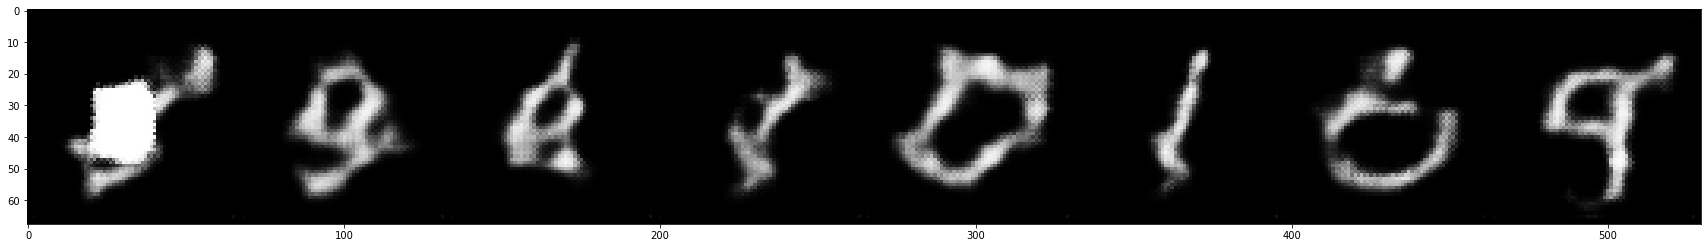

Epoch: 851 | Discriminator Loss - -0.043252937495708466 | Gradient Penalty - 0.02039218693971634 |Generator Loss - -0.5533653497695923]
Epoch: 901 | Discriminator Loss - -0.13135944306850433 | Gradient Penalty - 0.020736047998070717 |Generator Loss - -0.5180618762969971]

Epoch 54
Epoch: 51 | Discriminator Loss - -0.10599897801876068 | Gradient Penalty - 0.03641403838992119 |Generator Loss - -0.5732599496841431]
Epoch: 101 | Discriminator Loss - -0.058665379881858826 | Gradient Penalty - 0.017280951142311096 |Generator Loss - -0.5217056274414062]
Epoch: 151 | Discriminator Loss - -0.1592918485403061 | Gradient Penalty - 0.0242240522056818 |Generator Loss - -0.441417396068573]
Epoch: 201 | Discriminator Loss - -0.11001989245414734 | Gradient Penalty - 0.02356836572289467 |Generator Loss - -0.42170456051826477]
Epoch: 251 | Discriminator Loss - -0.024817533791065216 | Gradient Penalty - 0.05520682781934738 |Generator Loss - -0.5337292551994324]
Epoch: 301 | Discriminator Loss - -0.111568

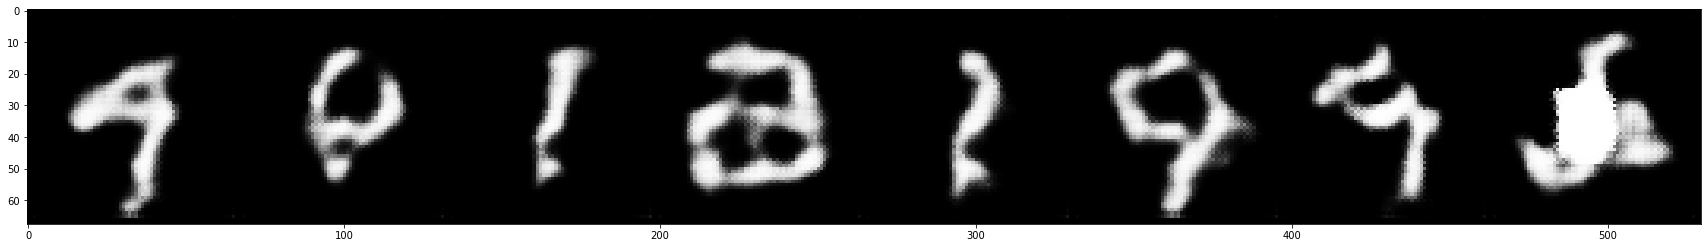

Epoch: 851 | Discriminator Loss - -0.11795374006032944 | Gradient Penalty - 0.02909488044679165 |Generator Loss - -0.49749159812927246]
Epoch: 901 | Discriminator Loss - -0.07606977969408035 | Gradient Penalty - 0.013061100617051125 |Generator Loss - -0.5184521079063416]

Epoch 55
Epoch: 51 | Discriminator Loss - -0.07534444332122803 | Gradient Penalty - 0.057990312576293945 |Generator Loss - -0.47090208530426025]
Epoch: 101 | Discriminator Loss - -0.06957010924816132 | Gradient Penalty - 0.029322460293769836 |Generator Loss - -0.453612744808197]
Epoch: 151 | Discriminator Loss - -0.12864680588245392 | Gradient Penalty - 0.01666216365993023 |Generator Loss - -0.5183011293411255]
Epoch: 201 | Discriminator Loss - -0.11869046837091446 | Gradient Penalty - 0.02976449579000473 |Generator Loss - -0.6450684666633606]
Epoch: 251 | Discriminator Loss - -0.10200971364974976 | Gradient Penalty - 0.05873379111289978 |Generator Loss - -0.3570960760116577]
Epoch: 301 | Discriminator Loss - -0.07453

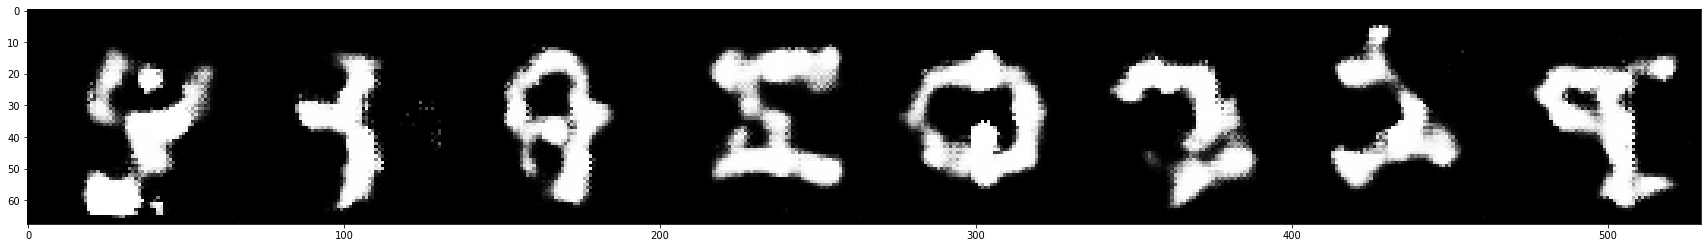

Epoch: 851 | Discriminator Loss - -0.06459332257509232 | Gradient Penalty - 0.02014356106519699 |Generator Loss - -0.5213875770568848]
Epoch: 901 | Discriminator Loss - -0.10064366459846497 | Gradient Penalty - 0.04049938544631004 |Generator Loss - -0.5626739263534546]

Epoch 56
Epoch: 51 | Discriminator Loss - -0.12823733687400818 | Gradient Penalty - 0.059404157102108 |Generator Loss - -0.3937462568283081]
Epoch: 101 | Discriminator Loss - -0.08311264216899872 | Gradient Penalty - 0.03613544628024101 |Generator Loss - -0.5341973900794983]
Epoch: 151 | Discriminator Loss - -0.023884005844593048 | Gradient Penalty - 0.024482540786266327 |Generator Loss - -0.514891505241394]
Epoch: 201 | Discriminator Loss - -0.10866236686706543 | Gradient Penalty - 0.03409510850906372 |Generator Loss - -0.4441114664077759]
Epoch: 251 | Discriminator Loss - -0.12174875289201736 | Gradient Penalty - 0.04203128069639206 |Generator Loss - -0.49523523449897766]
Epoch: 301 | Discriminator Loss - -0.090417236

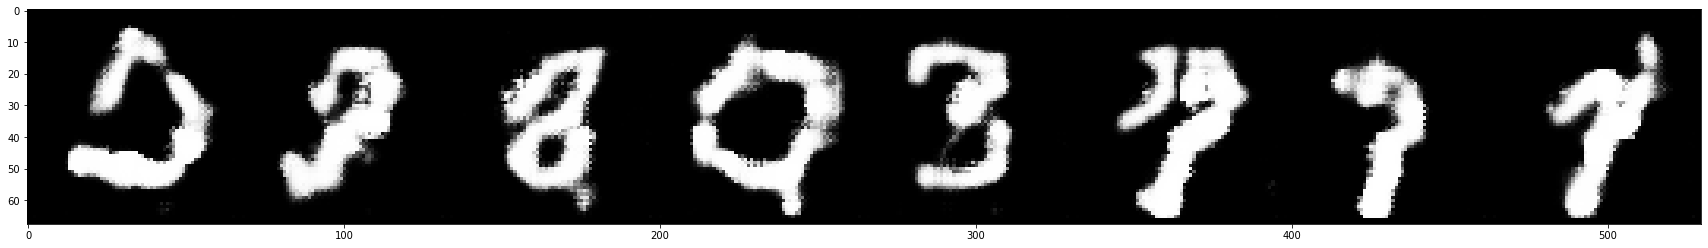

Epoch: 851 | Discriminator Loss - -0.05546244606375694 | Gradient Penalty - 0.05605706945061684 |Generator Loss - -0.4020657539367676]
Epoch: 901 | Discriminator Loss - -0.15171445906162262 | Gradient Penalty - 0.012565483339130878 |Generator Loss - -0.5106844902038574]

Epoch 57
Epoch: 51 | Discriminator Loss - -0.08509936928749084 | Gradient Penalty - 0.03287986293435097 |Generator Loss - -0.5122337341308594]
Epoch: 101 | Discriminator Loss - -0.01748119667172432 | Gradient Penalty - 0.019827675074338913 |Generator Loss - -0.5071161985397339]
Epoch: 151 | Discriminator Loss - -0.1386386603116989 | Gradient Penalty - 0.026515498757362366 |Generator Loss - -0.5022568702697754]
Epoch: 201 | Discriminator Loss - -0.2883172333240509 | Gradient Penalty - 0.03710481896996498 |Generator Loss - -0.5051440000534058]
Epoch: 251 | Discriminator Loss - -0.12910887598991394 | Gradient Penalty - 0.02914312109351158 |Generator Loss - -0.49433544278144836]
Epoch: 301 | Discriminator Loss - -0.0503665

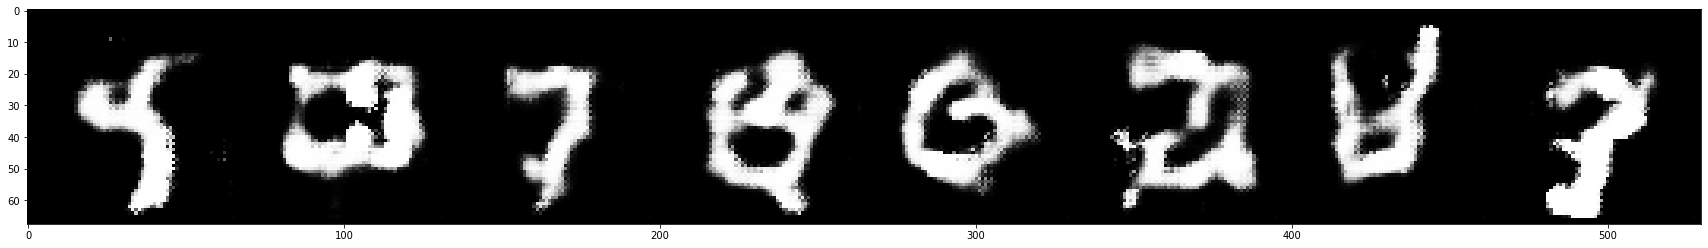

Epoch: 851 | Discriminator Loss - -0.04905988276004791 | Gradient Penalty - 0.049227699637413025 |Generator Loss - -0.4634104371070862]
Epoch: 901 | Discriminator Loss - -0.07668005675077438 | Gradient Penalty - 0.022004256024956703 |Generator Loss - -0.5160611867904663]

Epoch 58
Epoch: 51 | Discriminator Loss - -0.0744737982749939 | Gradient Penalty - 0.0321352519094944 |Generator Loss - -0.5562452673912048]
Epoch: 101 | Discriminator Loss - -0.08927704393863678 | Gradient Penalty - 0.03139497712254524 |Generator Loss - -0.4969717562198639]
Epoch: 151 | Discriminator Loss - -0.11352629959583282 | Gradient Penalty - 0.021272553130984306 |Generator Loss - -0.44330033659935]
Epoch: 201 | Discriminator Loss - -0.18894484639167786 | Gradient Penalty - 0.023446179926395416 |Generator Loss - -0.4481344223022461]
Epoch: 251 | Discriminator Loss - -0.051171302795410156 | Gradient Penalty - 0.037022292613983154 |Generator Loss - -0.49322617053985596]
Epoch: 301 | Discriminator Loss - -0.036497

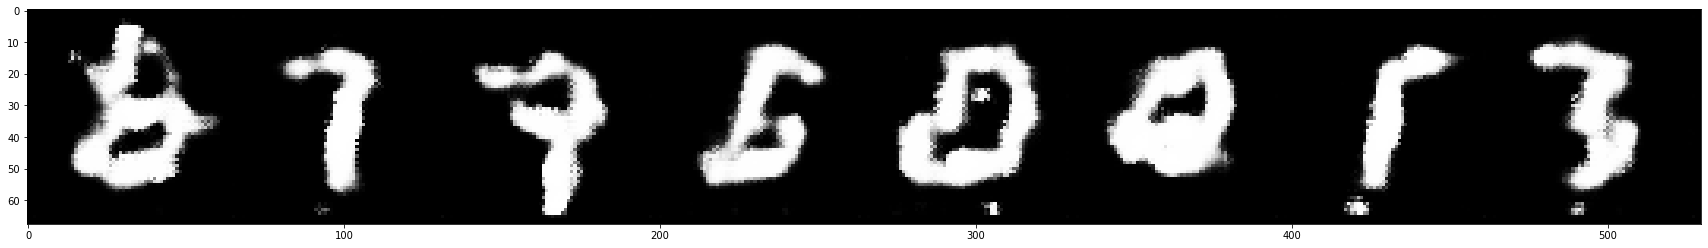

Epoch: 851 | Discriminator Loss - -0.09420321136713028 | Gradient Penalty - 0.04321231693029404 |Generator Loss - -0.6053845882415771]
Epoch: 901 | Discriminator Loss - -0.0621376596391201 | Gradient Penalty - 0.033627692610025406 |Generator Loss - -0.5509653091430664]

Epoch 59
Epoch: 51 | Discriminator Loss - -0.08564217388629913 | Gradient Penalty - 0.01724235527217388 |Generator Loss - -0.5343849658966064]
Epoch: 101 | Discriminator Loss - -0.08128051459789276 | Gradient Penalty - 0.04268752038478851 |Generator Loss - -0.42661169171333313]
Epoch: 151 | Discriminator Loss - -0.057400405406951904 | Gradient Penalty - 0.03402131795883179 |Generator Loss - -0.5059735774993896]
Epoch: 201 | Discriminator Loss - -0.11400199681520462 | Gradient Penalty - 0.015466203913092613 |Generator Loss - -0.5206927061080933]
Epoch: 251 | Discriminator Loss - -0.09740211069583893 | Gradient Penalty - 0.031117070466279984 |Generator Loss - -0.6519367694854736]
Epoch: 301 | Discriminator Loss - -0.07709

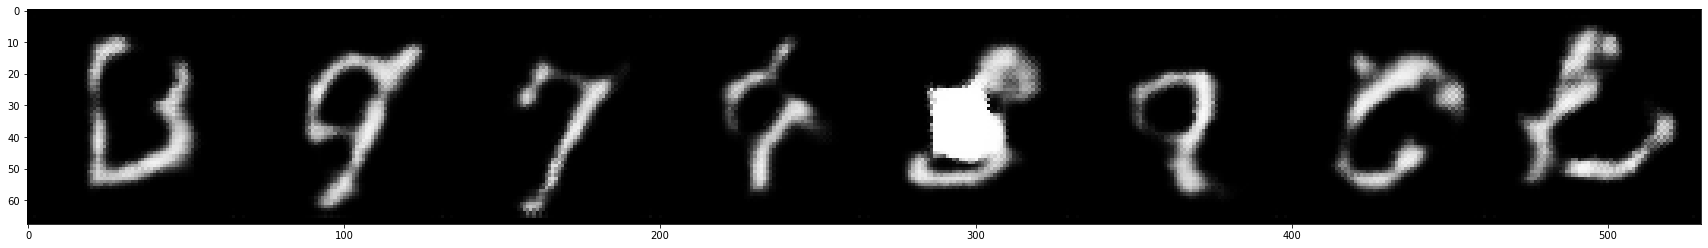

Epoch: 851 | Discriminator Loss - -0.08673135936260223 | Gradient Penalty - 0.0260934978723526 |Generator Loss - -0.4968651533126831]
Epoch: 901 | Discriminator Loss - -0.08192794024944305 | Gradient Penalty - 0.02244599163532257 |Generator Loss - -0.5268227458000183]

Epoch 60
Epoch: 51 | Discriminator Loss - -0.14552108943462372 | Gradient Penalty - 0.028711995109915733 |Generator Loss - -0.488095223903656]
Epoch: 101 | Discriminator Loss - -0.0699014887213707 | Gradient Penalty - 0.0315268412232399 |Generator Loss - -0.4973430633544922]
Epoch: 151 | Discriminator Loss - -0.04574566334486008 | Gradient Penalty - 0.039520032703876495 |Generator Loss - -0.4961385428905487]
Epoch: 201 | Discriminator Loss - -0.11485946178436279 | Gradient Penalty - 0.0180819034576416 |Generator Loss - -0.4891863763332367]
Epoch: 251 | Discriminator Loss - -0.058425240218639374 | Gradient Penalty - 0.022524425759911537 |Generator Loss - -0.47992849349975586]
Epoch: 301 | Discriminator Loss - -0.105299010

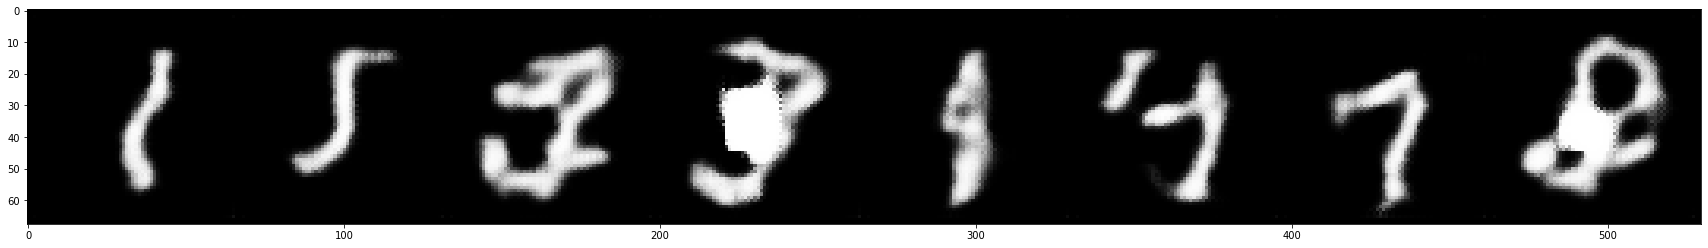

Epoch: 851 | Discriminator Loss - -0.08295609056949615 | Gradient Penalty - 0.019977791234850883 |Generator Loss - -0.495939701795578]
Epoch: 901 | Discriminator Loss - -0.11926274746656418 | Gradient Penalty - 0.01786399818956852 |Generator Loss - -0.5095994472503662]

Epoch 61
Epoch: 51 | Discriminator Loss - -0.11055535078048706 | Gradient Penalty - 0.01956704631447792 |Generator Loss - -0.49206262826919556]
Epoch: 101 | Discriminator Loss - -0.07998442649841309 | Gradient Penalty - 0.03059866838157177 |Generator Loss - -0.4735826253890991]
Epoch: 151 | Discriminator Loss - -0.0943777859210968 | Gradient Penalty - 0.029464568942785263 |Generator Loss - -0.47270649671554565]
Epoch: 201 | Discriminator Loss - -0.09383109211921692 | Gradient Penalty - 0.046368036419153214 |Generator Loss - -0.43447086215019226]
Epoch: 251 | Discriminator Loss - -0.11341805756092072 | Gradient Penalty - 0.02712593972682953 |Generator Loss - -0.49334222078323364]
Epoch: 301 | Discriminator Loss - -0.1064

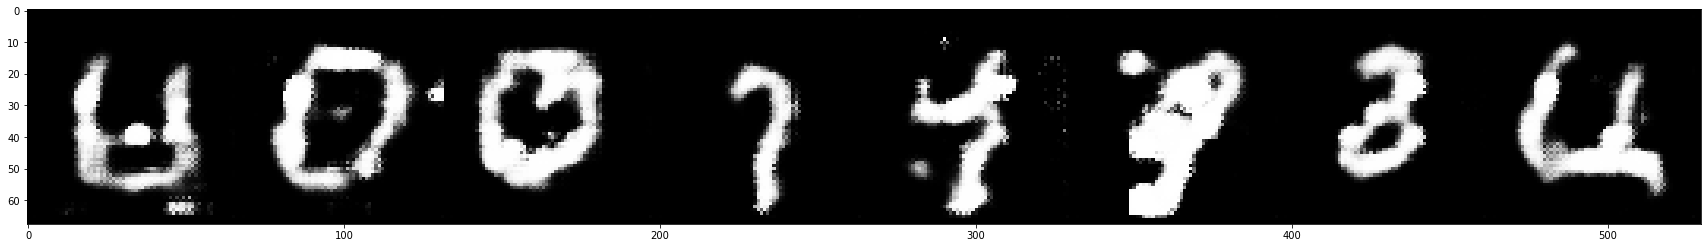

Epoch: 851 | Discriminator Loss - -0.07469499856233597 | Gradient Penalty - 0.0311654731631279 |Generator Loss - -0.4655948281288147]
Epoch: 901 | Discriminator Loss - -0.09619300812482834 | Gradient Penalty - 0.017614729702472687 |Generator Loss - -0.5214866399765015]

Epoch 62
Epoch: 51 | Discriminator Loss - -0.09511478245258331 | Gradient Penalty - 0.020835567265748978 |Generator Loss - -0.4995345175266266]
Epoch: 101 | Discriminator Loss - -0.11616714298725128 | Gradient Penalty - 0.017741307616233826 |Generator Loss - -0.5009753704071045]
Epoch: 151 | Discriminator Loss - -0.128523588180542 | Gradient Penalty - 0.04378511756658554 |Generator Loss - -0.504015326499939]
Epoch: 201 | Discriminator Loss - -0.09572569280862808 | Gradient Penalty - 0.02608516253530979 |Generator Loss - -0.504754900932312]
Epoch: 251 | Discriminator Loss - -0.07538637518882751 | Gradient Penalty - 0.02117374911904335 |Generator Loss - -0.49507105350494385]
Epoch: 301 | Discriminator Loss - -0.0966586396

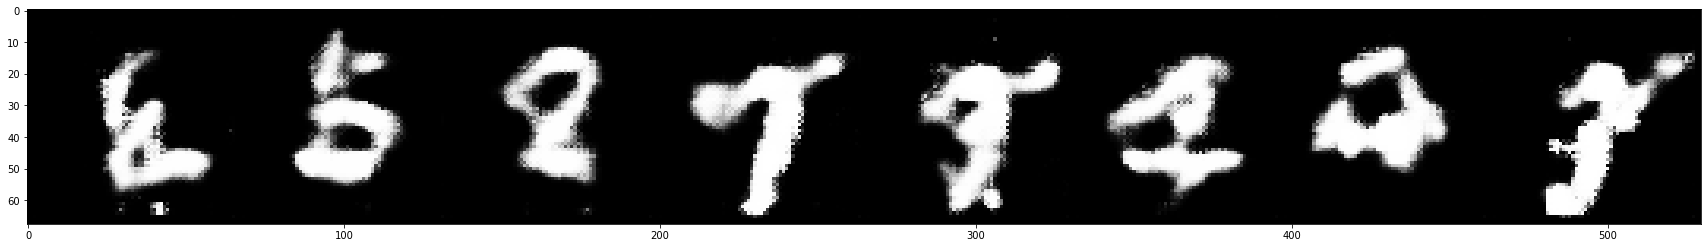

Epoch: 851 | Discriminator Loss - -0.10539320111274719 | Gradient Penalty - 0.027022626250982285 |Generator Loss - -0.48061954975128174]
Epoch: 901 | Discriminator Loss - -0.09634707868099213 | Gradient Penalty - 0.0453885942697525 |Generator Loss - -0.4269065856933594]

Epoch 63
Epoch: 51 | Discriminator Loss - -0.07570193707942963 | Gradient Penalty - 0.04220212996006012 |Generator Loss - -0.5009176731109619]
Epoch: 101 | Discriminator Loss - -0.11909458041191101 | Gradient Penalty - 0.011606662534177303 |Generator Loss - -0.5425550937652588]
Epoch: 151 | Discriminator Loss - -0.05548325926065445 | Gradient Penalty - 0.03552111238241196 |Generator Loss - -0.5412744283676147]
Epoch: 201 | Discriminator Loss - -0.1141059622168541 | Gradient Penalty - 0.014686654321849346 |Generator Loss - -0.486710786819458]
Epoch: 251 | Discriminator Loss - -0.12843839824199677 | Gradient Penalty - 0.02578659914433956 |Generator Loss - -0.5111106634140015]
Epoch: 301 | Discriminator Loss - -0.08821084

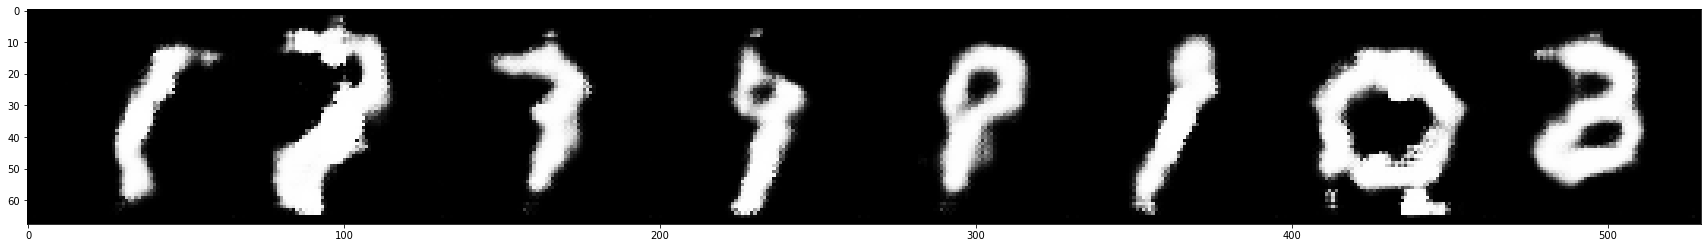

Epoch: 851 | Discriminator Loss - -0.025889381766319275 | Gradient Penalty - 0.053190961480140686 |Generator Loss - -0.4657229483127594]
Epoch: 901 | Discriminator Loss - -0.10664590448141098 | Gradient Penalty - 0.022706547752022743 |Generator Loss - -0.48851099610328674]

Epoch 64
Epoch: 51 | Discriminator Loss - -0.13158036768436432 | Gradient Penalty - 0.04265991970896721 |Generator Loss - -0.49842625856399536]
Epoch: 101 | Discriminator Loss - -0.0984724760055542 | Gradient Penalty - 0.02054106816649437 |Generator Loss - -0.43999534845352173]
Epoch: 151 | Discriminator Loss - -0.106617771089077 | Gradient Penalty - 0.026895053684711456 |Generator Loss - -0.4637237787246704]
Epoch: 201 | Discriminator Loss - -0.07312949001789093 | Gradient Penalty - 0.029643820598721504 |Generator Loss - -0.4392241835594177]
Epoch: 251 | Discriminator Loss - -0.12026850879192352 | Gradient Penalty - 0.015830708667635918 |Generator Loss - -0.4593542218208313]
Epoch: 301 | Discriminator Loss - -0.123

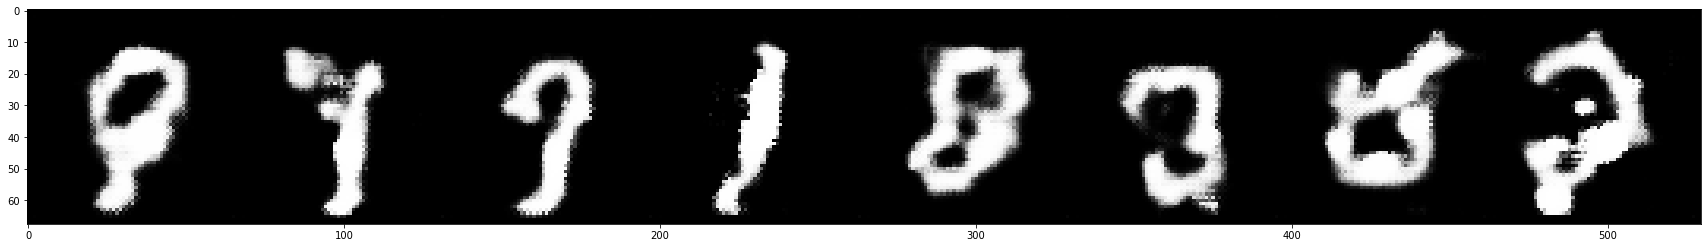

Epoch: 851 | Discriminator Loss - -0.12284331768751144 | Gradient Penalty - 0.017704730853438377 |Generator Loss - -0.5145182609558105]
Epoch: 901 | Discriminator Loss - -0.08183297514915466 | Gradient Penalty - 0.036923494189977646 |Generator Loss - -0.4329584240913391]

Epoch 65
Epoch: 51 | Discriminator Loss - -0.15691623091697693 | Gradient Penalty - 0.022830629721283913 |Generator Loss - -0.4182569980621338]
Epoch: 101 | Discriminator Loss - -0.1145373210310936 | Gradient Penalty - 0.027741527184844017 |Generator Loss - -0.5013436079025269]
Epoch: 151 | Discriminator Loss - -0.0835103914141655 | Gradient Penalty - 0.00522632384672761 |Generator Loss - -0.509793758392334]
Epoch: 201 | Discriminator Loss - -0.10049416124820709 | Gradient Penalty - 0.01908520981669426 |Generator Loss - -0.45970070362091064]
Epoch: 251 | Discriminator Loss - -0.12313932180404663 | Gradient Penalty - 0.04055694118142128 |Generator Loss - -0.4776005148887634]
Epoch: 301 | Discriminator Loss - -0.0906100

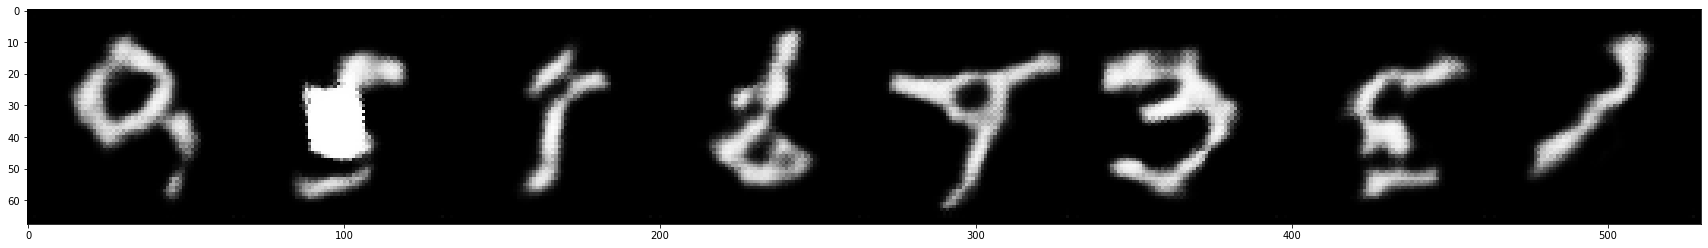

Epoch: 851 | Discriminator Loss - -0.11779898405075073 | Gradient Penalty - 0.026346329599618912 |Generator Loss - -0.4551190733909607]
Epoch: 901 | Discriminator Loss - -0.10059703886508942 | Gradient Penalty - 0.042996957898139954 |Generator Loss - -0.5290060639381409]

Epoch 66
Epoch: 51 | Discriminator Loss - -0.10454048216342926 | Gradient Penalty - 0.03756212070584297 |Generator Loss - -0.37175461649894714]
Epoch: 101 | Discriminator Loss - -0.08066704869270325 | Gradient Penalty - 0.03948530554771423 |Generator Loss - -0.4544309973716736]
Epoch: 151 | Discriminator Loss - -0.06077035143971443 | Gradient Penalty - 0.01928190514445305 |Generator Loss - -0.5188895463943481]
Epoch: 201 | Discriminator Loss - -0.11937816441059113 | Gradient Penalty - 0.01589403674006462 |Generator Loss - -0.5585652589797974]
Epoch: 251 | Discriminator Loss - -0.11367243528366089 | Gradient Penalty - 0.02222469076514244 |Generator Loss - -0.4382607936859131]
Epoch: 301 | Discriminator Loss - -0.081625

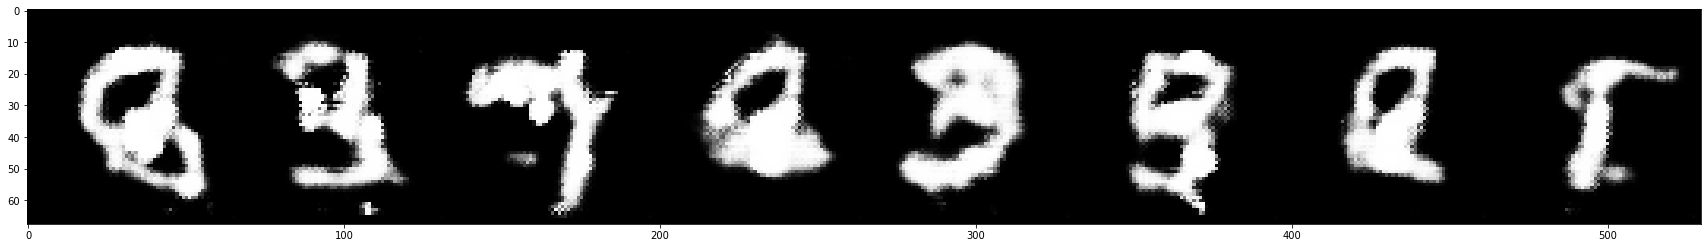

Epoch: 851 | Discriminator Loss - -0.1409023553133011 | Gradient Penalty - 0.024595659226179123 |Generator Loss - -0.5294830799102783]
Epoch: 901 | Discriminator Loss - -0.03442510962486267 | Gradient Penalty - 0.05046793818473816 |Generator Loss - -0.4383823871612549]

Epoch 67
Epoch: 51 | Discriminator Loss - -0.13992750644683838 | Gradient Penalty - 0.01988634094595909 |Generator Loss - -0.44657814502716064]
Epoch: 101 | Discriminator Loss - -0.12727713584899902 | Gradient Penalty - 0.029636893421411514 |Generator Loss - -0.42925330996513367]
Epoch: 151 | Discriminator Loss - -0.09057754278182983 | Gradient Penalty - 0.021769700571894646 |Generator Loss - -0.4186131954193115]
Epoch: 201 | Discriminator Loss - -0.14141583442687988 | Gradient Penalty - 0.024503938853740692 |Generator Loss - -0.57122802734375]
Epoch: 251 | Discriminator Loss - -0.13043761253356934 | Gradient Penalty - 0.025339484214782715 |Generator Loss - -0.48862266540527344]
Epoch: 301 | Discriminator Loss - -0.0788

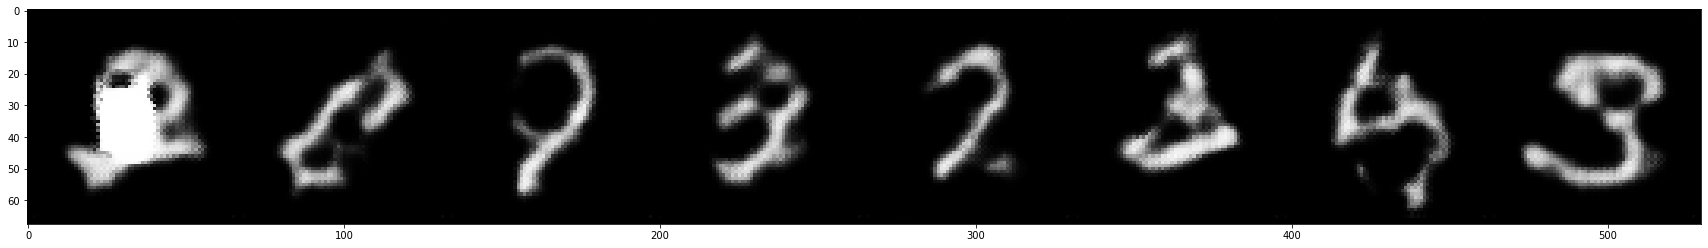

Epoch: 851 | Discriminator Loss - -0.12827683985233307 | Gradient Penalty - 0.03526194393634796 |Generator Loss - -0.5293692350387573]
Epoch: 901 | Discriminator Loss - -0.047580234706401825 | Gradient Penalty - 0.053325749933719635 |Generator Loss - -0.5022624135017395]

Epoch 68
Epoch: 51 | Discriminator Loss - -0.16413165628910065 | Gradient Penalty - 0.022859741002321243 |Generator Loss - -0.5226024985313416]
Epoch: 101 | Discriminator Loss - -0.14588937163352966 | Gradient Penalty - 0.0153108611702919 |Generator Loss - -0.5283724069595337]
Epoch: 151 | Discriminator Loss - -0.06219513714313507 | Gradient Penalty - 0.035661742091178894 |Generator Loss - -0.520969569683075]
Epoch: 201 | Discriminator Loss - -0.08314771205186844 | Gradient Penalty - 0.02301131933927536 |Generator Loss - -0.4867366552352905]
Epoch: 251 | Discriminator Loss - -0.08427203446626663 | Gradient Penalty - 0.01861822046339512 |Generator Loss - -0.44820737838745117]
Epoch: 301 | Discriminator Loss - -0.119561

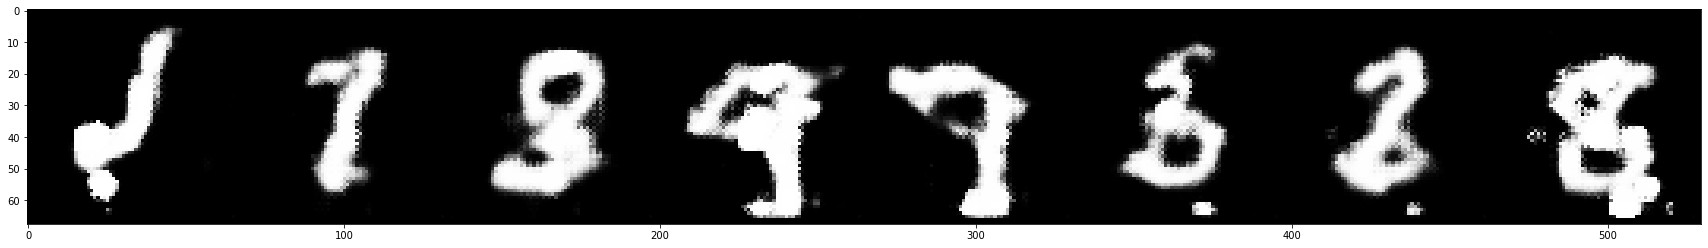

Epoch: 851 | Discriminator Loss - -0.0886722132563591 | Gradient Penalty - 0.025919919833540916 |Generator Loss - -0.48364320397377014]
Epoch: 901 | Discriminator Loss - -0.10853032767772675 | Gradient Penalty - 0.018370406702160835 |Generator Loss - -0.5116188526153564]

Epoch 69
Epoch: 51 | Discriminator Loss - -0.10401689261198044 | Gradient Penalty - 0.02330414019525051 |Generator Loss - -0.5042243003845215]
Epoch: 101 | Discriminator Loss - -0.09468434751033783 | Gradient Penalty - 0.03106864169239998 |Generator Loss - -0.5408164858818054]
Epoch: 151 | Discriminator Loss - -0.1352461576461792 | Gradient Penalty - 0.0205858014523983 |Generator Loss - -0.5100557804107666]
Epoch: 201 | Discriminator Loss - -0.1379663050174713 | Gradient Penalty - 0.02529335767030716 |Generator Loss - -0.43169867992401123]
Epoch: 251 | Discriminator Loss - -0.0814429298043251 | Gradient Penalty - 0.01758941262960434 |Generator Loss - -0.4856177568435669]
Epoch: 301 | Discriminator Loss - -0.0839527994

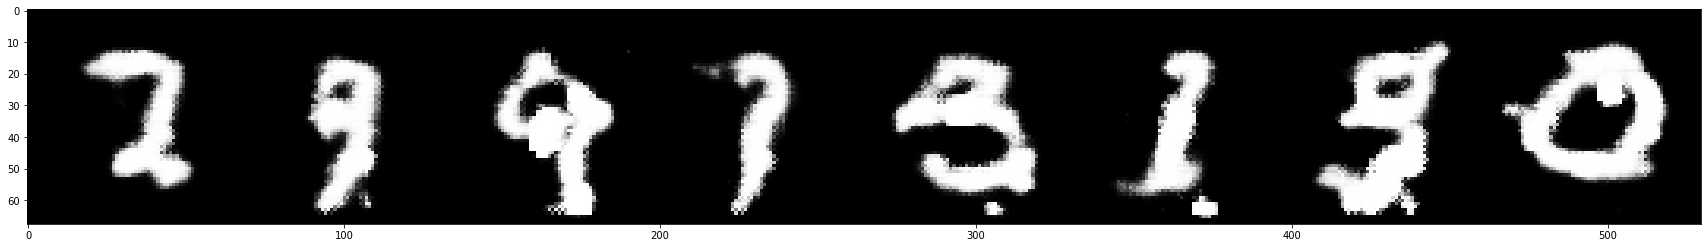

Epoch: 851 | Discriminator Loss - -0.1173153668642044 | Gradient Penalty - 0.039764512330293655 |Generator Loss - -0.44478029012680054]
Epoch: 901 | Discriminator Loss - -0.1423090100288391 | Gradient Penalty - 0.008515480905771255 |Generator Loss - -0.5158975124359131]

Epoch 70
Epoch: 51 | Discriminator Loss - -0.08933193981647491 | Gradient Penalty - 0.022271499037742615 |Generator Loss - -0.45700812339782715]
Epoch: 101 | Discriminator Loss - -0.07316292077302933 | Gradient Penalty - 0.03031652420759201 |Generator Loss - -0.5810114145278931]
Epoch: 151 | Discriminator Loss - -0.10181967914104462 | Gradient Penalty - 0.02091391757130623 |Generator Loss - -0.5955362319946289]
Epoch: 201 | Discriminator Loss - -0.14111678302288055 | Gradient Penalty - 0.038893893361091614 |Generator Loss - -0.5204408168792725]
Epoch: 251 | Discriminator Loss - -0.09070281684398651 | Gradient Penalty - 0.04169894754886627 |Generator Loss - -0.45522230863571167]
Epoch: 301 | Discriminator Loss - -0.1148

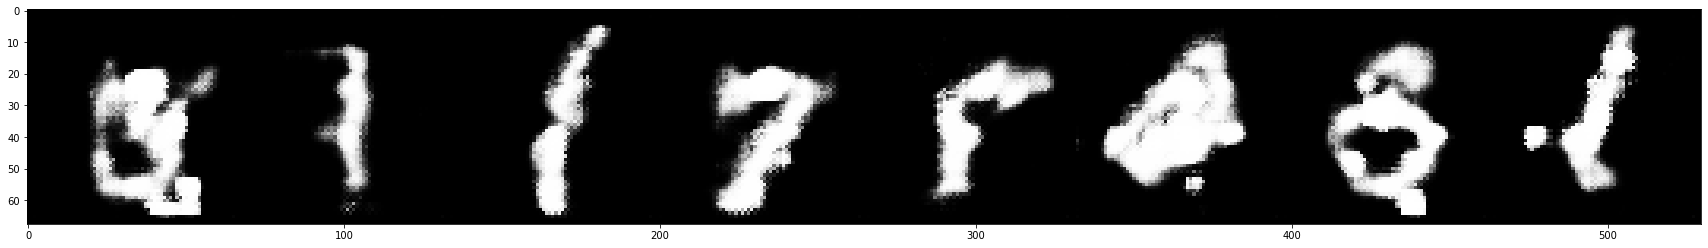

Epoch: 851 | Discriminator Loss - -0.10156799852848053 | Gradient Penalty - 0.03774164244532585 |Generator Loss - -0.567645788192749]
Epoch: 901 | Discriminator Loss - -0.0957345962524414 | Gradient Penalty - 0.042902376502752304 |Generator Loss - -0.43589699268341064]

Epoch 71
Epoch: 51 | Discriminator Loss - -0.07095871865749359 | Gradient Penalty - 0.026155073195695877 |Generator Loss - -0.5370541214942932]
Epoch: 101 | Discriminator Loss - -0.12460951507091522 | Gradient Penalty - 0.019005250185728073 |Generator Loss - -0.4906472861766815]
Epoch: 151 | Discriminator Loss - -0.13481883704662323 | Gradient Penalty - 0.03025086782872677 |Generator Loss - -0.4715551733970642]
Epoch: 201 | Discriminator Loss - -0.12274319678544998 | Gradient Penalty - 0.017258159816265106 |Generator Loss - -0.45171886682510376]
Epoch: 251 | Discriminator Loss - -0.05212812125682831 | Gradient Penalty - 0.03117392770946026 |Generator Loss - -0.4854287803173065]
Epoch: 301 | Discriminator Loss - -0.07094

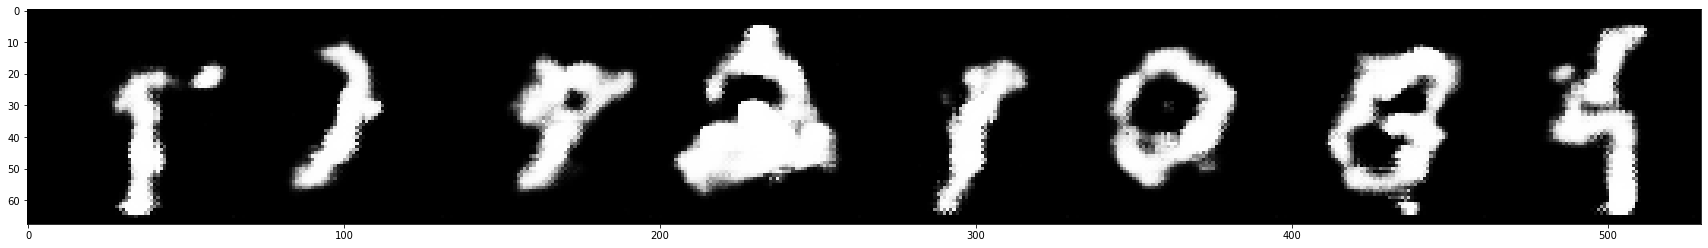

Epoch: 851 | Discriminator Loss - -0.06992018967866898 | Gradient Penalty - 0.06421499699354172 |Generator Loss - -0.5516703724861145]
Epoch: 901 | Discriminator Loss - -0.11727973818778992 | Gradient Penalty - 0.0123347332701087 |Generator Loss - -0.5030600428581238]

Epoch 72
Epoch: 51 | Discriminator Loss - -0.08876557648181915 | Gradient Penalty - 0.046148527413606644 |Generator Loss - -0.5009794235229492]
Epoch: 101 | Discriminator Loss - -0.12203998863697052 | Gradient Penalty - 0.028015930205583572 |Generator Loss - -0.5691772103309631]
Epoch: 151 | Discriminator Loss - -0.12142407894134521 | Gradient Penalty - 0.017781134694814682 |Generator Loss - -0.5634880065917969]
Epoch: 201 | Discriminator Loss - -0.08940324187278748 | Gradient Penalty - 0.01803966984152794 |Generator Loss - -0.4924810230731964]
Epoch: 251 | Discriminator Loss - -0.12391069531440735 | Gradient Penalty - 0.015825480222702026 |Generator Loss - -0.5122557878494263]
Epoch: 301 | Discriminator Loss - -0.108558

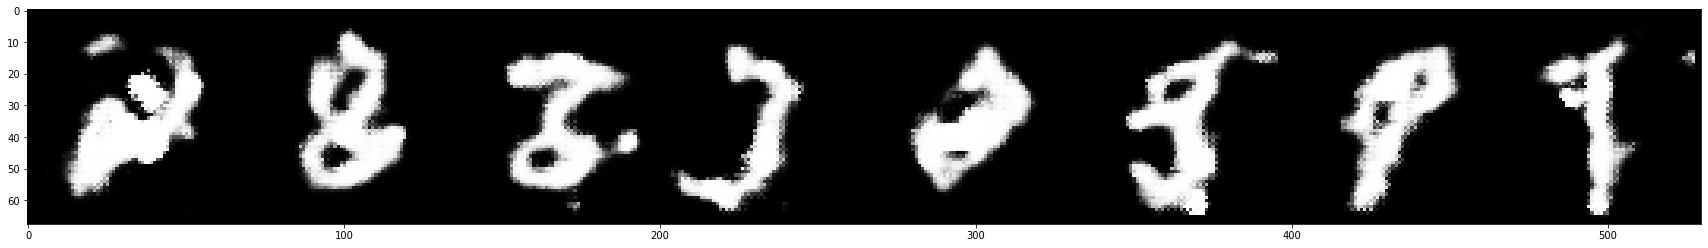

Epoch: 851 | Discriminator Loss - -0.10919179767370224 | Gradient Penalty - 0.01998654566705227 |Generator Loss - -0.5160516500473022]
Epoch: 901 | Discriminator Loss - -0.09709346294403076 | Gradient Penalty - 0.010959271341562271 |Generator Loss - -0.5272098779678345]

Epoch 73
Epoch: 51 | Discriminator Loss - -0.10923099517822266 | Gradient Penalty - 0.025725722312927246 |Generator Loss - -0.5332740545272827]
Epoch: 101 | Discriminator Loss - -0.09121020138263702 | Gradient Penalty - 0.0164627842605114 |Generator Loss - -0.4990861713886261]
Epoch: 151 | Discriminator Loss - -0.1053461879491806 | Gradient Penalty - 0.014870364218950272 |Generator Loss - -0.5747445821762085]
Epoch: 201 | Discriminator Loss - -0.13890716433525085 | Gradient Penalty - 0.026314523071050644 |Generator Loss - -0.517792820930481]
Epoch: 251 | Discriminator Loss - -0.12739631533622742 | Gradient Penalty - 0.03631165623664856 |Generator Loss - -0.5749061107635498]
Epoch: 301 | Discriminator Loss - -0.11520911

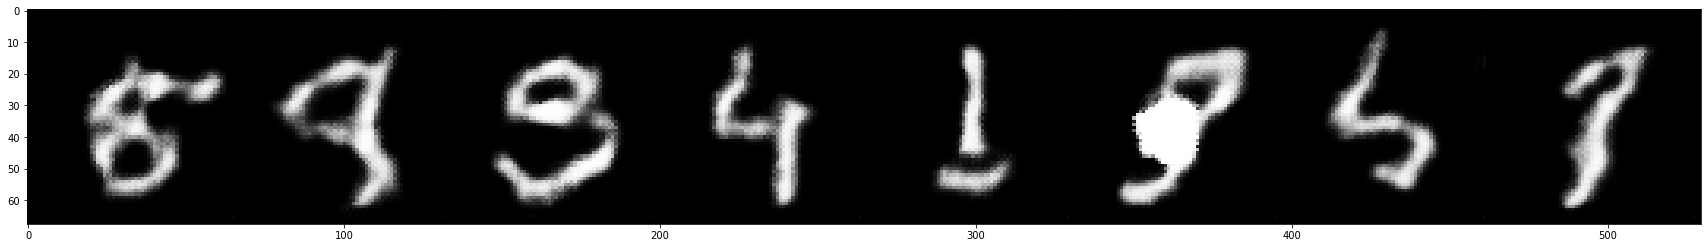

Epoch: 851 | Discriminator Loss - -0.0818168967962265 | Gradient Penalty - 0.020073488354682922 |Generator Loss - -0.5393983125686646]
Epoch: 901 | Discriminator Loss - -0.10449445247650146 | Gradient Penalty - 0.0317685641348362 |Generator Loss - -0.5180869102478027]

Epoch 74
Epoch: 51 | Discriminator Loss - -0.08113441616296768 | Gradient Penalty - 0.01728024333715439 |Generator Loss - -0.5116963386535645]
Epoch: 101 | Discriminator Loss - -0.11036346852779388 | Gradient Penalty - 0.01711900904774666 |Generator Loss - -0.43122535943984985]
Epoch: 151 | Discriminator Loss - -0.15342171490192413 | Gradient Penalty - 0.013757279142737389 |Generator Loss - -0.4127153158187866]
Epoch: 201 | Discriminator Loss - -0.10185191035270691 | Gradient Penalty - 0.029219835996627808 |Generator Loss - -0.4319380223751068]
Epoch: 251 | Discriminator Loss - -0.0768650695681572 | Gradient Penalty - 0.032274700701236725 |Generator Loss - -0.4722931683063507]
Epoch: 301 | Discriminator Loss - -0.1029458

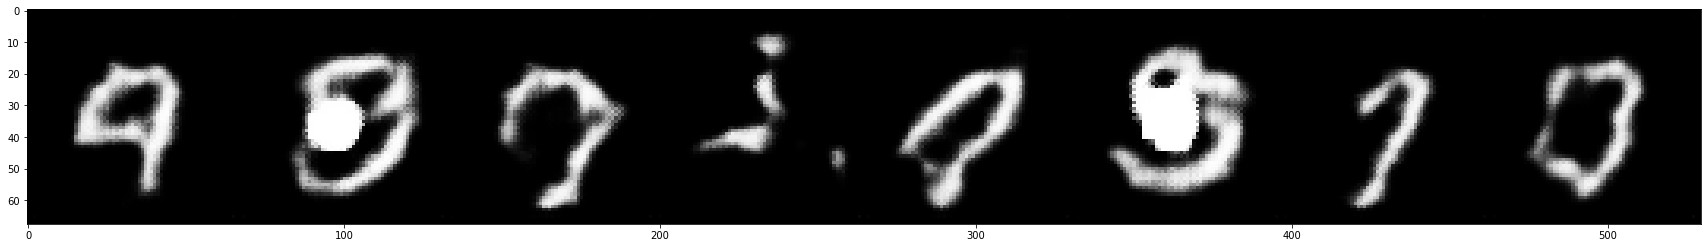

Epoch: 851 | Discriminator Loss - -0.1272517740726471 | Gradient Penalty - 0.024070896208286285 |Generator Loss - -0.44488948583602905]
Epoch: 901 | Discriminator Loss - -0.08733079582452774 | Gradient Penalty - 0.09760793298482895 |Generator Loss - -0.4983835816383362]

Epoch 75
Epoch: 51 | Discriminator Loss - -0.09876186400651932 | Gradient Penalty - 0.026309126988053322 |Generator Loss - -0.5833559632301331]
Epoch: 101 | Discriminator Loss - 0.0038930997252464294 | Gradient Penalty - 0.09210988134145737 |Generator Loss - -0.5334940552711487]
Epoch: 151 | Discriminator Loss - -0.05987091362476349 | Gradient Penalty - 0.029332561418414116 |Generator Loss - -0.501215934753418]
Epoch: 201 | Discriminator Loss - -0.11288560181856155 | Gradient Penalty - 0.021348586305975914 |Generator Loss - -0.4741177558898926]
Epoch: 251 | Discriminator Loss - -0.09792353212833405 | Gradient Penalty - 0.04884485900402069 |Generator Loss - -0.42594414949417114]
Epoch: 301 | Discriminator Loss - -0.1180

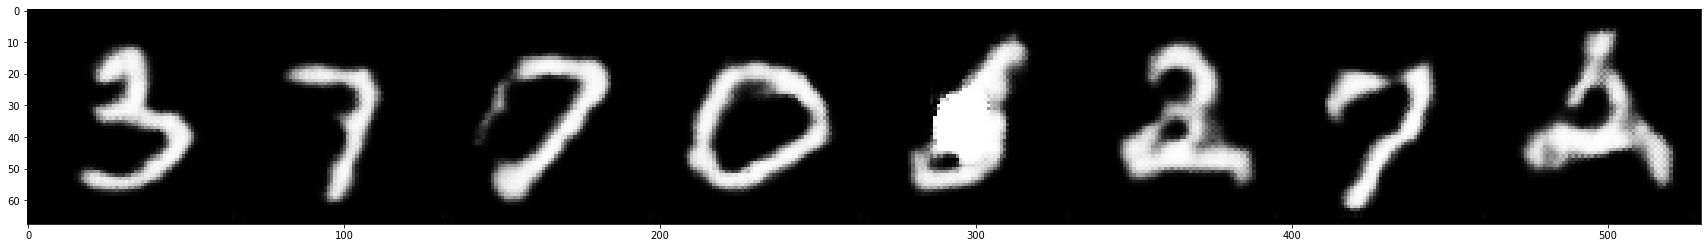

Epoch: 851 | Discriminator Loss - -0.0793011337518692 | Gradient Penalty - 0.033892352133989334 |Generator Loss - -0.5286930799484253]
Epoch: 901 | Discriminator Loss - -0.07908548414707184 | Gradient Penalty - 0.03733859956264496 |Generator Loss - -0.5117476582527161]

Epoch 76
Epoch: 51 | Discriminator Loss - -0.07290757447481155 | Gradient Penalty - 0.0651775524020195 |Generator Loss - -0.4756469130516052]
Epoch: 101 | Discriminator Loss - -0.10843557864427567 | Gradient Penalty - 0.02232353948056698 |Generator Loss - -0.4772244095802307]
Epoch: 151 | Discriminator Loss - -0.07137273252010345 | Gradient Penalty - 0.05967225506901741 |Generator Loss - -0.4644245207309723]
Epoch: 201 | Discriminator Loss - -0.10066094994544983 | Gradient Penalty - 0.03324410319328308 |Generator Loss - -0.5200150012969971]
Epoch: 251 | Discriminator Loss - -0.07142410427331924 | Gradient Penalty - 0.026166999712586403 |Generator Loss - -0.563353419303894]
Epoch: 301 | Discriminator Loss - -0.1417767107

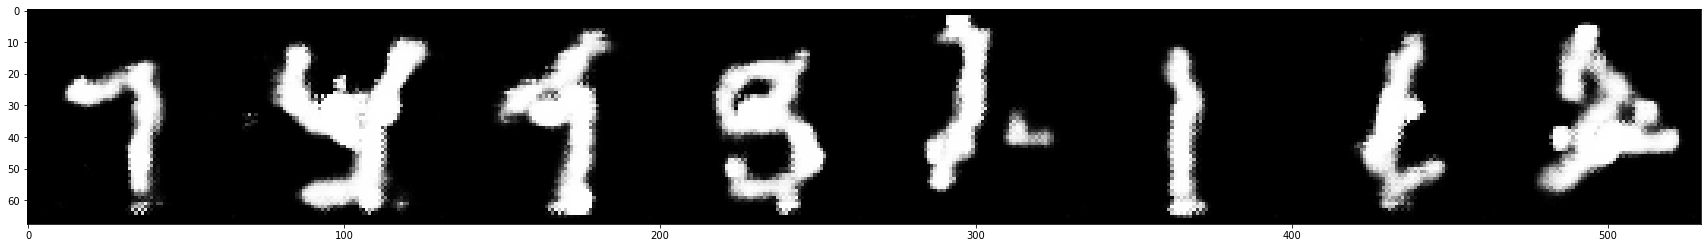

Epoch: 851 | Discriminator Loss - -0.09285976737737656 | Gradient Penalty - 0.026525715366005898 |Generator Loss - -0.5222062468528748]
Epoch: 901 | Discriminator Loss - -0.07937999069690704 | Gradient Penalty - 0.054618194699287415 |Generator Loss - -0.4686196744441986]

Epoch 77
Epoch: 51 | Discriminator Loss - -0.06574831902980804 | Gradient Penalty - 0.041459158062934875 |Generator Loss - -0.5057907700538635]
Epoch: 101 | Discriminator Loss - -0.11453333497047424 | Gradient Penalty - 0.028356583788990974 |Generator Loss - -0.5437566637992859]
Epoch: 151 | Discriminator Loss - -0.1207309365272522 | Gradient Penalty - 0.043340083211660385 |Generator Loss - -0.4844121038913727]
Epoch: 201 | Discriminator Loss - -0.088168665766716 | Gradient Penalty - 0.020123915746808052 |Generator Loss - -0.5009799003601074]
Epoch: 251 | Discriminator Loss - -0.08578527718782425 | Gradient Penalty - 0.026782145723700523 |Generator Loss - -0.5021491050720215]
Epoch: 301 | Discriminator Loss - -0.14351

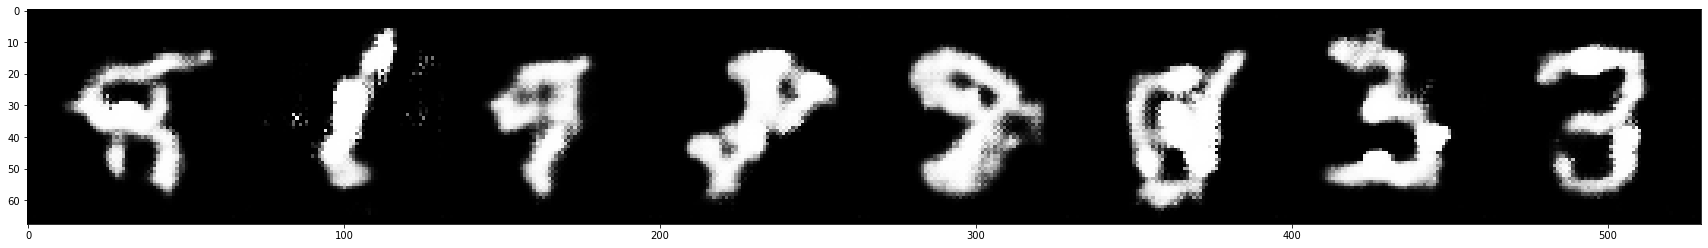

Epoch: 851 | Discriminator Loss - -0.10333102941513062 | Gradient Penalty - 0.03212621808052063 |Generator Loss - -0.5070945024490356]
Epoch: 901 | Discriminator Loss - -0.08960448205471039 | Gradient Penalty - 0.02073713019490242 |Generator Loss - -0.4762710928916931]

Epoch 78
Epoch: 51 | Discriminator Loss - -0.13043779134750366 | Gradient Penalty - 0.028642773628234863 |Generator Loss - -0.5100928544998169]
Epoch: 101 | Discriminator Loss - -0.12264730036258698 | Gradient Penalty - 0.025057833641767502 |Generator Loss - -0.5645365715026855]
Epoch: 151 | Discriminator Loss - -0.05398653447628021 | Gradient Penalty - 0.05659551918506622 |Generator Loss - -0.5062761306762695]
Epoch: 201 | Discriminator Loss - -0.09012511372566223 | Gradient Penalty - 0.028158515691757202 |Generator Loss - -0.49564260244369507]
Epoch: 251 | Discriminator Loss - -0.12826919555664062 | Gradient Penalty - 0.02996748499572277 |Generator Loss - -0.44524356722831726]
Epoch: 301 | Discriminator Loss - -0.0962

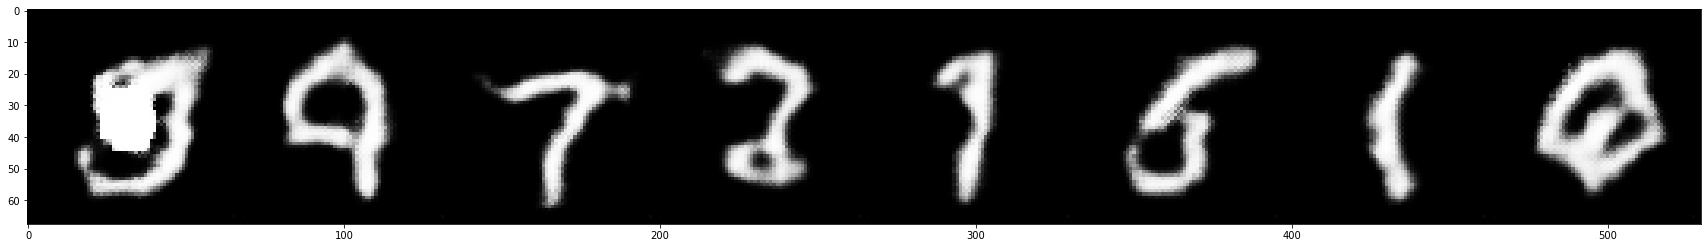

Epoch: 851 | Discriminator Loss - -0.0977712869644165 | Gradient Penalty - 0.03207147493958473 |Generator Loss - -0.5622878074645996]
Epoch: 901 | Discriminator Loss - -0.1259087324142456 | Gradient Penalty - 0.03417176008224487 |Generator Loss - -0.5177090167999268]

Epoch 79
Epoch: 51 | Discriminator Loss - -0.08451049029827118 | Gradient Penalty - 0.02615697868168354 |Generator Loss - -0.4317534267902374]
Epoch: 101 | Discriminator Loss - -0.10440146923065186 | Gradient Penalty - 0.022686000913381577 |Generator Loss - -0.4756869673728943]
Epoch: 151 | Discriminator Loss - -0.17933358252048492 | Gradient Penalty - 0.03328142687678337 |Generator Loss - -0.5275585651397705]
Epoch: 201 | Discriminator Loss - -0.15170389413833618 | Gradient Penalty - 0.021438952535390854 |Generator Loss - -0.537047803401947]
Epoch: 251 | Discriminator Loss - -0.0944327712059021 | Gradient Penalty - 0.017511073499917984 |Generator Loss - -0.5210466384887695]
Epoch: 301 | Discriminator Loss - -0.0984777435

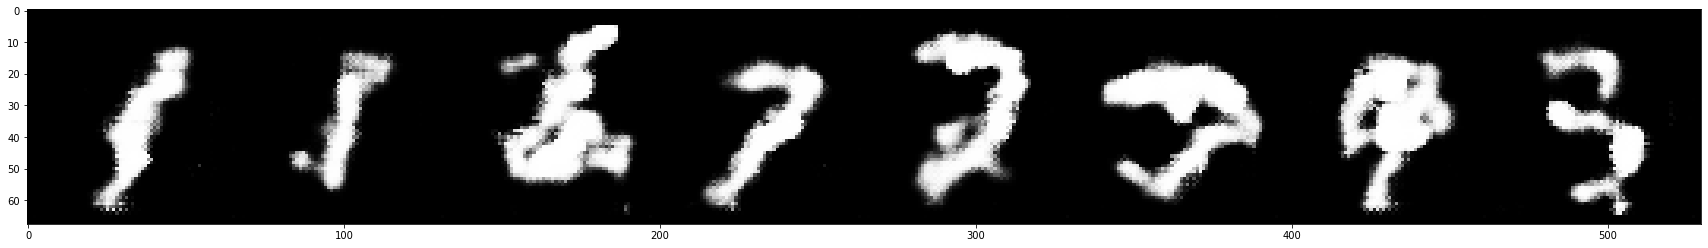

Epoch: 851 | Discriminator Loss - -0.10990387201309204 | Gradient Penalty - 0.024783309549093246 |Generator Loss - -0.5183640122413635]
Epoch: 901 | Discriminator Loss - -0.11973458528518677 | Gradient Penalty - 0.029737595468759537 |Generator Loss - -0.5522677898406982]

Epoch 80
Epoch: 51 | Discriminator Loss - -0.10540325194597244 | Gradient Penalty - 0.01977812685072422 |Generator Loss - -0.5445425510406494]
Epoch: 101 | Discriminator Loss - -0.13535475730895996 | Gradient Penalty - 0.0269392691552639 |Generator Loss - -0.47330254316329956]
Epoch: 151 | Discriminator Loss - -0.08056937158107758 | Gradient Penalty - 0.03933669626712799 |Generator Loss - -0.4437449872493744]
Epoch: 201 | Discriminator Loss - -0.07924550771713257 | Gradient Penalty - 0.017280995845794678 |Generator Loss - -0.49379608035087585]
Epoch: 251 | Discriminator Loss - -0.1341884881258011 | Gradient Penalty - 0.039907973259687424 |Generator Loss - -0.5396791696548462]
Epoch: 301 | Discriminator Loss - -0.16804

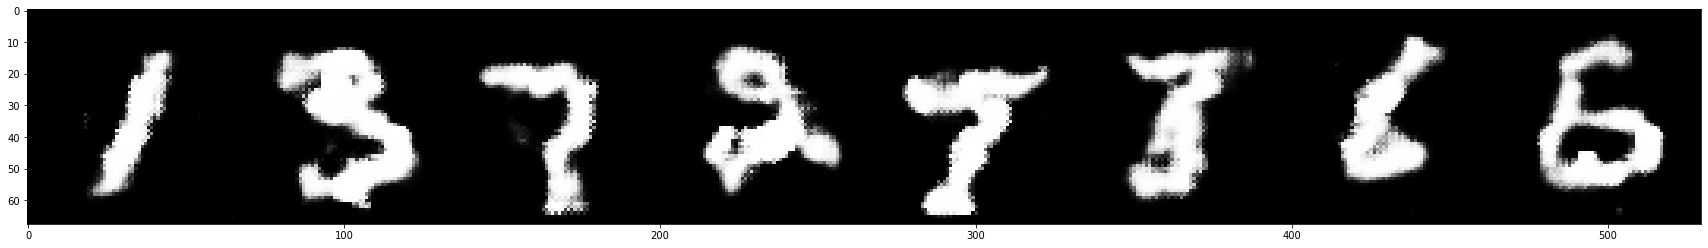

Epoch: 851 | Discriminator Loss - -0.1489727646112442 | Gradient Penalty - 0.027806054800748825 |Generator Loss - -0.4580168128013611]
Epoch: 901 | Discriminator Loss - -0.13253656029701233 | Gradient Penalty - 0.024160150438547134 |Generator Loss - -0.447672963142395]

Epoch 81
Epoch: 51 | Discriminator Loss - -0.11446510255336761 | Gradient Penalty - 0.026688408106565475 |Generator Loss - -0.4443051815032959]
Epoch: 101 | Discriminator Loss - -0.10280842334032059 | Gradient Penalty - 0.025203878059983253 |Generator Loss - -0.5412207841873169]
Epoch: 151 | Discriminator Loss - -0.1023545041680336 | Gradient Penalty - 0.040966831147670746 |Generator Loss - -0.502389132976532]
Epoch: 201 | Discriminator Loss - -0.12329250574111938 | Gradient Penalty - 0.030980883166193962 |Generator Loss - -0.5296106338500977]
Epoch: 251 | Discriminator Loss - -0.12191778421401978 | Gradient Penalty - 0.054839253425598145 |Generator Loss - -0.416475772857666]
Epoch: 301 | Discriminator Loss - -0.1011372

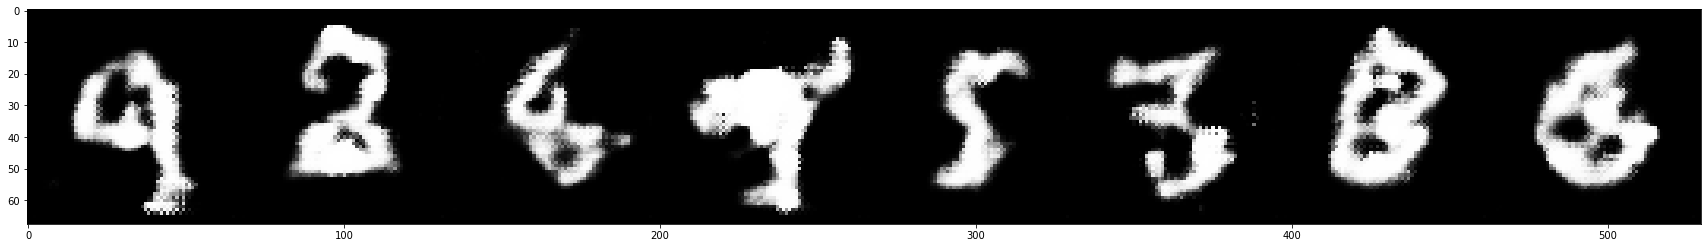

Epoch: 851 | Discriminator Loss - -0.0817485898733139 | Gradient Penalty - 0.022340845316648483 |Generator Loss - -0.5462448000907898]
Epoch: 901 | Discriminator Loss - -0.10578419268131256 | Gradient Penalty - 0.012784641236066818 |Generator Loss - -0.4970369040966034]

Epoch 82
Epoch: 51 | Discriminator Loss - -0.14777584373950958 | Gradient Penalty - 0.015040268190205097 |Generator Loss - -0.4418441653251648]
Epoch: 101 | Discriminator Loss - -0.062136728316545486 | Gradient Penalty - 0.029994379729032516 |Generator Loss - -0.4553239345550537]
Epoch: 151 | Discriminator Loss - -0.12470948696136475 | Gradient Penalty - 0.03665745630860329 |Generator Loss - -0.5252746343612671]
Epoch: 201 | Discriminator Loss - -0.1355961710214615 | Gradient Penalty - 0.04098008945584297 |Generator Loss - -0.5373339653015137]
Epoch: 251 | Discriminator Loss - -0.1300409734249115 | Gradient Penalty - 0.021716929972171783 |Generator Loss - -0.5918374061584473]
Epoch: 301 | Discriminator Loss - -0.080585

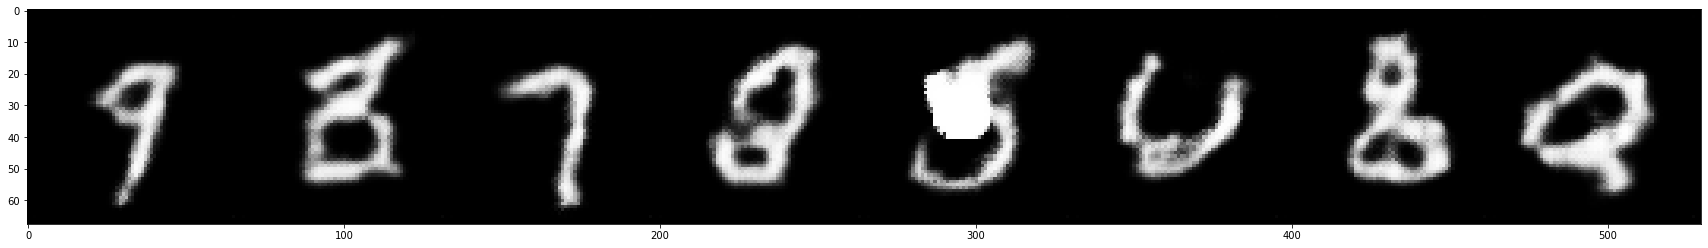

Epoch: 851 | Discriminator Loss - -0.08713160455226898 | Gradient Penalty - 0.020406018942594528 |Generator Loss - -0.4779738783836365]
Epoch: 901 | Discriminator Loss - -0.05308659374713898 | Gradient Penalty - 0.02968733198940754 |Generator Loss - -0.49469679594039917]

Epoch 83
Epoch: 51 | Discriminator Loss - -0.11058701574802399 | Gradient Penalty - 0.022101925686001778 |Generator Loss - -0.5189627408981323]
Epoch: 101 | Discriminator Loss - -0.12866434454917908 | Gradient Penalty - 0.014297936111688614 |Generator Loss - -0.5084773302078247]
Epoch: 151 | Discriminator Loss - -0.12175934761762619 | Gradient Penalty - 0.040008820593357086 |Generator Loss - -0.476375550031662]
Epoch: 201 | Discriminator Loss - -0.08669827878475189 | Gradient Penalty - 0.01772431842982769 |Generator Loss - -0.5084607005119324]
Epoch: 251 | Discriminator Loss - -0.08594243973493576 | Gradient Penalty - 0.015178806148469448 |Generator Loss - -0.5163965821266174]
Epoch: 301 | Discriminator Loss - -0.1286

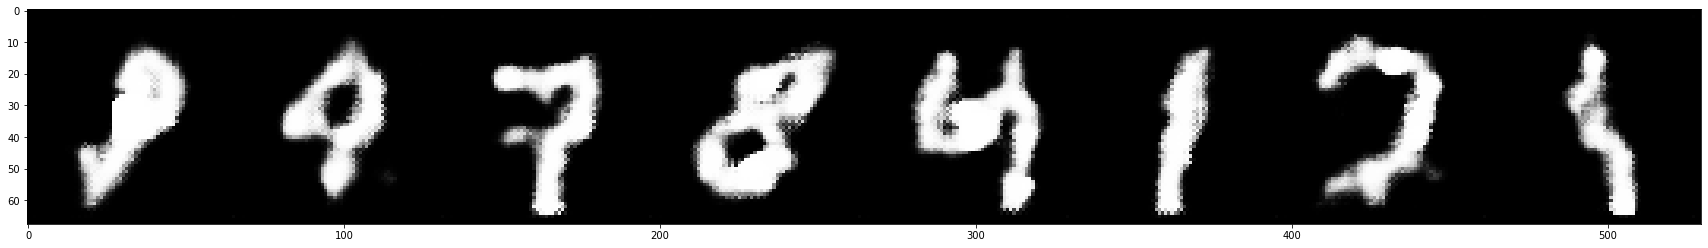

Epoch: 851 | Discriminator Loss - -0.13982167840003967 | Gradient Penalty - 0.035020019859075546 |Generator Loss - -0.4166884422302246]
Epoch: 901 | Discriminator Loss - -0.0995488315820694 | Gradient Penalty - 0.02055416814982891 |Generator Loss - -0.4619324803352356]

Epoch 84
Epoch: 51 | Discriminator Loss - -0.15151333808898926 | Gradient Penalty - 0.026974551379680634 |Generator Loss - -0.4665432870388031]
Epoch: 101 | Discriminator Loss - -0.12910345196723938 | Gradient Penalty - 0.023812735453248024 |Generator Loss - -0.5787065029144287]
Epoch: 151 | Discriminator Loss - -0.08637363463640213 | Gradient Penalty - 0.05334746092557907 |Generator Loss - -0.4938701391220093]
Epoch: 201 | Discriminator Loss - -0.1100563108921051 | Gradient Penalty - 0.014831755310297012 |Generator Loss - -0.553817868232727]
Epoch: 251 | Discriminator Loss - -0.10907157510519028 | Gradient Penalty - 0.028979606926441193 |Generator Loss - -0.44641348719596863]
Epoch: 301 | Discriminator Loss - -0.118224

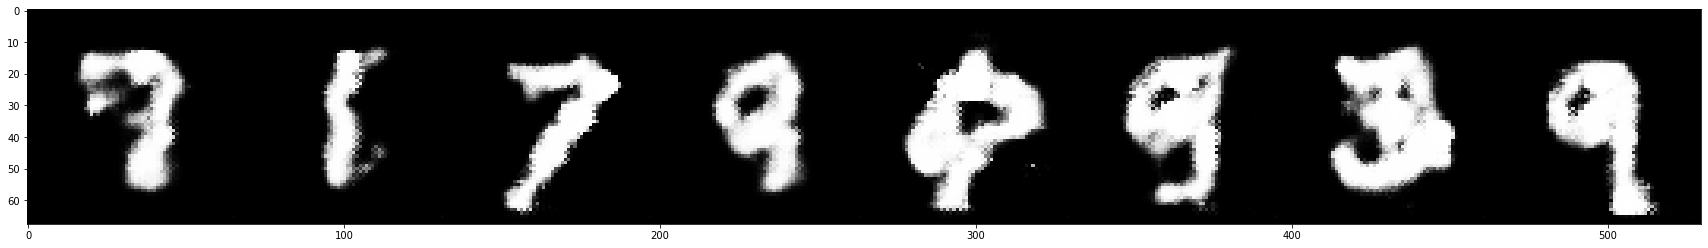

Epoch: 851 | Discriminator Loss - -0.1697925329208374 | Gradient Penalty - 0.04106009006500244 |Generator Loss - -0.5689345598220825]
Epoch: 901 | Discriminator Loss - -0.11476226150989532 | Gradient Penalty - 0.023756787180900574 |Generator Loss - -0.4622034430503845]

Epoch 85
Epoch: 51 | Discriminator Loss - -0.10119207203388214 | Gradient Penalty - 0.04136351868510246 |Generator Loss - -0.43132609128952026]
Epoch: 101 | Discriminator Loss - -0.11273162811994553 | Gradient Penalty - 0.020196564495563507 |Generator Loss - -0.5403993725776672]
Epoch: 151 | Discriminator Loss - -0.10098696500062943 | Gradient Penalty - 0.041723303496837616 |Generator Loss - -0.5292688608169556]
Epoch: 201 | Discriminator Loss - -0.11106838285923004 | Gradient Penalty - 0.041517481207847595 |Generator Loss - -0.4247874915599823]
Epoch: 251 | Discriminator Loss - -0.07366102188825607 | Gradient Penalty - 0.05383700877428055 |Generator Loss - -0.5732855796813965]
Epoch: 301 | Discriminator Loss - -0.09541

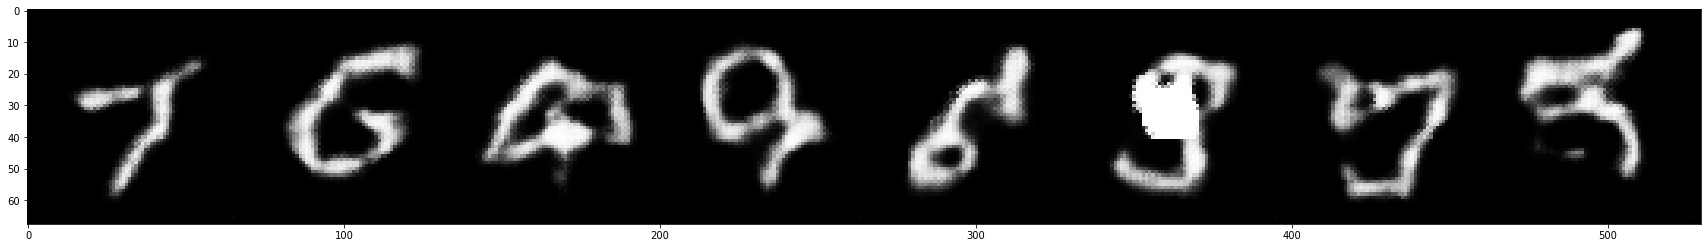

Epoch: 851 | Discriminator Loss - -0.04824759066104889 | Gradient Penalty - 0.08417628705501556 |Generator Loss - -0.5371257066726685]
Epoch: 901 | Discriminator Loss - -0.11528648436069489 | Gradient Penalty - 0.05475275218486786 |Generator Loss - -0.4840885400772095]

Epoch 86
Epoch: 51 | Discriminator Loss - -0.1296544075012207 | Gradient Penalty - 0.029189027845859528 |Generator Loss - -0.5130742788314819]
Epoch: 101 | Discriminator Loss - -0.13373731076717377 | Gradient Penalty - 0.03684265911579132 |Generator Loss - -0.4685797095298767]
Epoch: 151 | Discriminator Loss - -0.09572658687829971 | Gradient Penalty - 0.022311052307486534 |Generator Loss - -0.4649471640586853]
Epoch: 201 | Discriminator Loss - -0.04890073090791702 | Gradient Penalty - 0.0704955980181694 |Generator Loss - -0.5944110751152039]
Epoch: 251 | Discriminator Loss - -0.10920535773038864 | Gradient Penalty - 0.06861967593431473 |Generator Loss - -0.5212528705596924]
Epoch: 301 | Discriminator Loss - -0.113030843

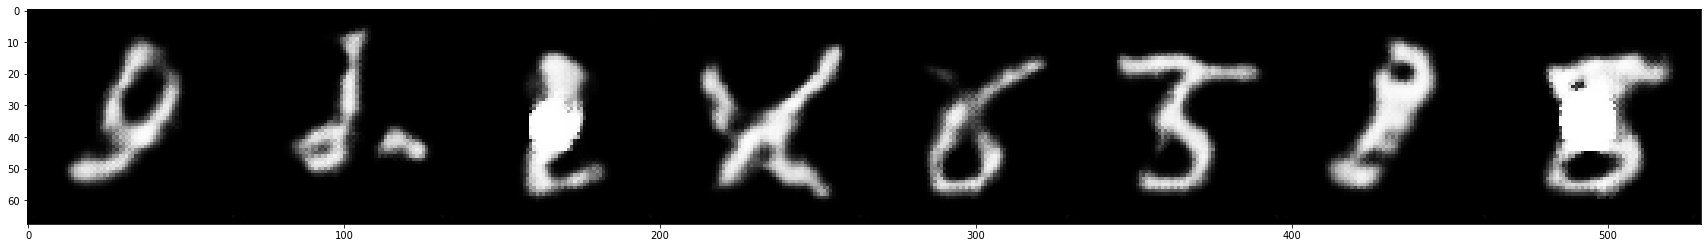

Epoch: 851 | Discriminator Loss - -0.06505262106657028 | Gradient Penalty - 0.026575155556201935 |Generator Loss - -0.46310311555862427]
Epoch: 901 | Discriminator Loss - -0.112917959690094 | Gradient Penalty - 0.018747445195913315 |Generator Loss - -0.5252833366394043]

Epoch 87
Epoch: 51 | Discriminator Loss - -0.021720312535762787 | Gradient Penalty - 0.06980059295892715 |Generator Loss - -0.4118803143501282]
Epoch: 101 | Discriminator Loss - -0.073025181889534 | Gradient Penalty - 0.02161167748272419 |Generator Loss - -0.5549722909927368]
Epoch: 151 | Discriminator Loss - -0.134381964802742 | Gradient Penalty - 0.030301671475172043 |Generator Loss - -0.41271334886550903]
Epoch: 201 | Discriminator Loss - -0.0846109539270401 | Gradient Penalty - 0.044402290135622025 |Generator Loss - -0.4215635061264038]
Epoch: 251 | Discriminator Loss - -0.08147118240594864 | Gradient Penalty - 0.020851992070674896 |Generator Loss - -0.5012438297271729]
Epoch: 301 | Discriminator Loss - -0.14100480

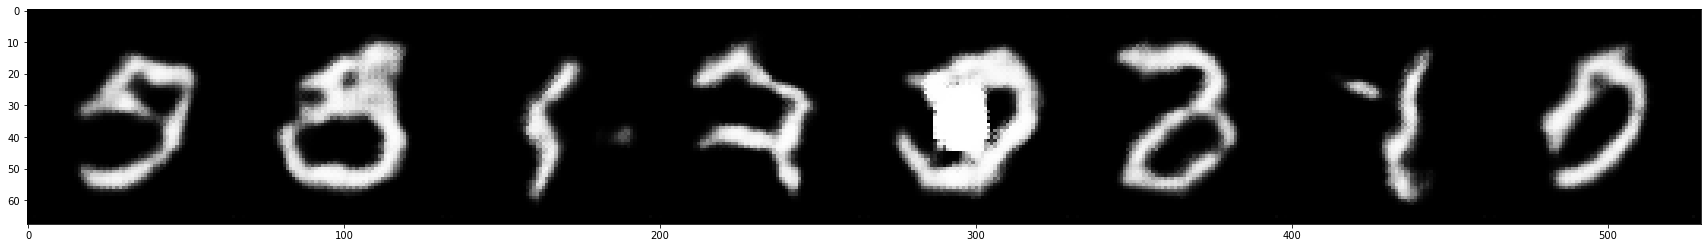

Epoch: 851 | Discriminator Loss - -0.04930787533521652 | Gradient Penalty - 0.08795887976884842 |Generator Loss - -0.40176838636398315]
Epoch: 901 | Discriminator Loss - -0.11478173732757568 | Gradient Penalty - 0.029306594282388687 |Generator Loss - -0.43694740533828735]

Epoch 88
Epoch: 51 | Discriminator Loss - -0.0868384912610054 | Gradient Penalty - 0.04196672886610031 |Generator Loss - -0.48488494753837585]
Epoch: 101 | Discriminator Loss - -0.07241105288267136 | Gradient Penalty - 0.03591743856668472 |Generator Loss - -0.5684690475463867]
Epoch: 151 | Discriminator Loss - -0.08232514560222626 | Gradient Penalty - 0.02372892200946808 |Generator Loss - -0.4996141493320465]
Epoch: 201 | Discriminator Loss - -0.14302384853363037 | Gradient Penalty - 0.034508056938648224 |Generator Loss - -0.3983999490737915]
Epoch: 251 | Discriminator Loss - -0.08855018019676208 | Gradient Penalty - 0.029246505349874496 |Generator Loss - -0.4546334743499756]
Epoch: 301 | Discriminator Loss - -0.0806

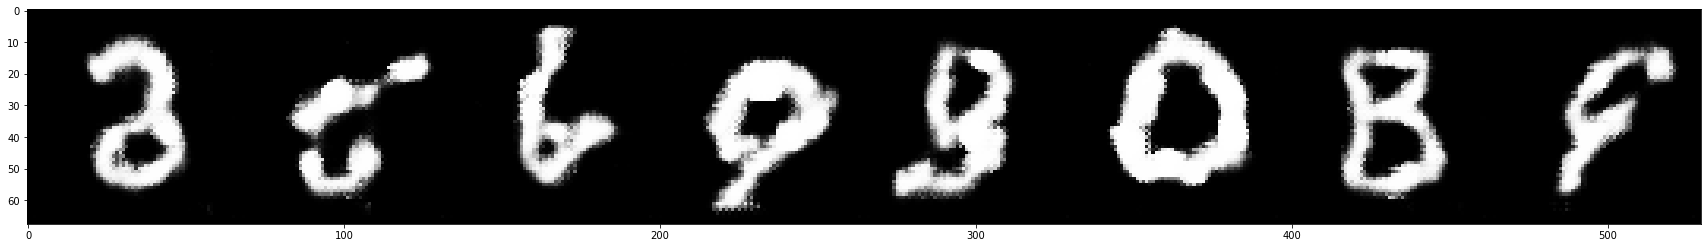

Epoch: 851 | Discriminator Loss - -0.12794539332389832 | Gradient Penalty - 0.0282495878636837 |Generator Loss - -0.453343003988266]
Epoch: 901 | Discriminator Loss - -0.11929193884134293 | Gradient Penalty - 0.03489484637975693 |Generator Loss - -0.4997914433479309]

Epoch 89
Epoch: 51 | Discriminator Loss - -0.14002548158168793 | Gradient Penalty - 0.02620725892484188 |Generator Loss - -0.4832145571708679]
Epoch: 101 | Discriminator Loss - -0.13823921978473663 | Gradient Penalty - 0.01912049762904644 |Generator Loss - -0.5524404644966125]
Epoch: 151 | Discriminator Loss - -0.11614489555358887 | Gradient Penalty - 0.01813262514770031 |Generator Loss - -0.5075903534889221]
Epoch: 201 | Discriminator Loss - -0.02444589138031006 | Gradient Penalty - 0.16060012578964233 |Generator Loss - -0.5521284341812134]
Epoch: 251 | Discriminator Loss - -0.12109021097421646 | Gradient Penalty - 0.04386749118566513 |Generator Loss - -0.507299542427063]
Epoch: 301 | Discriminator Loss - -0.071514695882

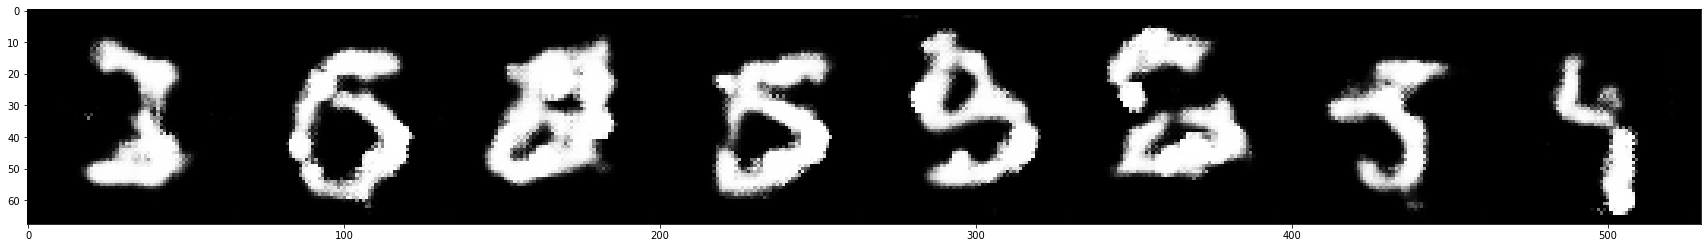

Epoch: 851 | Discriminator Loss - -0.11512276530265808 | Gradient Penalty - 0.022462453693151474 |Generator Loss - -0.5626214742660522]
Epoch: 901 | Discriminator Loss - -0.12406884878873825 | Gradient Penalty - 0.011711185798048973 |Generator Loss - -0.46092674136161804]

Epoch 90
Epoch: 51 | Discriminator Loss - -0.12093466520309448 | Gradient Penalty - 0.04043165221810341 |Generator Loss - -0.4847257137298584]
Epoch: 101 | Discriminator Loss - -0.06851660460233688 | Gradient Penalty - 0.026675410568714142 |Generator Loss - -0.48532068729400635]
Epoch: 151 | Discriminator Loss - -0.030546430498361588 | Gradient Penalty - 0.03309011086821556 |Generator Loss - -0.5972591638565063]
Epoch: 201 | Discriminator Loss - -0.12748539447784424 | Gradient Penalty - 0.023719422519207 |Generator Loss - -0.5136046409606934]
Epoch: 251 | Discriminator Loss - -0.10329334437847137 | Gradient Penalty - 0.030783994123339653 |Generator Loss - -0.40283703804016113]
Epoch: 301 | Discriminator Loss - -0.092

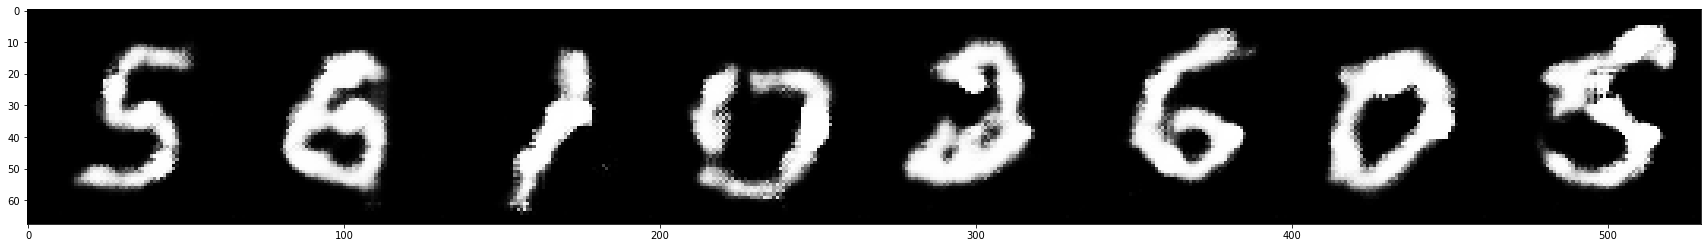

Epoch: 851 | Discriminator Loss - -0.08296682685613632 | Gradient Penalty - 0.024691201746463776 |Generator Loss - -0.5085742473602295]
Epoch: 901 | Discriminator Loss - -0.15510761737823486 | Gradient Penalty - 0.022178413346409798 |Generator Loss - -0.4928620755672455]

Epoch 91
Epoch: 51 | Discriminator Loss - -0.09945735335350037 | Gradient Penalty - 0.013387652114033699 |Generator Loss - -0.5598034858703613]
Epoch: 101 | Discriminator Loss - -0.04404255747795105 | Gradient Penalty - 0.02859083004295826 |Generator Loss - -0.5291368961334229]
Epoch: 151 | Discriminator Loss - -0.09968682378530502 | Gradient Penalty - 0.035831041634082794 |Generator Loss - -0.39762187004089355]
Epoch: 201 | Discriminator Loss - -0.07279613614082336 | Gradient Penalty - 0.028328148648142815 |Generator Loss - -0.46393436193466187]
Epoch: 251 | Discriminator Loss - -0.09144298732280731 | Gradient Penalty - 0.03230448067188263 |Generator Loss - -0.44118642807006836]
Epoch: 301 | Discriminator Loss - -0.1

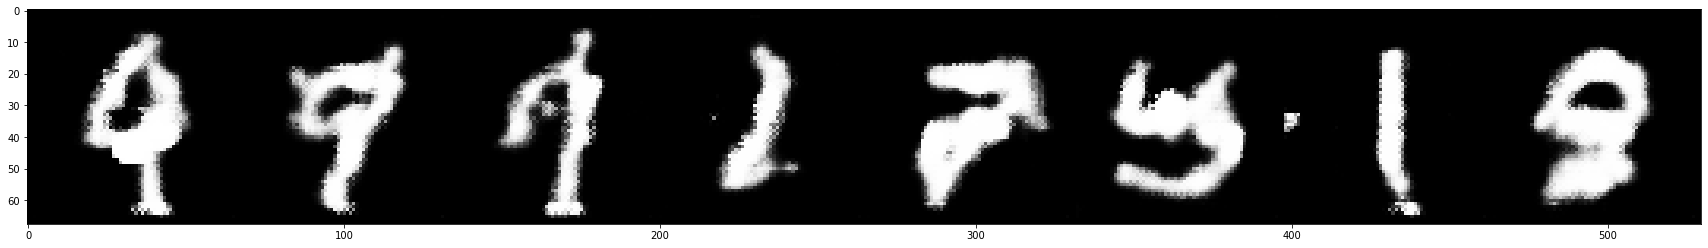

Epoch: 851 | Discriminator Loss - -0.11083400994539261 | Gradient Penalty - 0.015585358254611492 |Generator Loss - -0.4878932237625122]
Epoch: 901 | Discriminator Loss - -0.2019738107919693 | Gradient Penalty - 0.05200783908367157 |Generator Loss - -0.5154561400413513]

Epoch 92
Epoch: 51 | Discriminator Loss - -0.07627791166305542 | Gradient Penalty - 0.02787494659423828 |Generator Loss - -0.5514454245567322]
Epoch: 101 | Discriminator Loss - -0.08070667088031769 | Gradient Penalty - 0.0477936677634716 |Generator Loss - -0.5008602738380432]
Epoch: 151 | Discriminator Loss - -0.07891686260700226 | Gradient Penalty - 0.027050208300352097 |Generator Loss - -0.5063537955284119]
Epoch: 201 | Discriminator Loss - -0.08106964081525803 | Gradient Penalty - 0.0374070480465889 |Generator Loss - -0.4678131341934204]
Epoch: 251 | Discriminator Loss - -0.13554349541664124 | Gradient Penalty - 0.026471560820937157 |Generator Loss - -0.466178297996521]
Epoch: 301 | Discriminator Loss - -0.0820203721

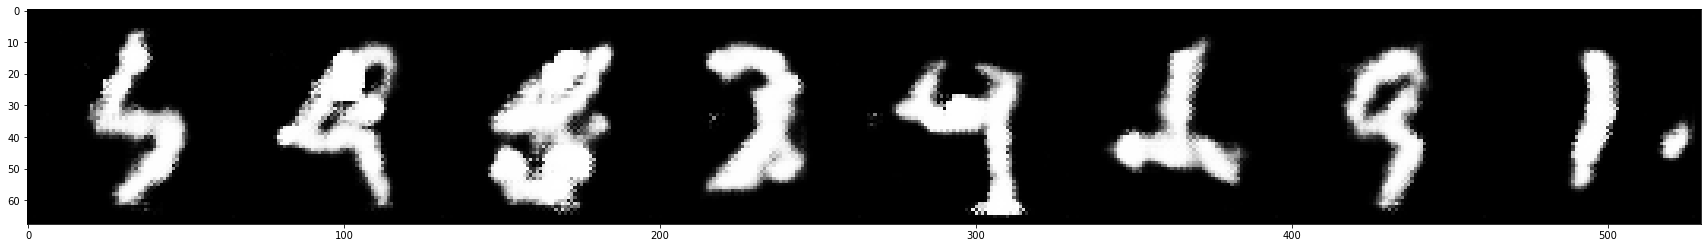

Epoch: 851 | Discriminator Loss - -0.09213685989379883 | Gradient Penalty - 0.03733223304152489 |Generator Loss - -0.5624728202819824]
Epoch: 901 | Discriminator Loss - -0.0921492874622345 | Gradient Penalty - 0.025415275245904922 |Generator Loss - -0.5528796911239624]

Epoch 93
Epoch: 51 | Discriminator Loss - -0.0845508724451065 | Gradient Penalty - 0.034713972359895706 |Generator Loss - -0.4101884663105011]
Epoch: 101 | Discriminator Loss - -0.08775345236063004 | Gradient Penalty - 0.03502296656370163 |Generator Loss - -0.48942384123802185]
Epoch: 151 | Discriminator Loss - -0.0998961478471756 | Gradient Penalty - 0.04514477774500847 |Generator Loss - -0.4977237582206726]
Epoch: 201 | Discriminator Loss - -0.09882679581642151 | Gradient Penalty - 0.03902724012732506 |Generator Loss - -0.4684257209300995]
Epoch: 251 | Discriminator Loss - -0.11101703345775604 | Gradient Penalty - 0.04491223022341728 |Generator Loss - -0.4537844955921173]
Epoch: 301 | Discriminator Loss - -0.108494520

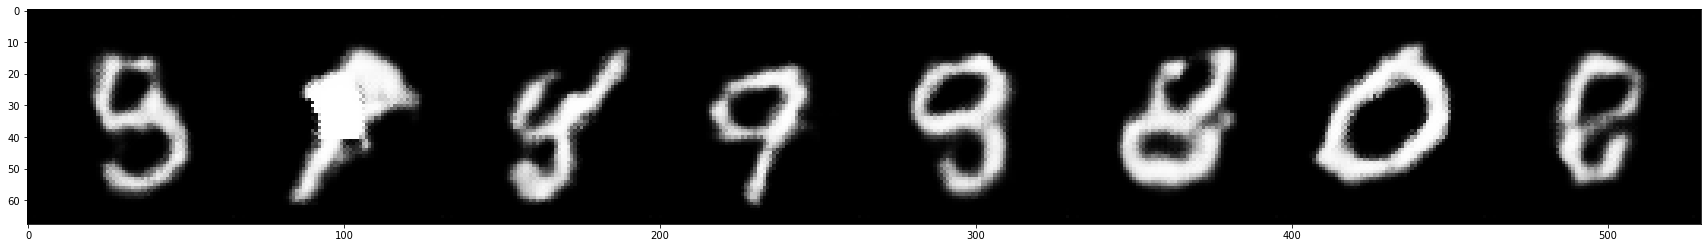

Epoch: 851 | Discriminator Loss - -0.10668870061635971 | Gradient Penalty - 0.02624598890542984 |Generator Loss - -0.4749729633331299]
Epoch: 901 | Discriminator Loss - -0.04470912367105484 | Gradient Penalty - 0.04857226461172104 |Generator Loss - -0.5562289953231812]

Epoch 94
Epoch: 51 | Discriminator Loss - -0.09368769824504852 | Gradient Penalty - 0.059163644909858704 |Generator Loss - -0.461832195520401]
Epoch: 101 | Discriminator Loss - -0.101235032081604 | Gradient Penalty - 0.017148256301879883 |Generator Loss - -0.5225186347961426]
Epoch: 151 | Discriminator Loss - -0.12255934625864029 | Gradient Penalty - 0.022426480427384377 |Generator Loss - -0.4996562898159027]
Epoch: 201 | Discriminator Loss - -0.0730215311050415 | Gradient Penalty - 0.04651007056236267 |Generator Loss - -0.4628889858722687]
Epoch: 251 | Discriminator Loss - -0.08261182904243469 | Gradient Penalty - 0.027949662879109383 |Generator Loss - -0.5347564220428467]
Epoch: 301 | Discriminator Loss - -0.118315309

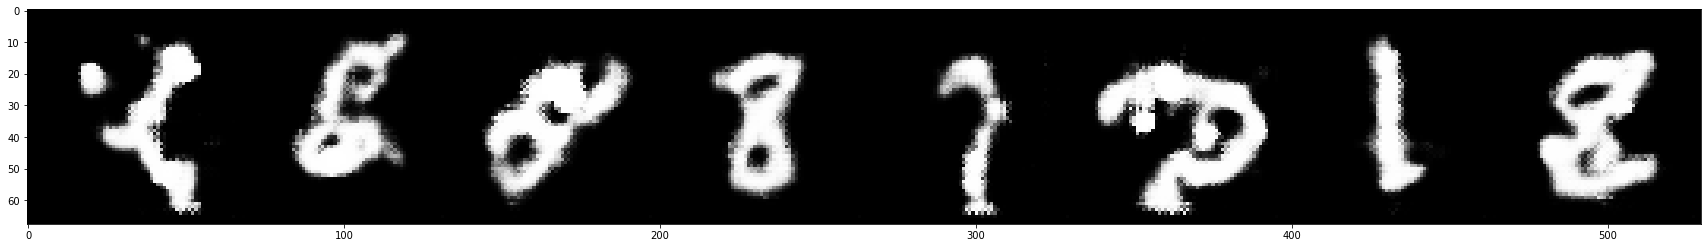

Epoch: 851 | Discriminator Loss - -0.11666685342788696 | Gradient Penalty - 0.03422638773918152 |Generator Loss - -0.38928499817848206]
Epoch: 901 | Discriminator Loss - -0.11096546053886414 | Gradient Penalty - 0.038390547037124634 |Generator Loss - -0.5007842183113098]

Epoch 95
Epoch: 51 | Discriminator Loss - -0.12893527746200562 | Gradient Penalty - 0.039052482694387436 |Generator Loss - -0.45806148648262024]
Epoch: 101 | Discriminator Loss - -0.050818897783756256 | Gradient Penalty - 0.052319906651973724 |Generator Loss - -0.5288609862327576]
Epoch: 151 | Discriminator Loss - -0.08448532223701477 | Gradient Penalty - 0.029086444526910782 |Generator Loss - -0.4967145323753357]
Epoch: 201 | Discriminator Loss - -0.07198925316333771 | Gradient Penalty - 0.05405636131763458 |Generator Loss - -0.49645185470581055]
Epoch: 251 | Discriminator Loss - -0.11642850935459137 | Gradient Penalty - 0.026868749409914017 |Generator Loss - -0.5019313097000122]
Epoch: 301 | Discriminator Loss - -0.

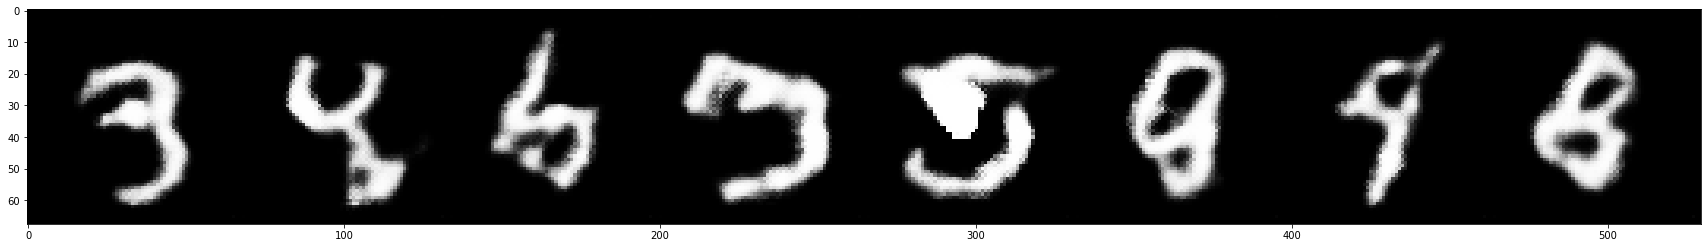

In [ ]:
data_loader, _ = get_mnist_dataloaders(batch_size=64)
img_size = (64, 64, 1)

generator = Generator(img_size=img_size, latent_dim=100, dim=16)
discriminator = Discriminator(img_size=img_size, dim=16)

lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
epochs = 200
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer)

trainer.train(data_loader, epochs, save_training_gif=True)